# Exploratory analysis on Olist data

## Dependencies

In [1]:
!pip install -q pca

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from datetime import datetime
from pca import pca
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib.patches import Circle
from sklearn.decomposition import PCA
pd.set_option("display.max_rows", 101)
pd.options.display.max_columns = 999

In [3]:
from google.colab import drive

## Aux functions

In [4]:
def test_completion(data):
    """
    Compute sorted completion rate and number of missing values for each variable of the argument in a descending order

    Args:
        data(dataset) : A dataset with variables

    Returns:
        A specific dataframe with completion rate for each variable.
        Schema :
            Index(string): Variable names
            Taux de completion(float): completion rate
            Nombre de valeurs manquantes(int): Number of missing values
    """
    var_dict = {}

    for col in data.columns:
        var_dict[col] = []
        var_dict[col].append(round((data[col].notna().sum()/data.shape[0])*100,2))
        var_dict[col].append(data[col].isna().sum())

    return pd.DataFrame.from_dict(data=var_dict, orient="index", columns = ["Completion rate", "Number of missing values"]).sort_values(by="Completion rate", ascending=False)

In [5]:
# Replace missing values
def replace_nan(df, columns, method='mean'):
  if columns == []:
    raise Exception('Specify atleast one column!')

  if method == 'mean':
    for c in columns:
      df[c].fillna(df[c].mean(), inplace=True)

  if method == 'median':
    for c in columns:
      df[c].fillna(df[c].median(), inplace=True)

  if method == 'zeros':
    for c in columns:
      df[c].fillna(0, inplace=True)

## Data

In [6]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
path = '/content/drive/My Drive/OCL/P5/'

In [8]:
customers = pd.read_csv(path+'data/olist_customers_dataset.csv')
geolocalisation = pd.read_csv(path+'data/olist_geolocation_dataset.csv')
order_items = pd.read_csv(path+'data/olist_order_items_dataset.csv')
order_payments = pd.read_csv(path+'data/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(path+'data/olist_order_reviews_dataset.csv')
orders = pd.read_csv(path+'data/olist_orders_dataset.csv')
products = pd.read_csv(path+'data/olist_products_dataset.csv')
sellers = pd.read_csv(path+'data/olist_sellers_dataset.csv')
translation = pd.read_csv(path+'data/product_category_name_translation.csv')

## Observation

In [9]:
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [10]:
geolocalisation.head(2)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP


In [11]:
order_items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [12]:
order_payments.head(2)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


In [13]:
order_reviews.head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


In [14]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [15]:
products.head(2)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0


In [16]:
sellers.head(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP


In [17]:
translation.head(2)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories


In [18]:
list_df = [customers,
            geolocalisation,
            order_items,
            order_payments,
            order_reviews,
            orders,products,
            sellers,
            translation]

In [19]:
names_df = ['customers',
           'geolocalisation',
           'order_items',
           'order_payments',
           'order_reviews',
           'orders',
           'products',
           'sellers',
           'translation']

In [20]:
for df in list_df:
  print(df.shape)

(99441, 5)
(1000163, 5)
(112650, 7)
(103886, 5)
(99224, 7)
(99441, 8)
(32951, 9)
(3095, 4)
(71, 2)


### Missing values

In [21]:
for df in list_df:
    print(df.isna().sum().sum()/df.shape[0]/df.shape[1], 'NaN')

0.0 NaN
0.0 NaN
0.0 NaN
0.0 NaN
0.21006294560071873 NaN
0.00616948743476031 NaN
0.008254681193287003 NaN
0.0 NaN
0.0 NaN


**Only order_reviews, orders and products have NaN values**

In [22]:
order_reviews.isna().sum(axis=0)

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [23]:
orders.isna().sum(axis=0)

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [24]:
products.isna().sum(axis=0)

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [25]:
products.shape

(32951, 9)

### Duplicates

In [26]:
for df in list_df:
    print(df.duplicated().sum())

0
261831
0
0
0
0
0
0
0


### Data types

In [27]:
i=0
list_indices = []
list_columns = []
list_types = []
list_unique = []

for df in list_df:

    for column in df.columns:
        list_indices.append(names_df[i])
        list_columns.append(column)
        list_types.append(df[column].dtype)
        list_unique.append(df[column].nunique())
    i+=1
resume_data = pd.DataFrame([list_indices,
                            list_columns,
                            list_types,
                            list_unique]
                          ).T
resume_data.columns=['Data', 'Column name', 'Type', 'Unique values']
resume_data

,Data,Column name,Type,Unique values
0,customers,customer_id,object,99441
1,customers,customer_unique_id,object,96096
2,customers,customer_zip_code_prefix,int64,14994
3,customers,customer_city,object,4119
4,customers,customer_state,object,27
5,geolocalisation,geolocation_zip_code_prefix,int64,19015
6,geolocalisation,geolocation_lat,float64,717360
7,geolocalisation,geolocation_lng,float64,717613
8,geolocalisation,geolocation_city,object,8011
9,geolocalisation,geolocation_state,object,27


## Cleaning

In [28]:
def control_df(data_list):
    '''
    Verify if a given list is a list of dataframes.
    '''
    if type(data_list) is list:
        if len(data_list) == 9:
            for df in data_list:
                if type(df) is not type(pd.DataFrame()):
                    return False
        else:
            return False
    else:
        return False
    return True

In [29]:
def clean(data_list):
    '''Nettoyage des différents dataframe
    Entrée : liste de 9 dataframes

    Traitement appliqué :
    * complétion des NaN,
    * nettoyage type,
    * merge catégories de produits

    Return : liste des dataframe nettoyée
    '''
    if not control_df(data_list):
        return False

    customers_local = data_list[0].copy()
    geolocalisation_local  = data_list[1].copy()
    order_items_local  = data_list[2].copy()
    order_payments_local  = data_list[3].copy()
    order_reviews_local  = data_list[4].copy()
    orders_local  = data_list[5].copy()
    products_local = data_list[6].copy()
    sellers_local = data_list[7].copy()
    translation_local = data_list[8].copy()


    #Nan Values
    geolocalisation_local.drop_duplicates(inplace=True)

    order_reviews_local['review_comment_title'].fillna(' ',
                                                       inplace=True)
    order_reviews_local['review_comment_message'].fillna(' ',
                                                         inplace=True)

    orders['order_approved_at'].fillna(-1, inplace=True)
    orders['order_delivered_carrier_date'].fillna(0, inplace=True)
    orders['order_delivered_customer_date'].fillna(0, inplace=True)

    products_local['product_category_name'].fillna('Unkwown',
                                                   inplace=True)
    products_local['product_name_lenght'].fillna(0, inplace=True)
    products_local['product_description_lenght'].fillna(0,
                                                        inplace=True)
    products_local['product_photos_qty'].fillna(0, inplace=True)
    products_local['product_weight_g'].fillna(0, inplace=True)
    products_local['product_length_cm'].fillna(0, inplace=True)
    products_local['product_height_cm'].fillna(0, inplace=True)
    products_local['product_width_cm'].fillna(0, inplace=True)

    #type cleaning:
    order_items_local['shipping_limit_date'] = order_items_local[
        'shipping_limit_date'].astype('datetime64')
    orders_local['order_purchase_timestamp'] = orders_local[
        'order_purchase_timestamp'].astype('datetime64')
    orders_local['order_approved_at'] = pd.to_datetime(orders_local[
        'order_approved_at'], errors='coerce')
    orders_local['order_delivered_carrier_date'] = pd.to_datetime(
        orders_local['order_delivered_carrier_date'], errors='coerce')
    orders_local['order_delivered_customer_date'] = pd.to_datetime(
        orders_local['order_delivered_customer_date'], errors='coerce')
    orders_local['order_estimated_delivery_date'] = orders_local[
        'order_estimated_delivery_date'].astype('datetime64')

    #merge product categories
    products_local = pd.merge(products_local, translation_local).drop(
        ['product_category_name'], axis=1)

    return [
        customers_local,
        geolocalisation_local,
        order_items_local,
        order_payments_local,
        order_reviews_local,
        orders_local,
        products_local,
        sellers_local,
        translation_local]

In [30]:
list_df = clean(list_df)

In [31]:
for df in list_df:
  print(df.shape)

(99441, 5)
(738332, 5)
(112650, 7)
(103886, 5)
(99224, 7)
(99441, 8)
(32328, 9)
(3095, 4)
(71, 2)


### Outliers

In [32]:
def clean_univariate_outliers(dataframe):
  for column in dataframe.select_dtypes(include = ['int32','float64']).columns.tolist():
    column_lq = dataframe[column].quantile(0.25)
    column_uq = dataframe[column].quantile(0.75)
    column_iqr = column_uq - column_lq
    lower_bound = column_lq - 1.5*column_iqr
    upper_bound = column_uq + 1.5*column_iqr
    index_to_drop = dataframe[(dataframe[column] <= lower_bound) | (dataframe[column] >= upper_bound)].index.values
    dataframe.drop(index=index_to_drop, inplace=True)

In [33]:
for df in list_df:
  clean_univariate_outliers(df)

In [34]:
def clean_multivariate_outliers(dataframe):
    lof = LocalOutlierFactor(n_neighbors = 5, n_jobs=-1)
    cols = dataframe.select_dtypes(['float64','int32']).dropna()
    if not cols.empty:
      lof.fit_predict(cols)
      indices = dataframe.select_dtypes(['float64','int32']).dropna().index
      df_lof = pd.DataFrame(index = indices, data = lof.negative_outlier_factor_, columns=['lof'])
      index_to_drop = df_lof[df_lof['lof']< np.quantile(
          lof.negative_outlier_factor_, 0.01)].index
      dataframe.drop(index_to_drop, axis=0, inplace=True)

In [35]:
for df in list_df:
  clean_multivariate_outliers(df)

In [36]:
for df in list_df:
  print(df.shape)

(99441, 5)
(596214, 5)
(93035, 7)
(95049, 5)
(99224, 7)
(99441, 8)
(21878, 9)
(3095, 4)
(71, 2)


In [37]:
customers = list_df[0]
geolocalisation = list_df[1]
order_items = list_df[2]
order_payments = list_df[3]
order_reviews = list_df[4]
orders = list_df[5]
products = list_df[6]
sellers = list_df[7]
translation = list_df[8]

In [38]:
dict_categories = {
#home
'furniture_living_room' : 'home',
'furniture_mattress_and_upholstery' : 'home',
'furniture_bedroom' : 'home',
'furniture_decor' : 'home',
'bed_bath_table' : 'home',
'kitchen_dining_laundry_garden_furniture' : 'home',
'la_cuisine' : 'home',
'home_confort' : 'home',
'home_comfort_2' : 'home',
'christmas_supplies' : 'home',

#appliances
'small_appliances' : 'appliances',
'small_appliances_home_oven_and_coffee' : 'appliances',
'home_appliances_2' : 'appliances',
'home_appliances' : 'appliances',
'housewares' : 'appliances',

#construction
'construction_tools_construction': 'construction',
'costruction_tools_garden': 'construction',
'costruction_tools_tools': 'construction',
'construction_tools_safety': 'construction',
'construction_tools_lights': 'construction',
'home_construction': 'construction',
'air_conditioning': 'construction',
#furnitures

#office
'office_furniture' : 'office',
'industry_commerce_and_business' : 'office',
'stationery' : 'office',
'agro_industry_and_commerce' : 'office',
'signaling_and_security' : 'office',
'furnitures' : 'office',
'security_and_services' : 'office',
#electronics
'telephony' : 'electronics',
'electronics': 'electronics',
'computers_accessories': 'electronics',
'consoles_games': 'electronics',
'fixed_telephony': 'electronics',
'audio': 'electronics',
'computers': 'electronics',
'tablets_printing_image': 'electronics',
#sports_leisure
'sports_leisure' : 'sports_leisure',
'musical_instruments': 'sports_leisure',
'party_supplies': 'sports_leisure',
'luggage_accessories': 'sports_leisure',
#arts
'books' : 'arts',
'books_imported': 'arts',
'books_general_interest': 'arts',
'books_technical': 'arts',
'art': 'arts',
'toys': 'arts',
'cine_photo': 'arts',
'cds_dvds_musicals': 'arts',
'music': 'arts',
'dvds_blu_ray': 'arts',
'arts_and_craftmanship': 'arts',
#fashion
'watches_gifts' : 'fashion',
'fashion_bags_accessories' : 'fashion',
'fashion_underwear_beach' : 'fashion',
'fashion_shoes' : 'fashion',
'fashion_male_clothing' : 'fashion',
'fashio_female_clothing' : 'fashion',
'fashion_sport' : 'fashion',
'fashion_childrens_clothes' : 'fashion',
#health_beauty
'health_beauty' : 'health_beauty',
'baby': 'health_beauty',
'diapers_and_hygiene' : 'health_beauty',
'perfumery' : 'health_beauty',
#garden and pets
'flowers' : 'garden_pets',
'pet_shop' : 'garden_pets',
'garden_tools' : 'garden_pets',
#auto
'auto' : 'auto',
#food_drinks
'food_drink' : 'food_drinks',
'food' : 'food_drinks',
'drinks' : 'food_drinks',
#other
'Unknown' : 'other',
'market_place' : 'other',
'cool_stuff' : 'other'}

In [39]:
products['product_category_name_english'] = products['product_category_name_english'].map(dict_categories)

In [40]:
customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [41]:
order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112639,fffb2ef8874127f75b52b643880fd7e0,1,ebceb9726cf5c6187b48e17fe58747b0,609e1a9a6c2539919b8205cf7c4e6ff0,2018-04-09 05:08:33,17.90,22.06
112644,fffbee3b5462987e66fb49b1c5411df2,1,6f0169f259bb0ff432bfff7d829b9946,213b25e6f54661939f11710a6fddb871,2018-06-28 09:58:03,119.85,20.03
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [42]:
products

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,health_beauty
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,health_beauty
2,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,health_beauty
3,b1eae565a61935e0011ee7682fef9dc9,49.0,460.0,2.0,267.0,17.0,13.0,17.0,health_beauty
4,8da90b37f0fb171b4877c124f965b1f6,56.0,733.0,3.0,377.0,18.0,13.0,15.0,health_beauty
...,...,...,...,...,...,...,...,...,...
32311,2072d4792ab7893ddbfc178948e0eb86,60.0,429.0,1.0,1800.0,35.0,8.0,30.0,home
32312,19de58ea609a59ce31f93672af50c09a,56.0,581.0,2.0,3750.0,41.0,10.0,33.0,home
32315,8db75af9aed3315374db44d7860e25da,48.0,461.0,4.0,400.0,26.0,22.0,11.0,office
32316,6c7a0a349ad11817745e3ad58abd5c79,55.0,506.0,1.0,1225.0,27.0,35.0,15.0,office


In [43]:
order_items = order_items.merge(products, on='product_id', how='right')

In [44]:
order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,e17e4f88e31525f7deef66779844ddce,1.0,1e9e8ef04dbcff4541ed26657ea517e5,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39,40.0,287.0,1.0,225.0,16.0,10.0,14.0,health_beauty
1,048cc42e03ca8d43c729adf6962cb348,1.0,6a2fb4dd53d2cdb88e0432f1284a004c,7040e82f899a04d1b434b795a43b4617,2017-11-23 21:31:31,16.90,7.78,39.0,346.0,2.0,400.0,27.0,5.0,20.0,health_beauty
2,5fa78e91b5cb84b6a8ccc42733f95742,1.0,6a2fb4dd53d2cdb88e0432f1284a004c,7040e82f899a04d1b434b795a43b4617,2017-12-14 16:33:14,16.90,7.78,39.0,346.0,2.0,400.0,27.0,5.0,20.0,health_beauty
3,7b13c77c64a9a956500cbf1a9a23798d,1.0,0d009643171aee696f4733340bc2fdd0,7178f9f4dd81dcef02f62acdf8151e01,2018-05-30 10:38:35,275.00,23.48,52.0,150.0,1.0,422.0,21.0,16.0,18.0,health_beauty
4,e005be792ff63719b707213974186c8d,1.0,0d009643171aee696f4733340bc2fdd0,7178f9f4dd81dcef02f62acdf8151e01,2018-05-23 17:15:14,275.00,23.48,52.0,150.0,1.0,422.0,21.0,16.0,18.0,health_beauty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70127,742a36775534b588ed2a62ba4c2d9cd7,1.0,1dceebcc5f23c02ea23e16d5bedca000,4e922959ae960d389249c378d1c939f5,2017-08-08 02:23:30,45.00,9.94,47.0,117.0,2.0,550.0,35.0,15.0,25.0,arts
70128,9c782cb7854e5dfa91927cfca8949eb8,1.0,1dceebcc5f23c02ea23e16d5bedca000,4e922959ae960d389249c378d1c939f5,2017-07-19 11:35:22,45.00,16.11,47.0,117.0,2.0,550.0,35.0,15.0,25.0,arts
70129,cea54c1853c864ab36cea3ef732d7191,1.0,1dceebcc5f23c02ea23e16d5bedca000,4e922959ae960d389249c378d1c939f5,2017-11-14 11:50:17,65.00,9.94,47.0,117.0,2.0,550.0,35.0,15.0,25.0,arts
70130,d4e8d3bb5e3673ed68ac154fe86de946,1.0,1dceebcc5f23c02ea23e16d5bedca000,4e922959ae960d389249c378d1c939f5,2017-11-03 11:29:30,45.00,16.11,47.0,117.0,2.0,550.0,35.0,15.0,25.0,arts


In [45]:
orders = pd.merge(orders, order_items, on='order_id')

In [46]:
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,appliances
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,29.0,178.0,1.0,400.0,19.0,13.0,19.0,health_beauty
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,59.0,468.0,3.0,450.0,30.0,10.0,20.0,garden_pets
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,38.0,316.0,4.0,250.0,51.0,15.0,15.0,office
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67850,b0f4af5c1b06e24fef510703bfe9f0a6,8e1ec396e317ff4c82a03ce16a0c3eb3,delivered,2017-10-27 15:21:00,2017-10-27 15:32:49,2017-10-30 15:44:34,2017-11-10 17:57:22,2017-11-22,1.0,595fac2a385ac33a80bd5114aec74eb8,058fd0aa2bfdb2274e05e1ae971dabb6,2017-11-03 15:30:22,142.50,21.80,29.0,178.0,1.0,400.0,19.0,13.0,19.0,health_beauty
67851,cfa78b997e329a5295b4ee6972c02979,a2f7428f0cafbc8e59f20e1444b67315,delivered,2017-12-20 09:52:41,2017-12-20 10:09:52,2017-12-20 20:25:25,2018-01-26 15:45:14,2018-01-18,1.0,3d2c44374ee42b3003a470f3e937a2ea,ce248b21cb2adc36282ede306b7660e5,2017-12-27 10:09:52,55.90,15.14,34.0,372.0,2.0,300.0,16.0,6.0,12.0,sports_leisure
67852,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22,1.0,ea73128566d1b082e5101ce46f8107c7,391fc6631aebcf3004804e51b40bcf1e,2017-02-27 09:05:12,139.90,16.09,63.0,254.0,2.0,2500.0,49.0,13.0,41.0,home
67853,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,1.0,ac35486adb7b02598c182c2ff2e05254,e24fc9fcd865784fb25705606fe3dfe7,2017-03-15 09:54:05,72.00,13.08,50.0,1517.0,1.0,1175.0,22.0,13.0,18.0,health_beauty


In [47]:
sellers

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


In [48]:
orders = pd.merge(orders, order_payments, on='order_id')

In [49]:
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,appliances,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,appliances,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,appliances,2,voucher,1,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,29.0,178.0,1.0,400.0,19.0,13.0,19.0,health_beauty,1,boleto,1,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto,1,credit_card,3,179.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68071,b0f4af5c1b06e24fef510703bfe9f0a6,8e1ec396e317ff4c82a03ce16a0c3eb3,delivered,2017-10-27 15:21:00,2017-10-27 15:32:49,2017-10-30 15:44:34,2017-11-10 17:57:22,2017-11-22,1.0,595fac2a385ac33a80bd5114aec74eb8,058fd0aa2bfdb2274e05e1ae971dabb6,2017-11-03 15:30:22,142.50,21.80,29.0,178.0,1.0,400.0,19.0,13.0,19.0,health_beauty,1,credit_card,3,164.30
68072,cfa78b997e329a5295b4ee6972c02979,a2f7428f0cafbc8e59f20e1444b67315,delivered,2017-12-20 09:52:41,2017-12-20 10:09:52,2017-12-20 20:25:25,2018-01-26 15:45:14,2018-01-18,1.0,3d2c44374ee42b3003a470f3e937a2ea,ce248b21cb2adc36282ede306b7660e5,2017-12-27 10:09:52,55.90,15.14,34.0,372.0,2.0,300.0,16.0,6.0,12.0,sports_leisure,1,credit_card,1,71.04
68073,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22,1.0,ea73128566d1b082e5101ce46f8107c7,391fc6631aebcf3004804e51b40bcf1e,2017-02-27 09:05:12,139.90,16.09,63.0,254.0,2.0,2500.0,49.0,13.0,41.0,home,1,credit_card,3,155.99
68074,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,1.0,ac35486adb7b02598c182c2ff2e05254,e24fc9fcd865784fb25705606fe3dfe7,2017-03-15 09:54:05,72.00,13.08,50.0,1517.0,1.0,1175.0,22.0,13.0,18.0,health_beauty,1,credit_card,3,85.08


In [50]:
orders.columns[0]

'order_id'

In [51]:
orders = orders.merge(order_reviews, how='right')

In [52]:
orders.dropna(inplace=True)

In [53]:
orders.drop(columns=['review_comment_message', 'review_comment_title', 'review_creation_date', 'review_answer_timestamp', 'review_id'], inplace=True)

In [54]:
customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [55]:
client_data = customers.merge(orders, how='right', on='customer_id')

In [56]:
client_data

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score
0,8a2e7ef9053dea531e4dc76bd6d853e6,64190b91b656ab8f37eb89b93dc84584,13380,nova odessa,SP,a548910a1c6147796b98fdf73dbeba33,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14,1.0,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-06 12:48:39,79.79,8.30,47.0,493.0,1.0,245.0,19.0,14.0,14.0,electronics,1.0,credit_card,1.0,88.09,5
1,840be0730010e9580efd289bc9f37706,dcd4940b3f96a3e2b73d8f73387230cf,8412,sao paulo,SP,e48aa0d2dcec3a2e87348811bcfdf22b,delivered,2017-06-30 15:38:46,2017-06-30 15:50:17,2017-07-03 16:22:53,2017-07-15 12:57:24,2017-08-03,1.0,3152a0c0d93abeec99e4a6169aecc88b,d2374cbcbb3ca4ab1086534108cc3ab7,2017-07-20 15:50:17,46.90,11.85,35.0,133.0,1.0,600.0,40.0,4.0,30.0,home,1.0,credit_card,2.0,58.75,5
2,daf813bc2e41c86027d086e8dfb35571,8c89391790076834500661cc1e5d6860,12316,jacarei,SP,9c214ac970e84273583ab523dfafd09b,delivered,2017-05-08 13:35:48,2017-05-08 13:50:15,2017-05-09 14:19:29,2017-05-16 16:49:51,2017-05-30,1.0,35afc973633aaeb6b877ff57b2793310,4a3ca9315b744ce9f8e9374361493884,2017-05-15 13:50:15,89.90,12.13,56.0,176.0,1.0,1825.0,53.0,10.0,40.0,home,1.0,credit_card,3.0,102.03,5
3,272b46feddddc51904608ddd90feee33,485fa1b8db05ed6fa0062ece4ce80d2e,35180,timoteo,MG,cdf9aa68e72324eeb25c7de974696ee2,delivered,2017-12-13 14:59:45,2017-12-13 15:07:23,2017-12-14 17:37:13,2017-12-22 12:49:55,2018-01-15,1.0,25e2023ed83352bde98dc1490d14c3d8,de23c3b98a88888289c6f5cc1209054a,2017-12-19 15:07:23,119.99,17.00,30.0,1024.0,1.0,887.0,30.0,22.0,20.0,arts,1.0,credit_card,1.0,136.99,5
4,8ebbeb09e94d1e789142983f73faa9cd,a5ee02c2d02b8929c0949fc114c5a19e,6700,cotia,SP,9d6f15f95d01e79bd1349cc208361f09,delivered,2018-02-12 16:07:34,2018-02-12 16:27:39,2018-02-14 20:04:16,2018-02-15 19:16:54,2018-02-26,1.0,acffe5d7cd56e6b564cf6841486644ff,db4350fd57ae30082dec7acbaacc17f9,2018-02-16 16:27:39,35.00,7.78,58.0,356.0,1.0,200.0,19.0,4.0,11.0,health_beauty,1.0,credit_card,2.0,42.78,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66686,486ce94ccf26c511ab93d31fefd5de0e,bc71d9dde7a14cf82eb4200b2a282131,35570,formiga,MG,acd45245723df7cb52772a34416b41b1,delivered,2018-04-19 19:44:47,2018-04-19 20:10:40,2018-04-20 22:24:23,2018-05-07 16:48:43,2018-05-10,1.0,30ccf4724f5227265f837e9ba0246278,dbc22125167c298ef99da25668e1011f,2018-04-25 20:10:40,79.60,15.41,52.0,573.0,1.0,1450.0,49.0,10.0,33.0,sports_leisure,1.0,credit_card,2.0,95.01,3
66687,3d7697c0971cb2606444adae322d8bb3,f4513d9cd4f25a8254176ceda0abdc5e,89835,sao domingos,SC,48f7ee67313eda32bfcf5b9c1dd9522d,delivered,2017-11-24 09:31:02,2017-11-24 09:39:31,2017-11-24 18:56:54,2017-12-12 23:21:52,2017-12-21,1.0,186fe07c8b8005ec6a498587ffbc1352,6560211a19b47992c3666cc44a7e94c0,2017-11-30 09:39:31,29.00,15.10,60.0,193.0,3.0,200.0,16.0,2.0,11.0,fashion,1.0,credit_card,1.0,44.10,5
66688,d0d7086dea6fcf42b9b690b9f3745c58,597cbb334f18a671472f7e16648228b4,22793,rio de janeiro,RJ,22ec9f0669f784db00fa86d035cf8602,delivered,2017-12-03 21:45:23,2017-12-03 22:08:00,2017-12-07 19:17:29,2017-12-08 17:19:00,2017-12-20,1.0,3a33c980b62eb1ef3b8ae61b6fc6fe55,46dc3b2cc0980fb8ec44634e21d2718e,2017-12-07 22:08:00,199.99,9.77,51.0,465.0,1.0,2363.0,23.0,27.0,19.0,arts,1.0,credit_card,1.0,209.76,5
66689,3aa00401736823c73e9fe8683328fa6b,96ac4cb74918d3ace141d3d3ddc1ff02,32667,betim,MG,7725825d039fc1f0ceb7635e3f7d9206,delivered,201

## Quick EDA

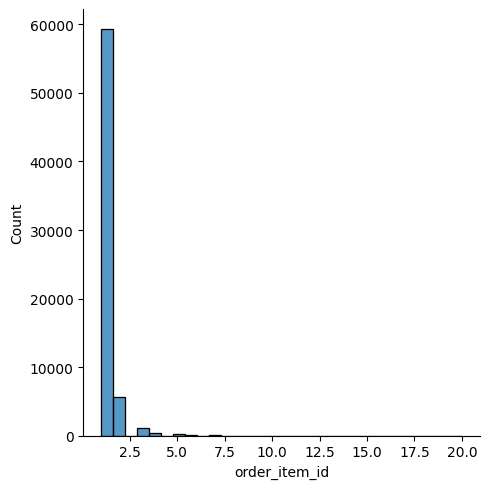

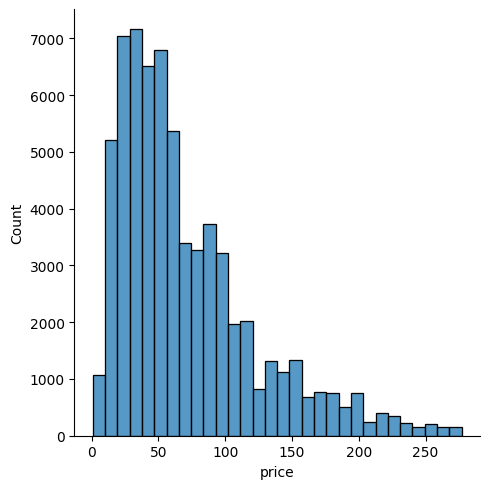

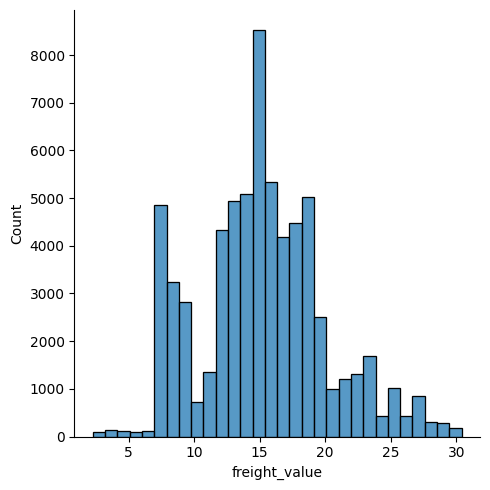

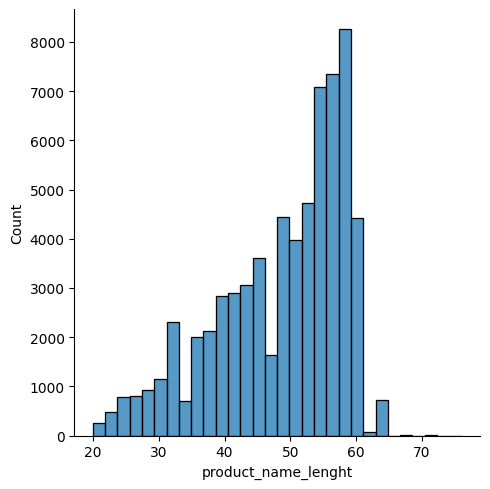

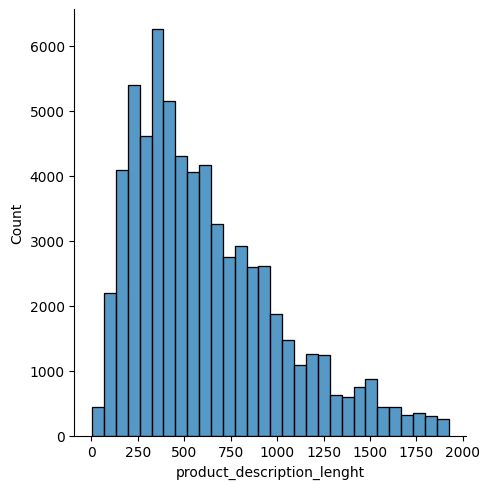

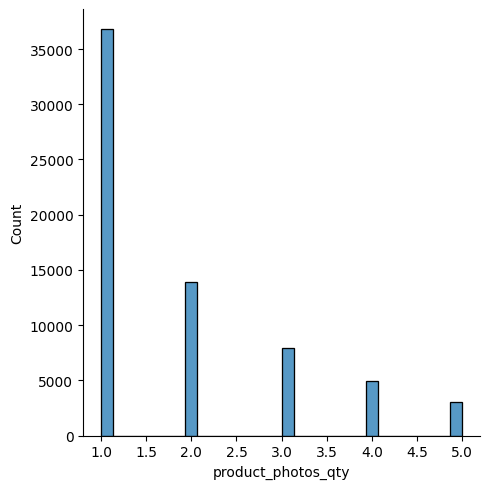

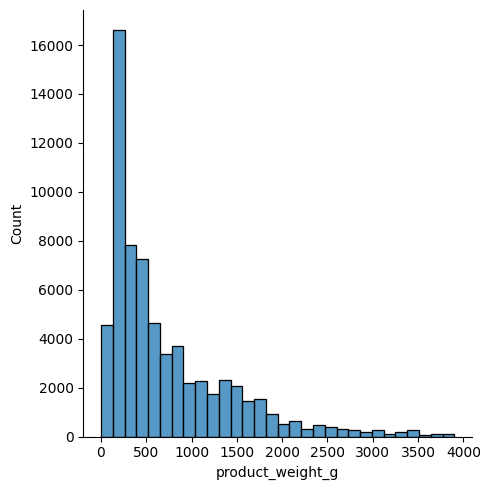

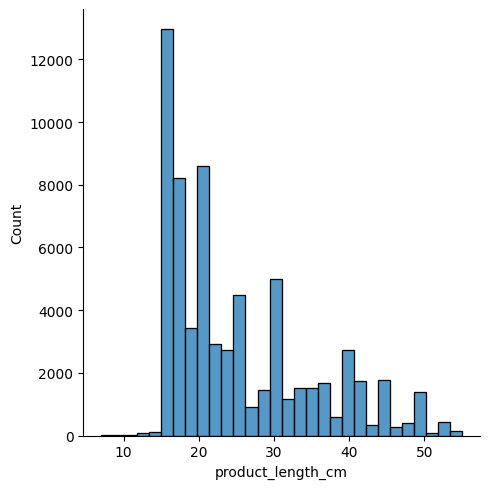

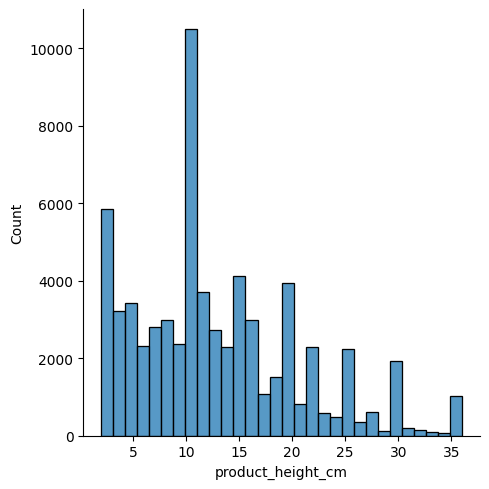

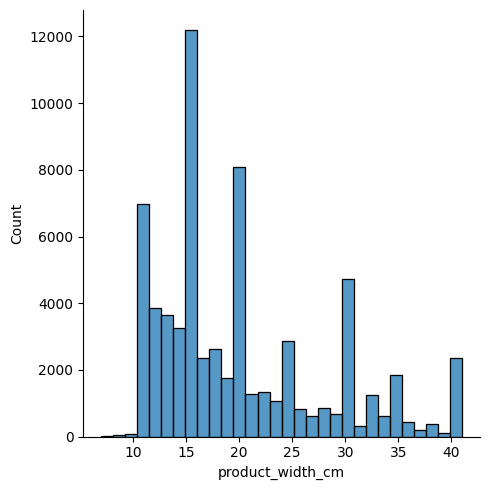

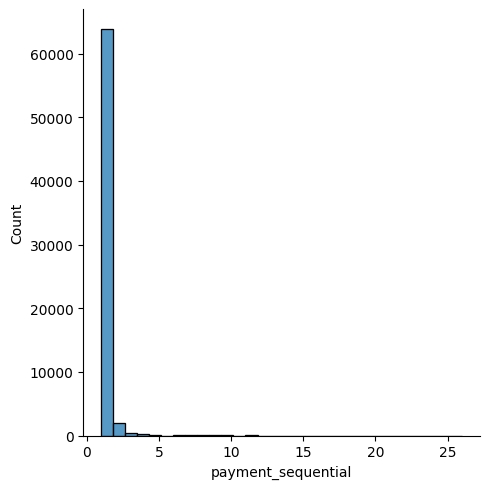

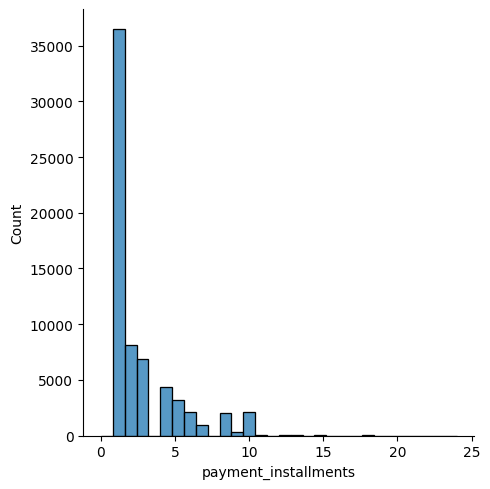

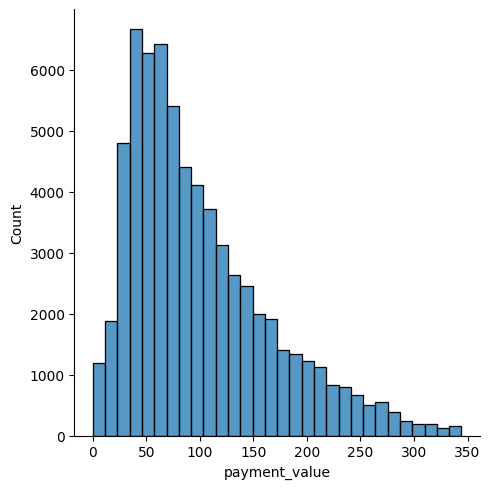

In [57]:
for column in client_data.select_dtypes(['int32', 'float64']).columns:
    if "date" in column or "zip_code" in column:
      continue
    sns.displot(client_data[column].dropna(), bins=30);

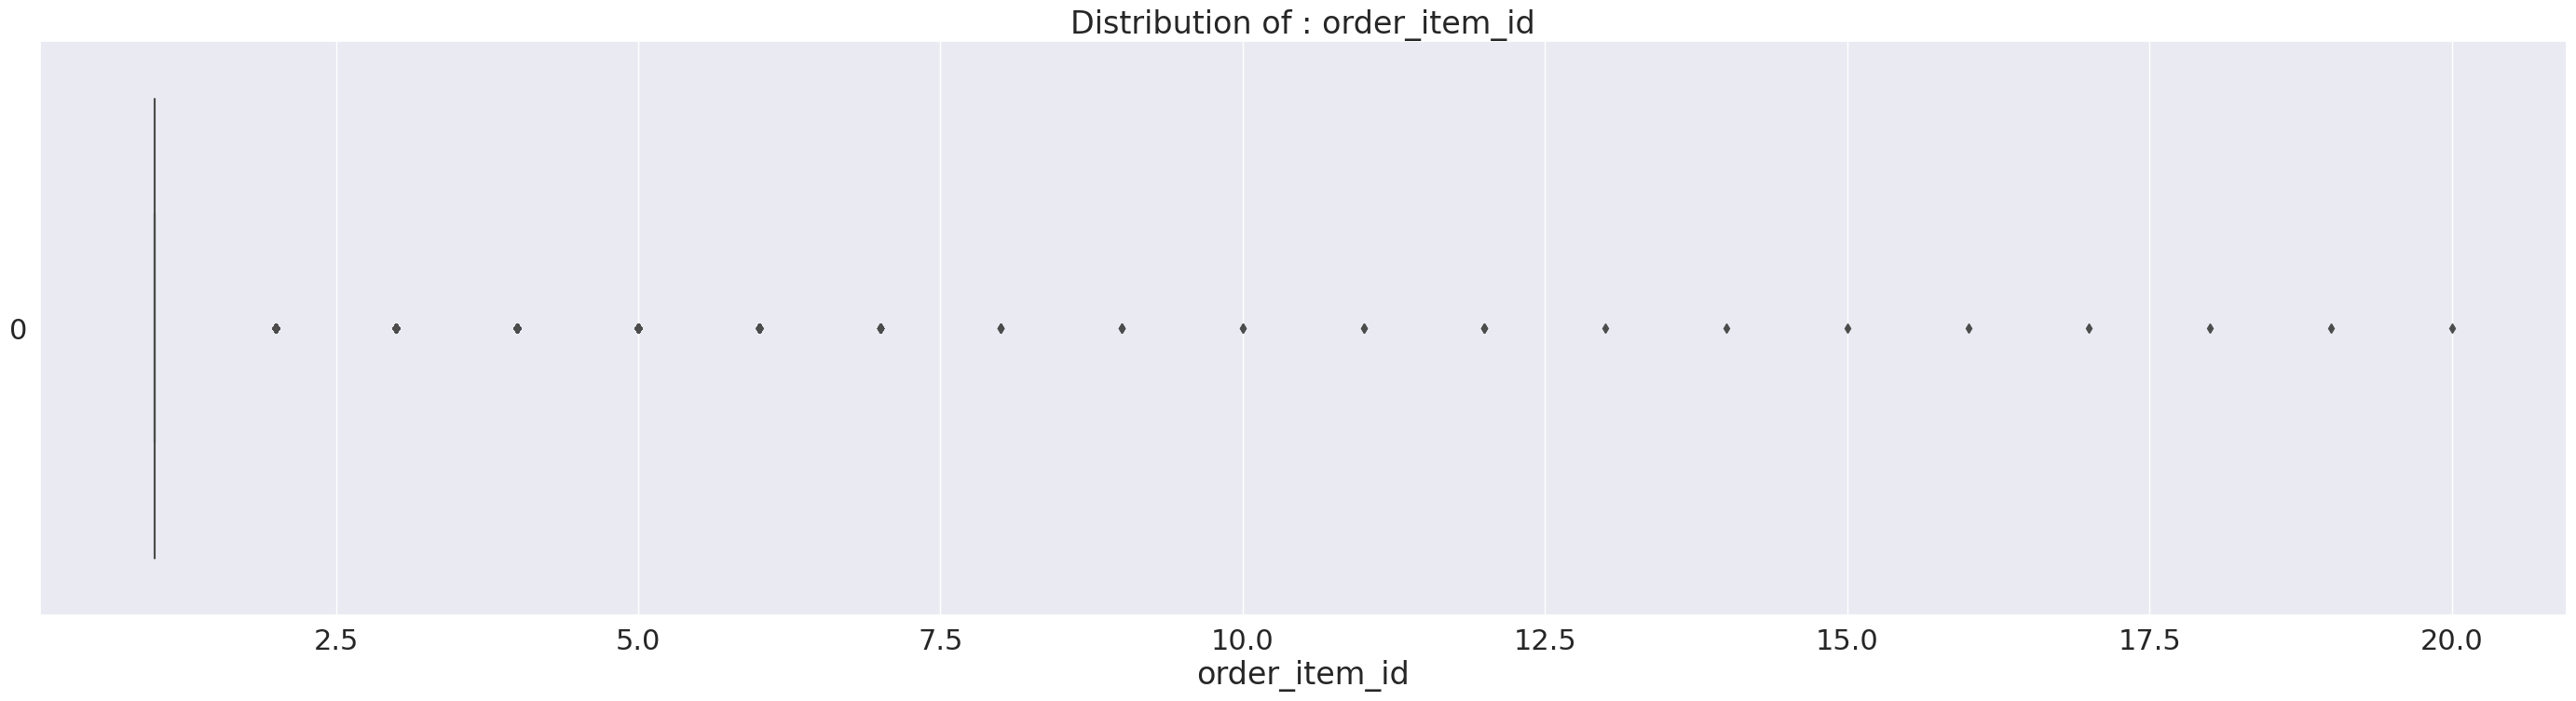

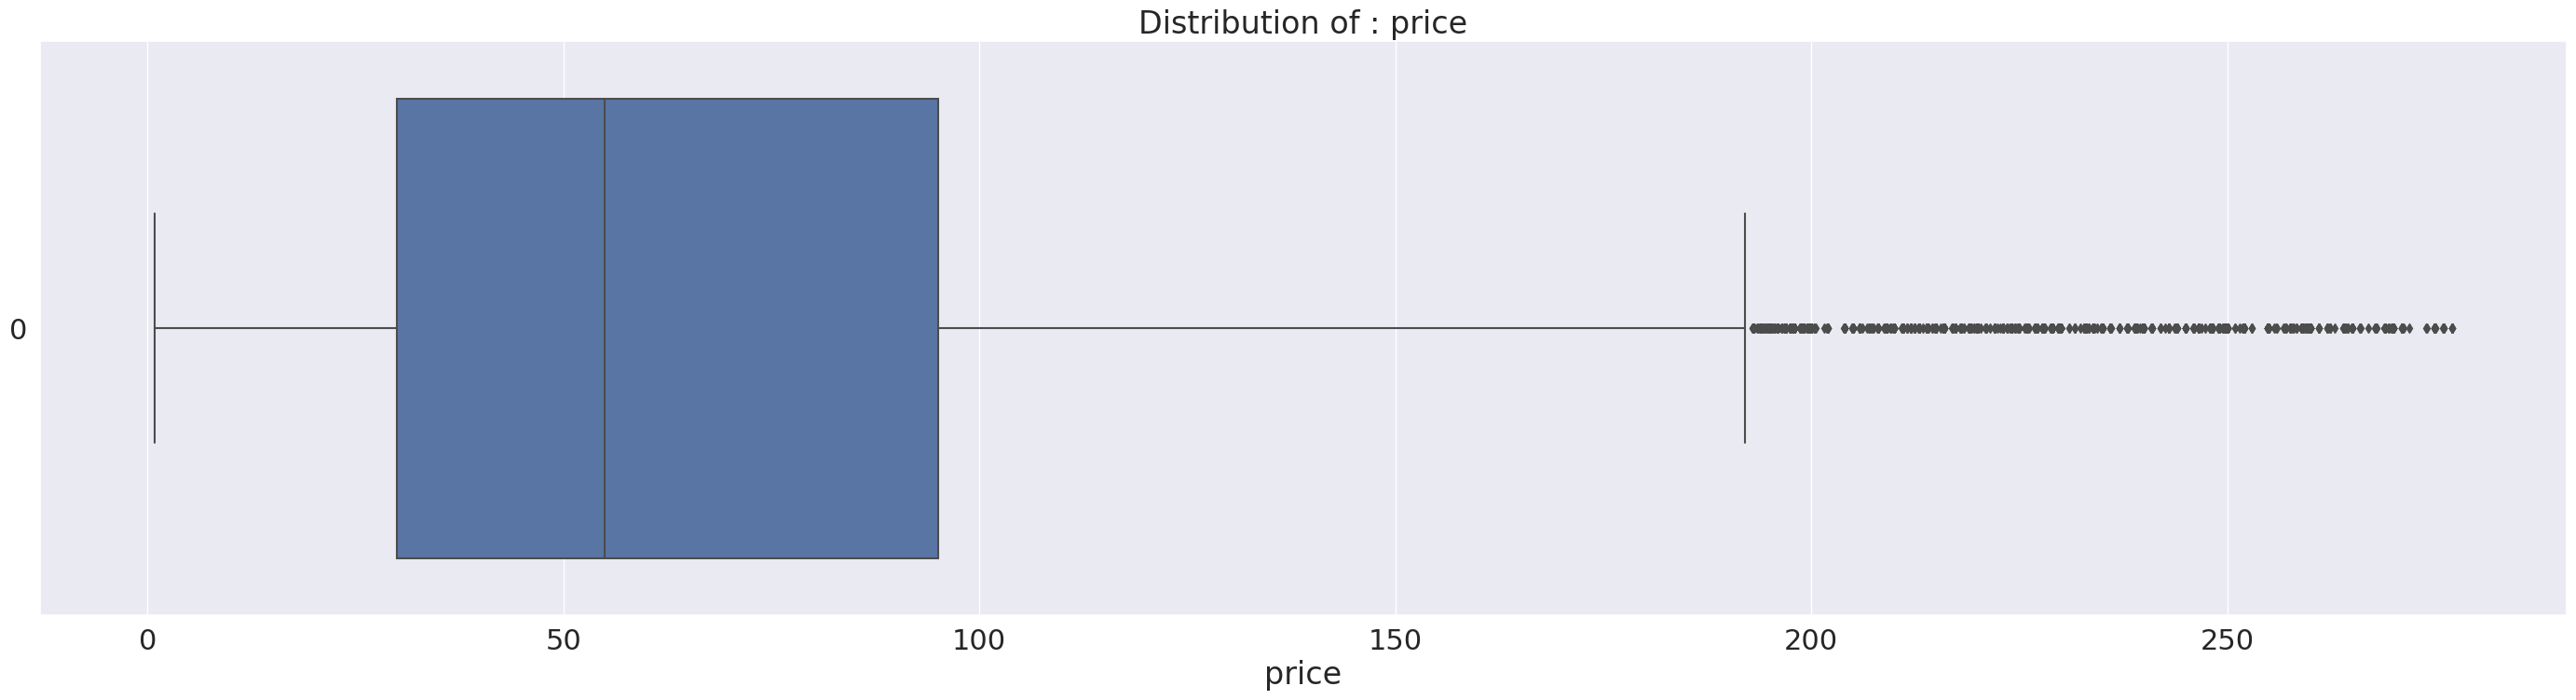

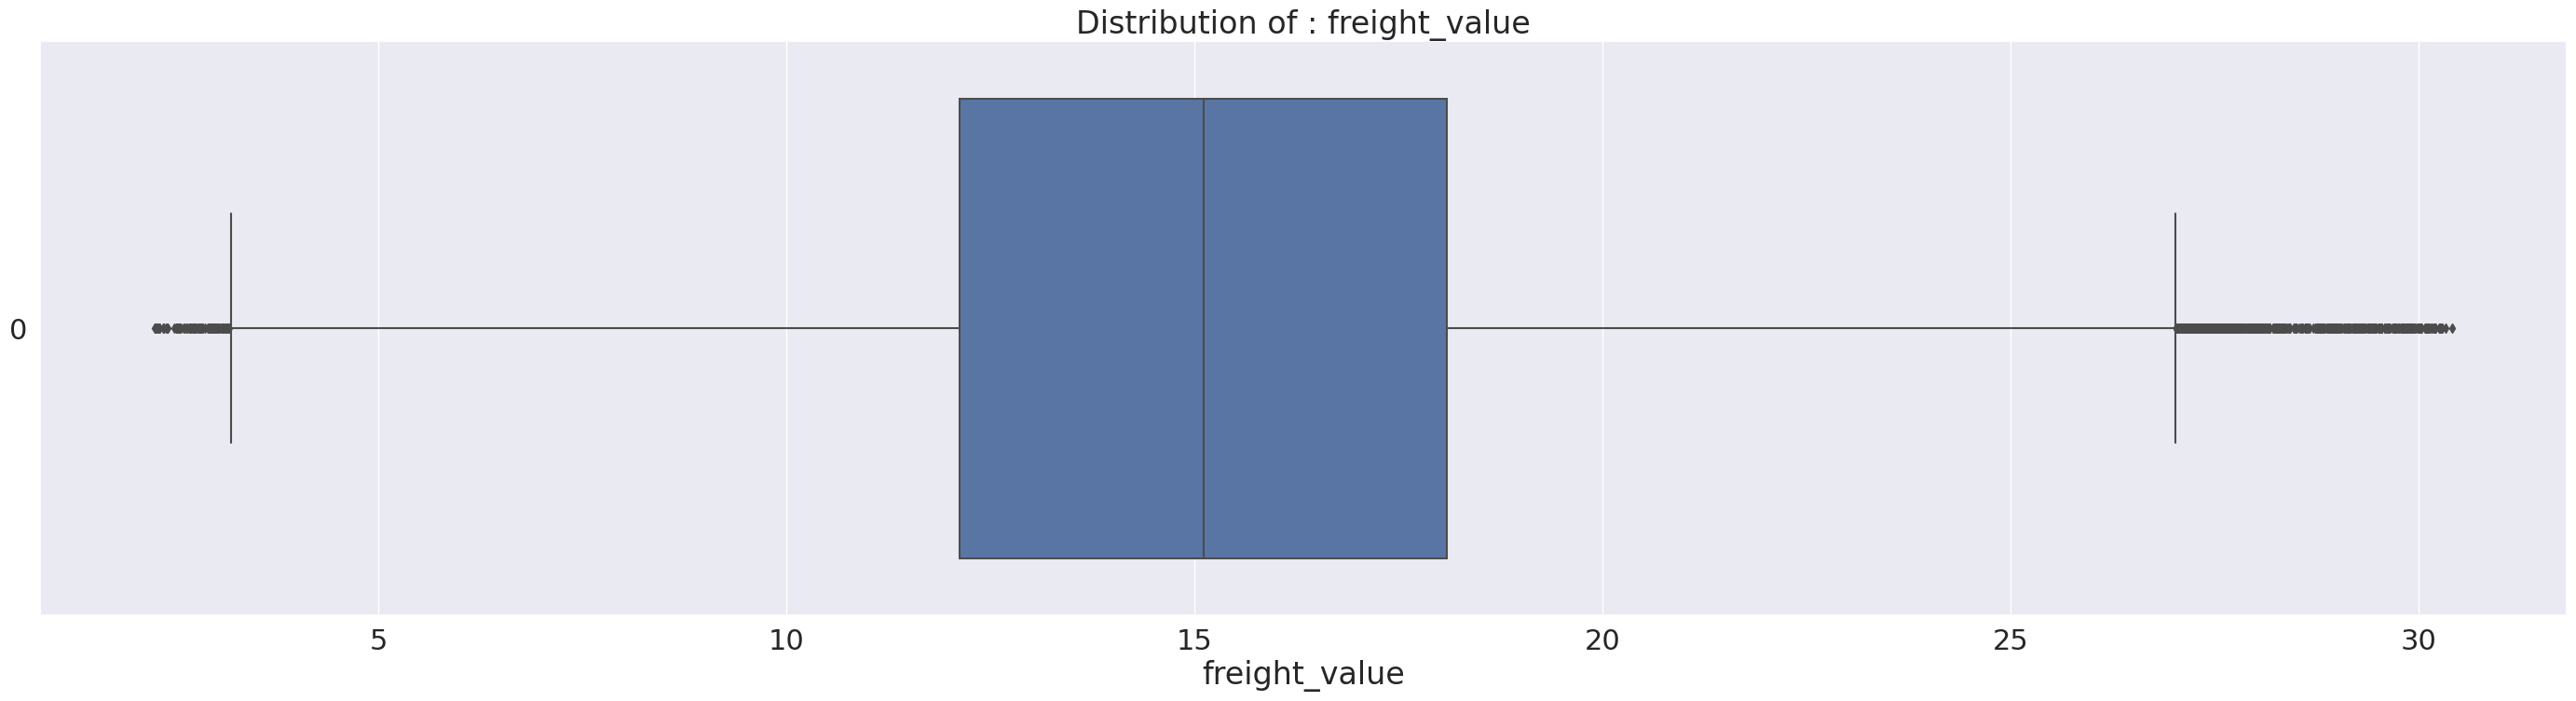

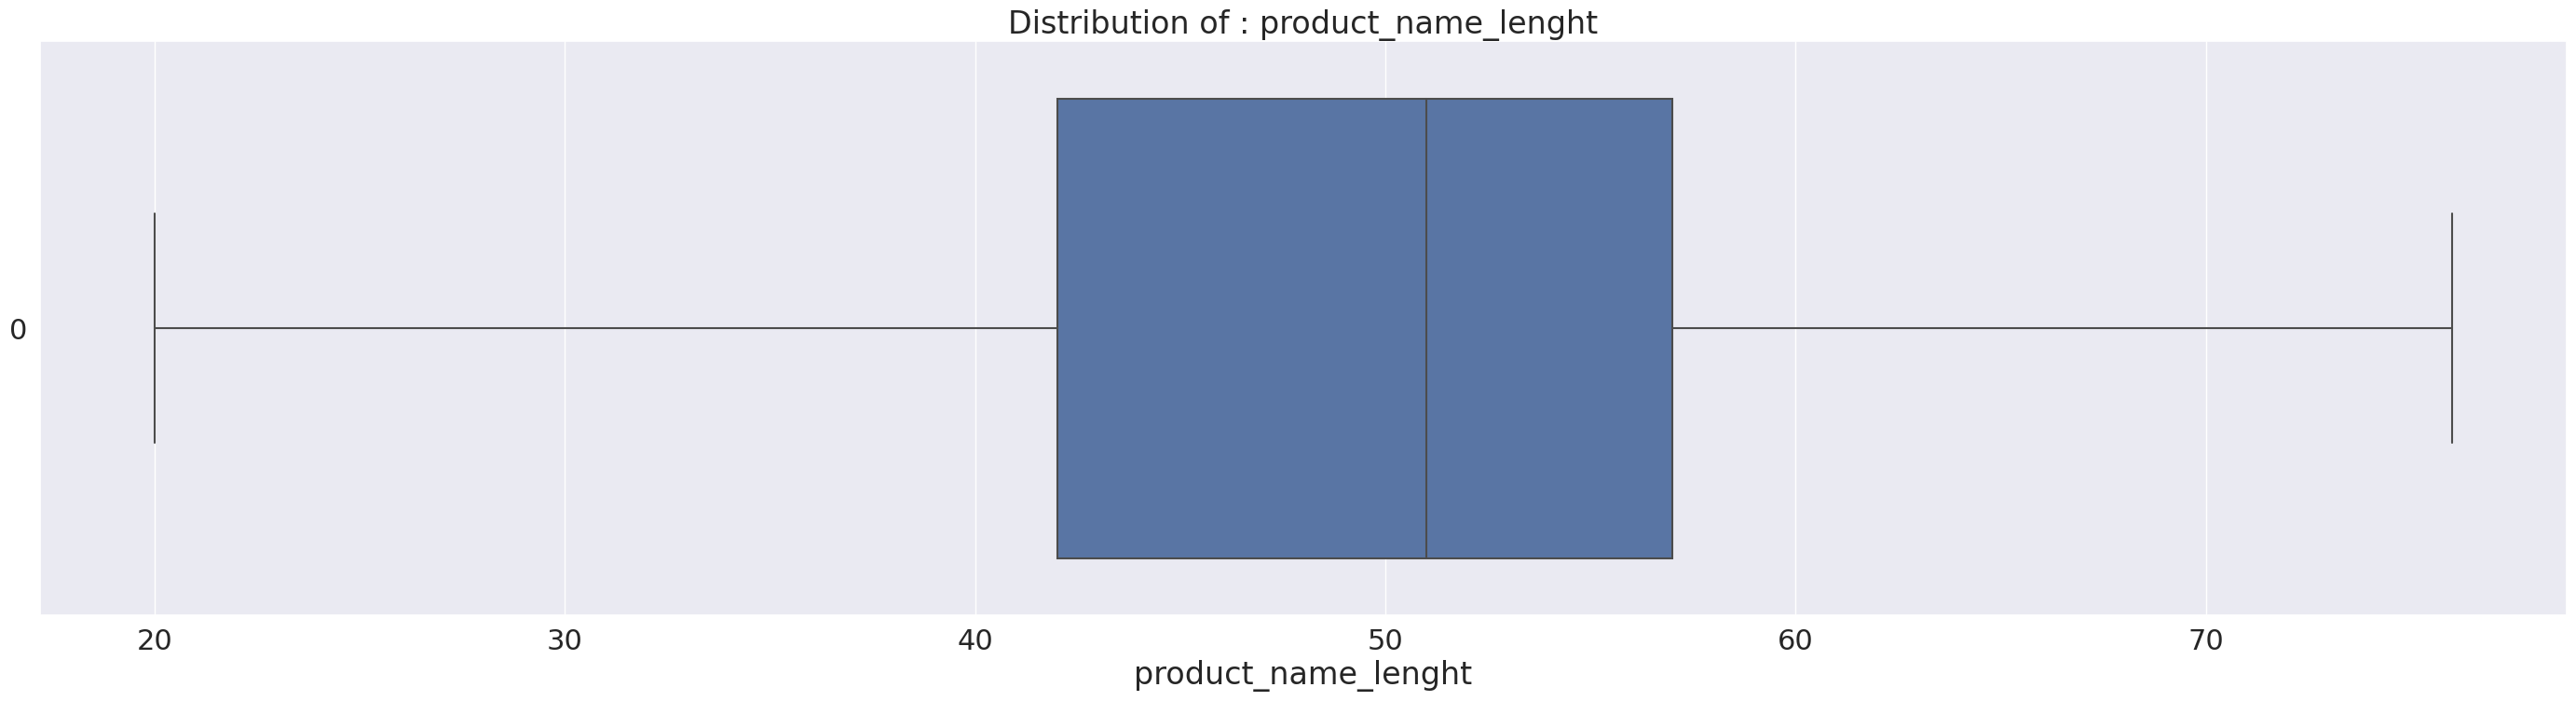

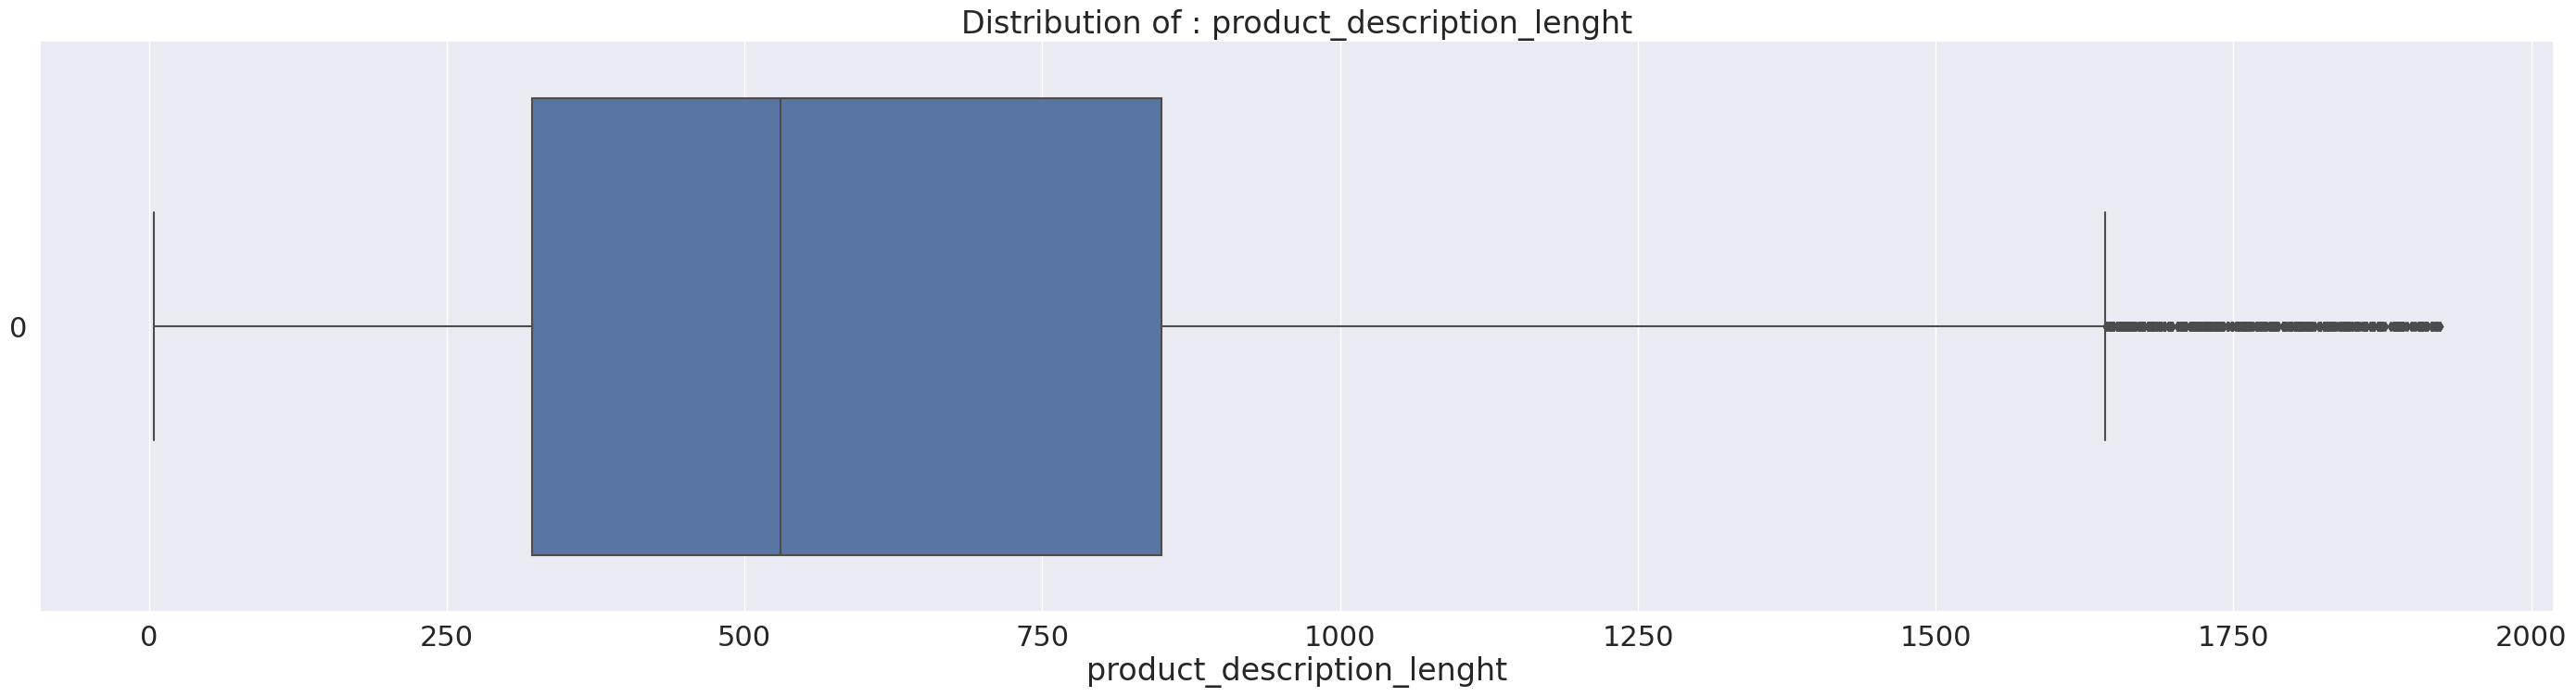

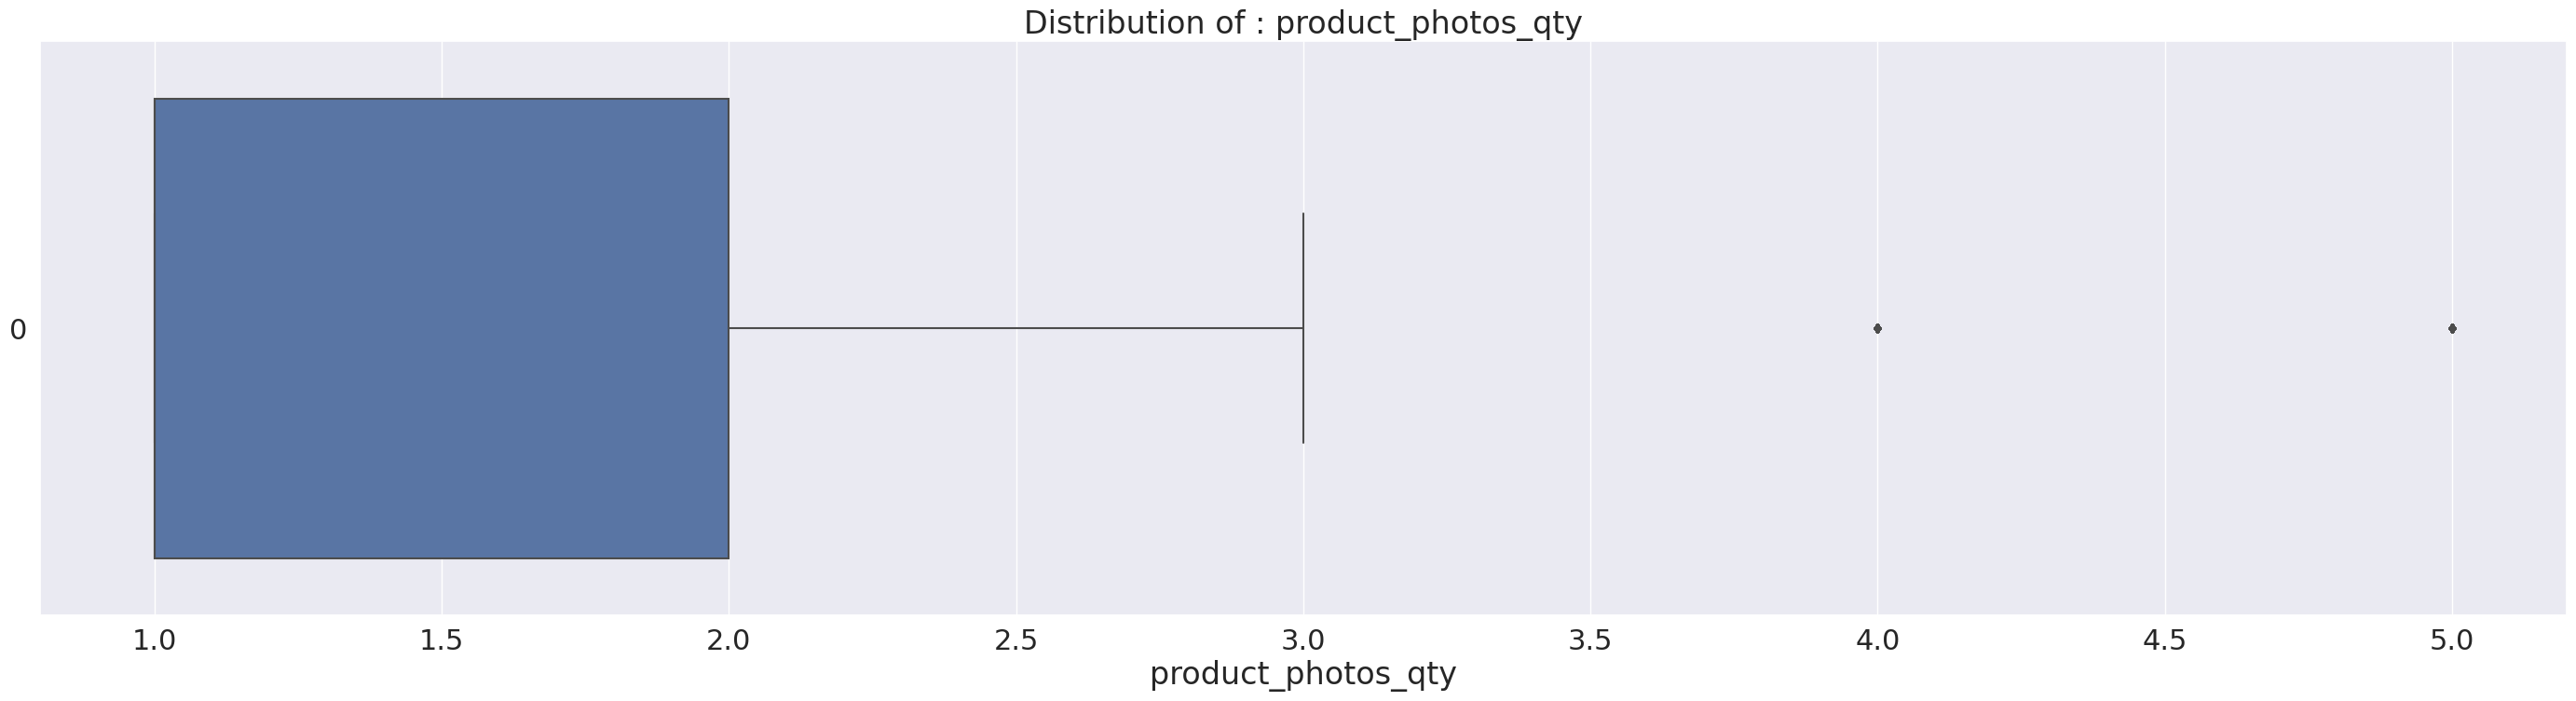

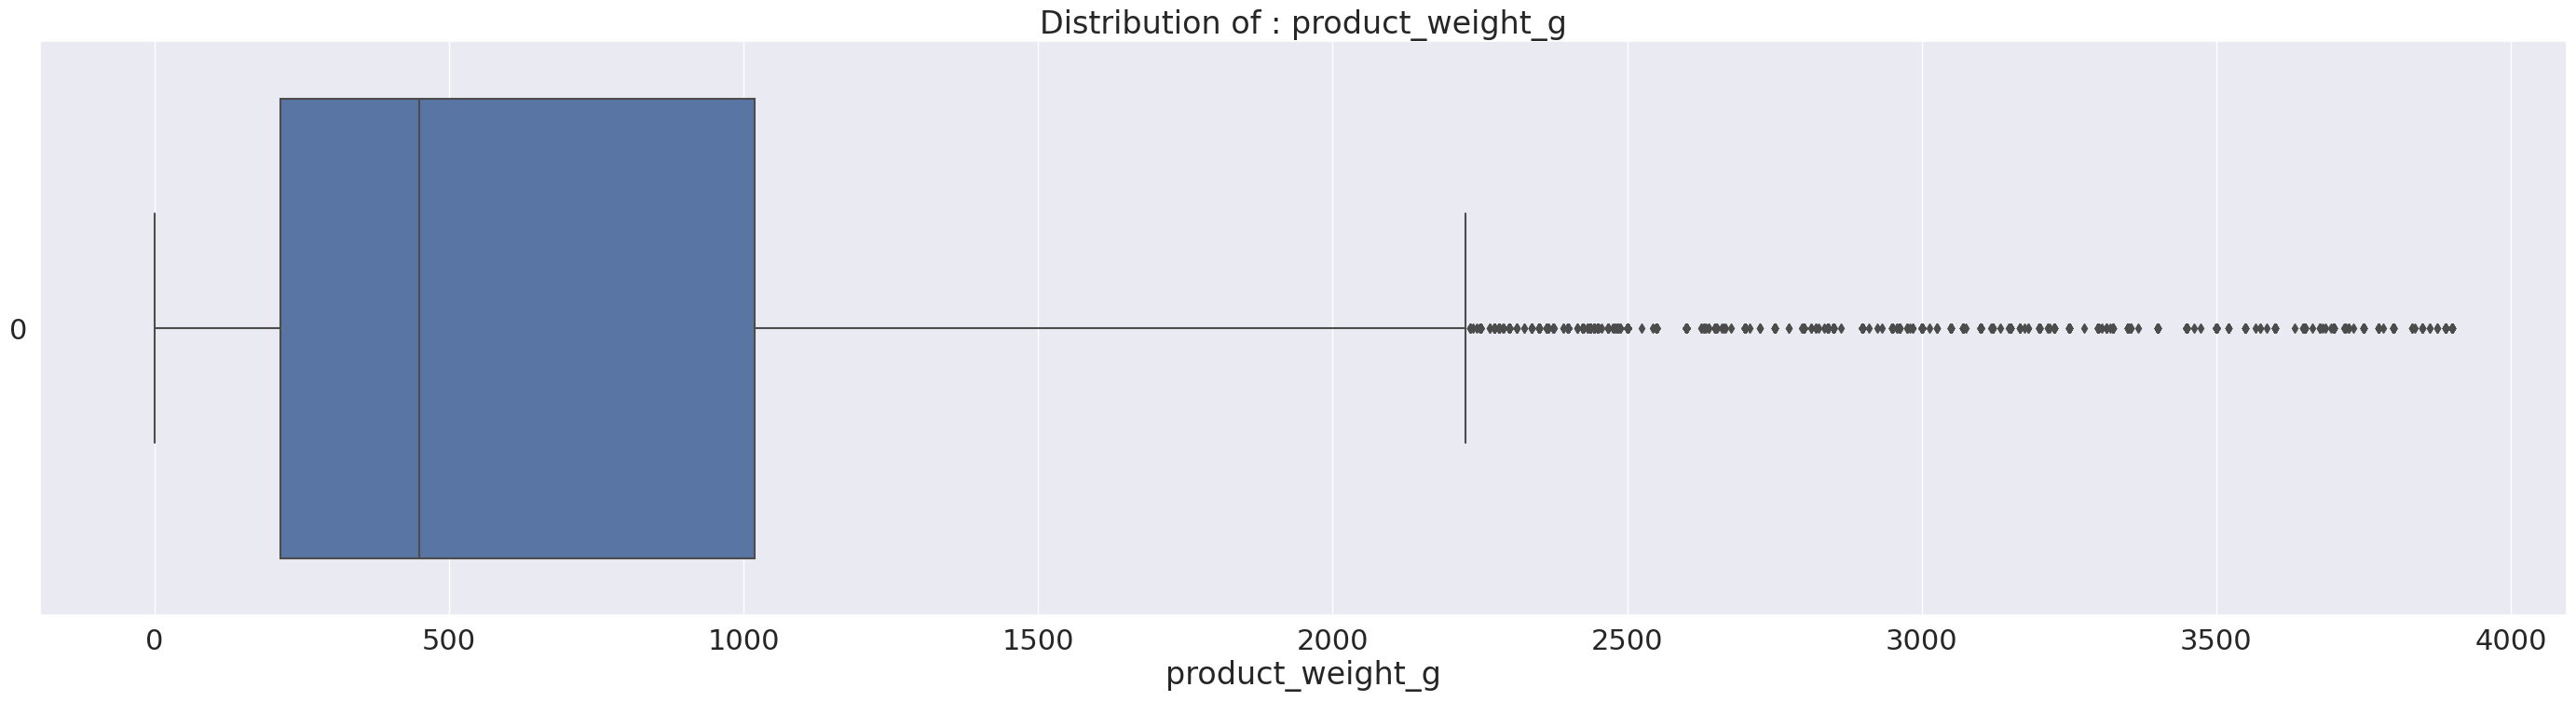

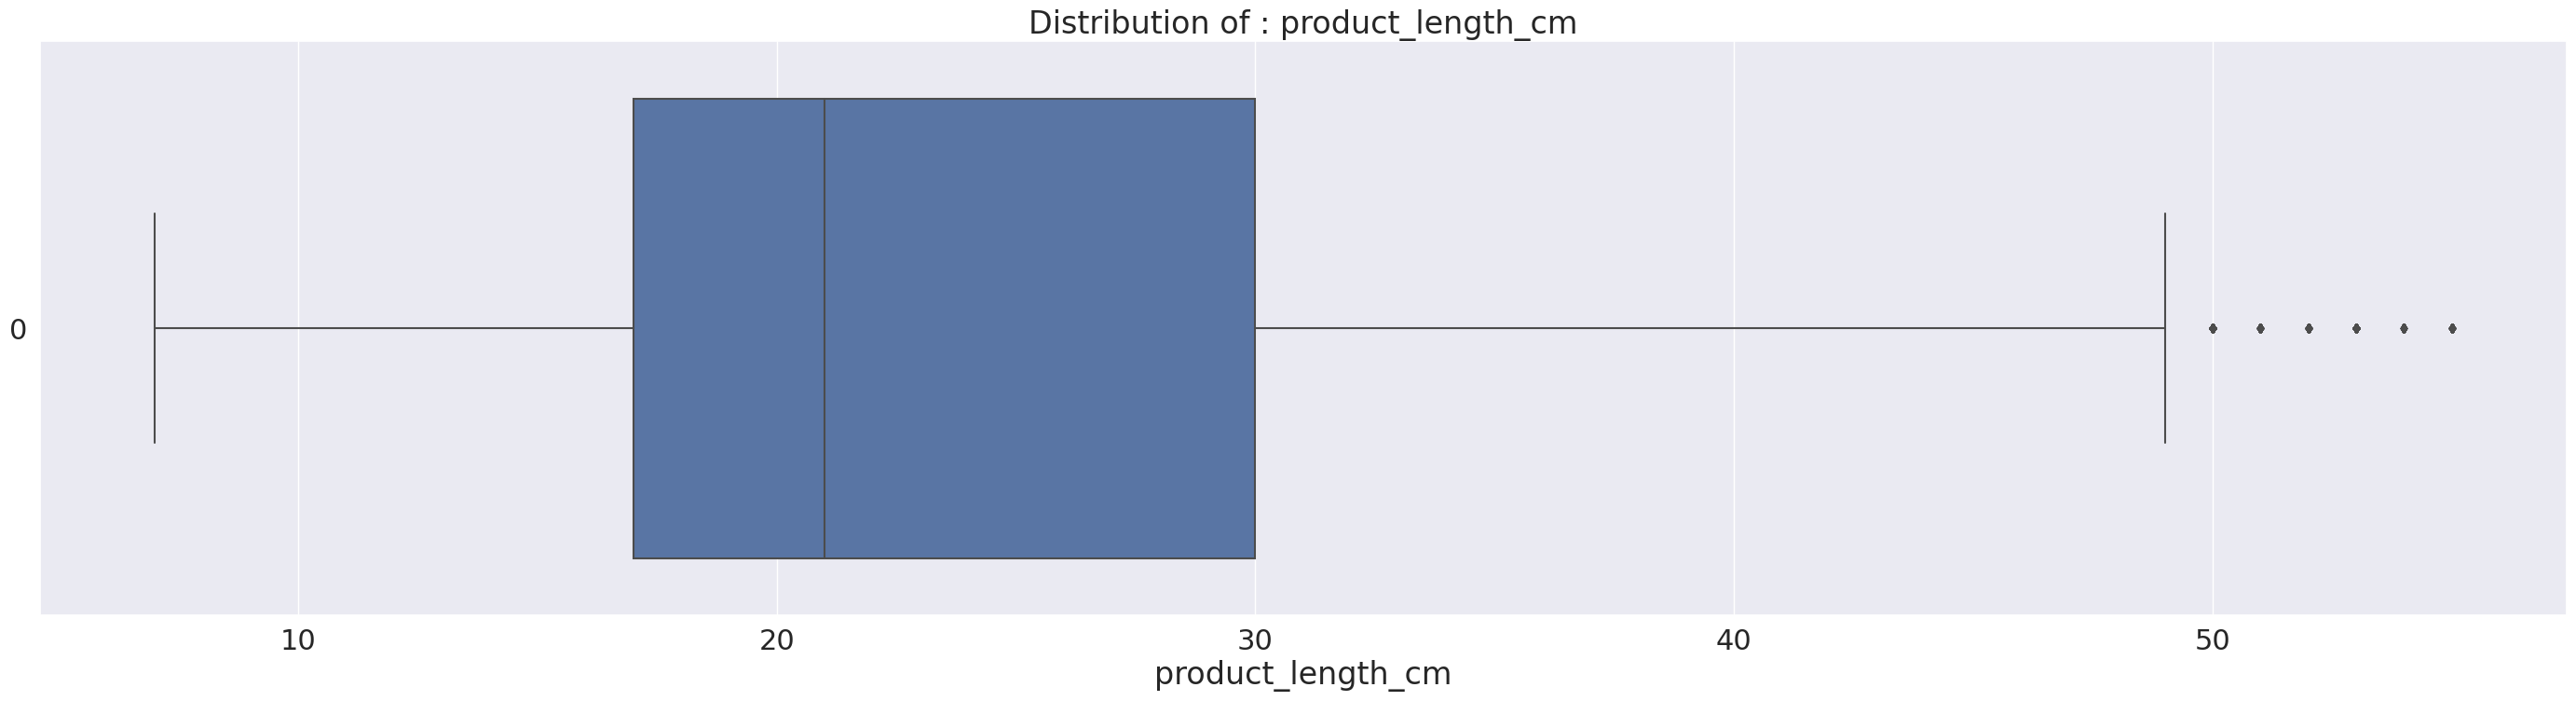

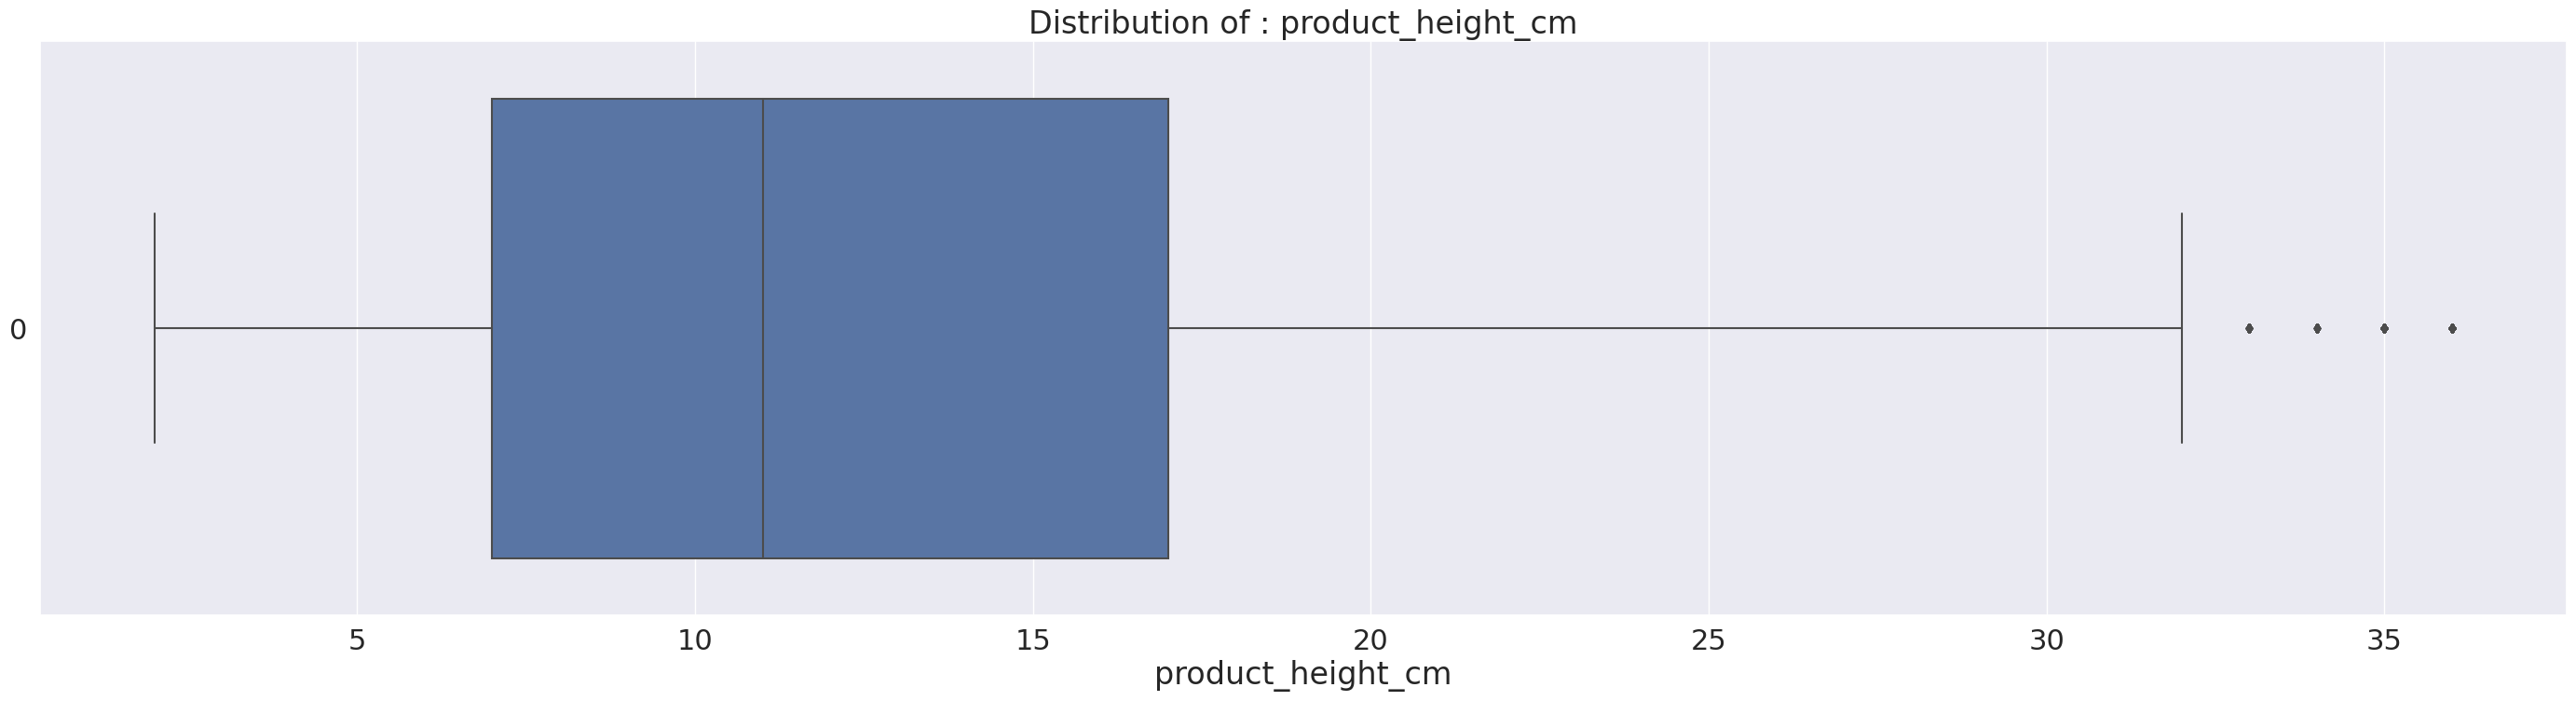

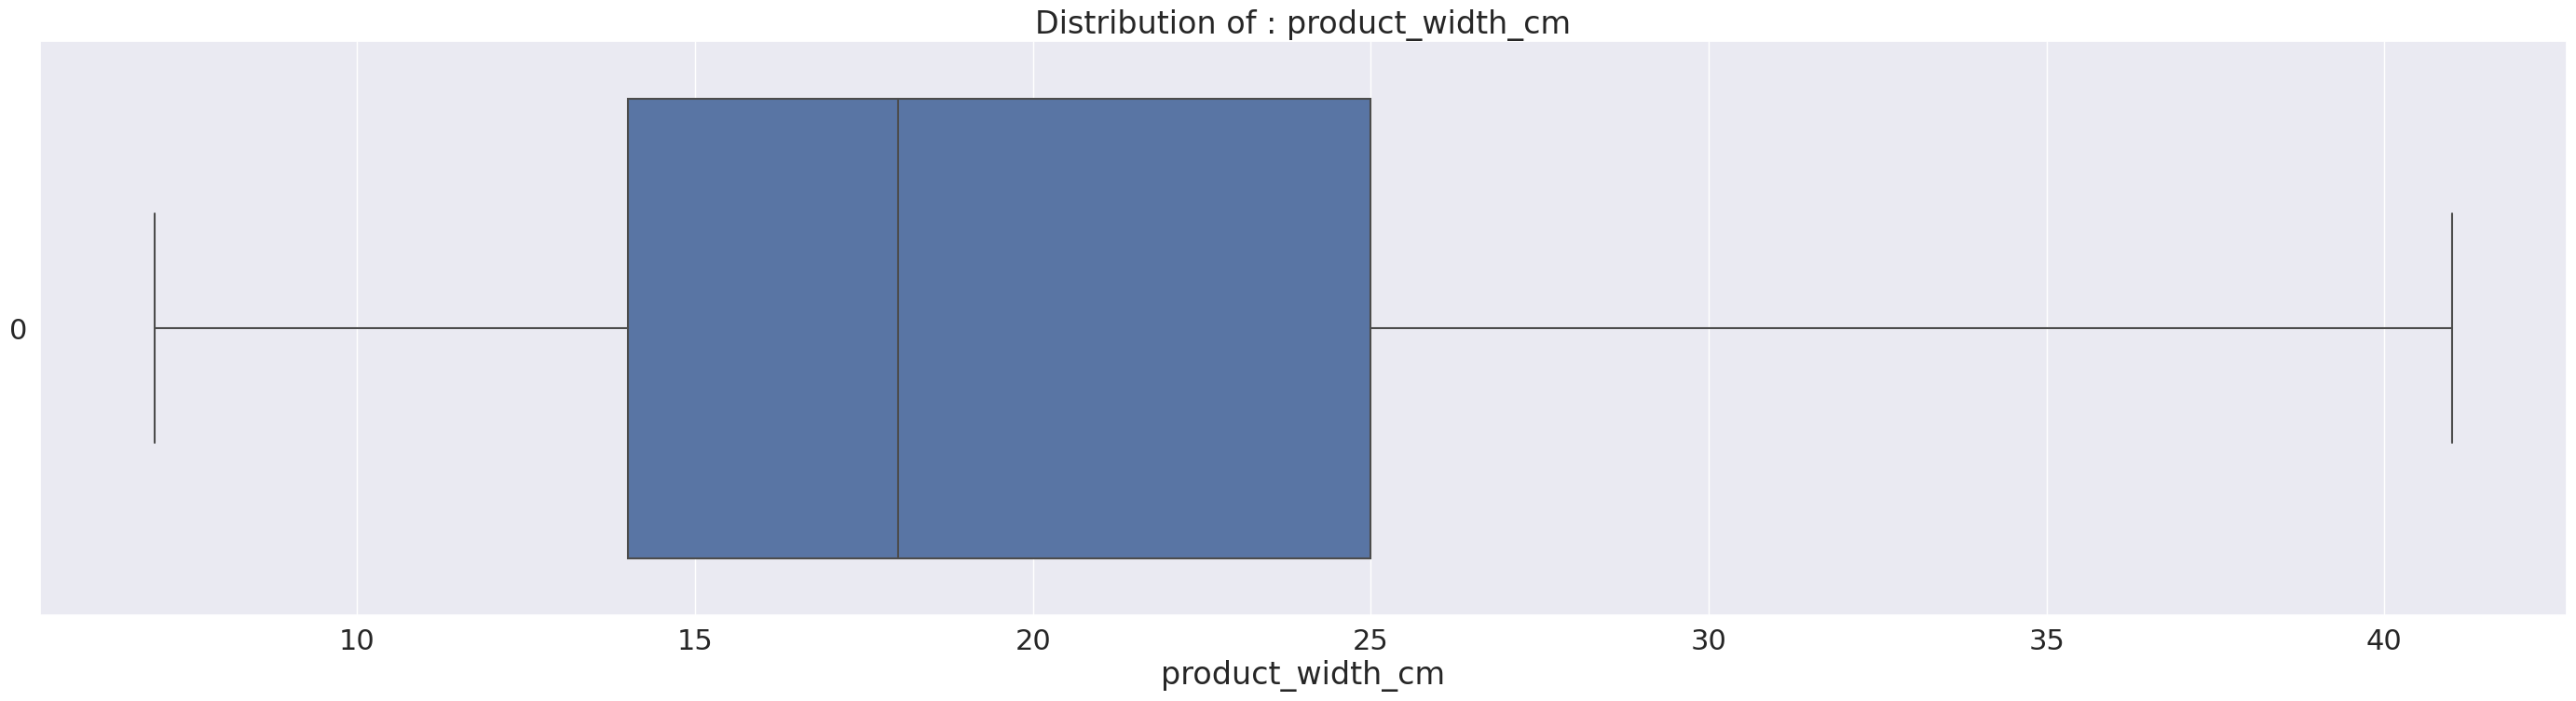

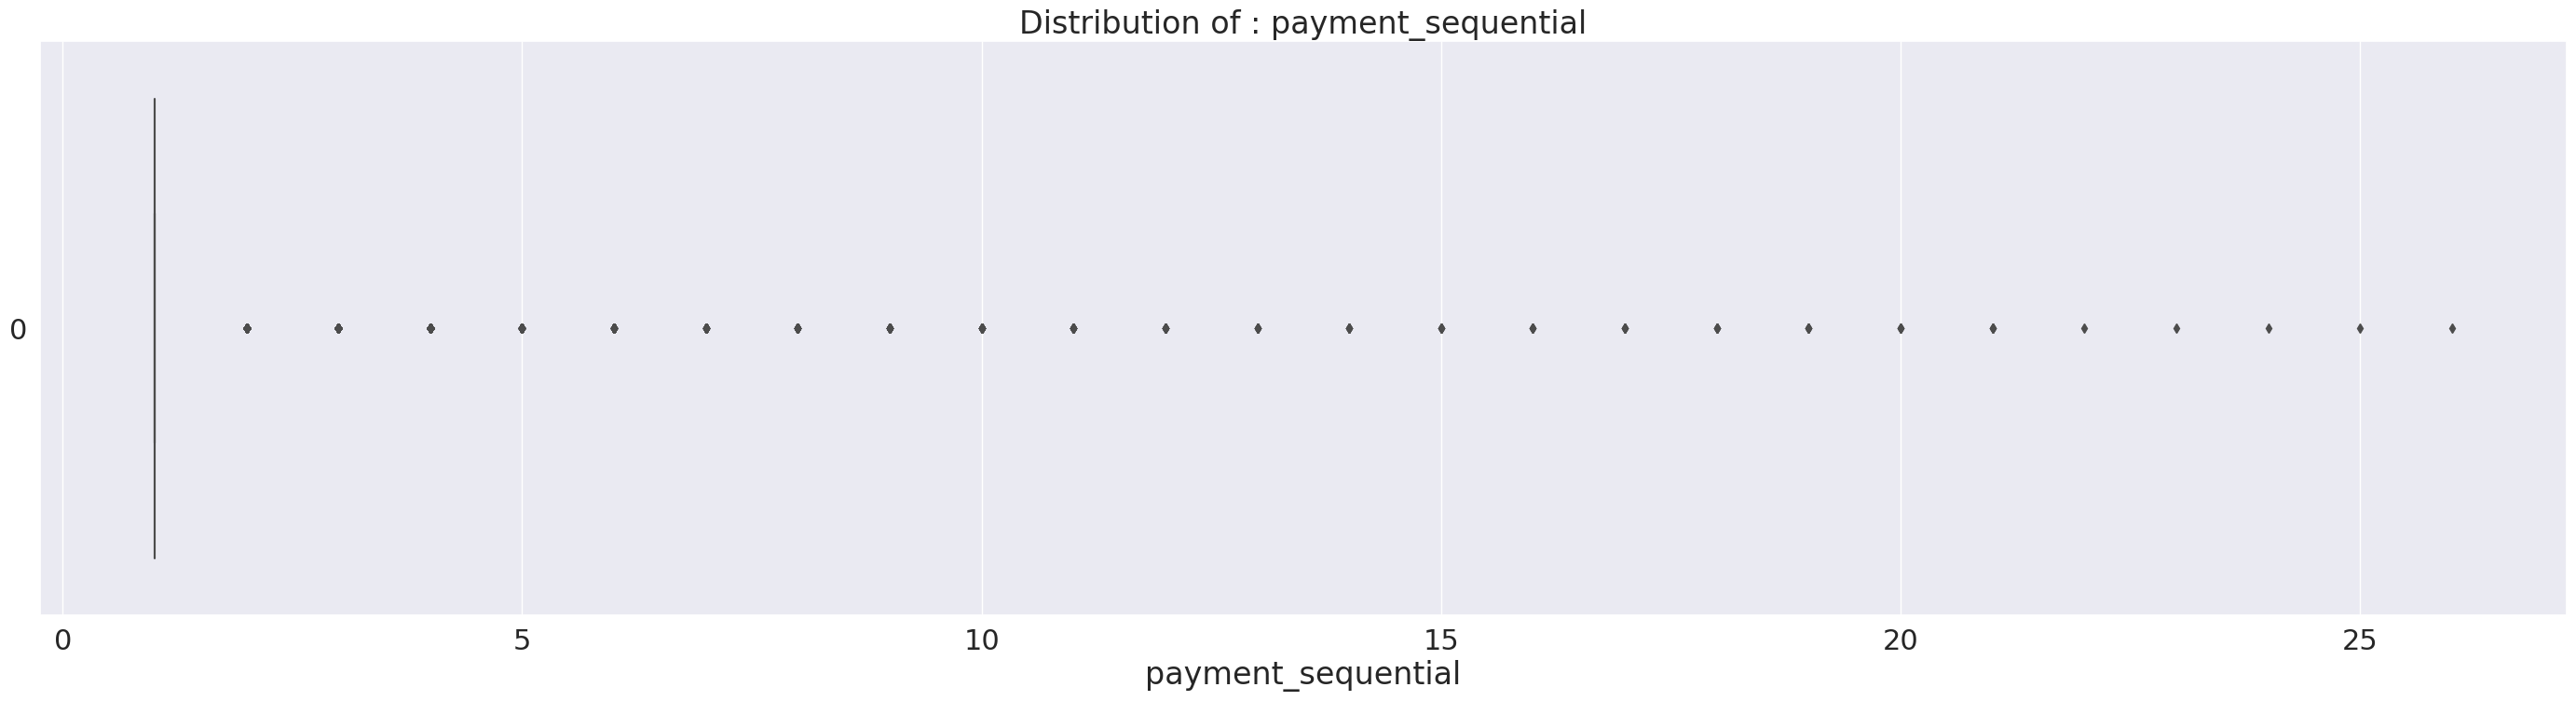

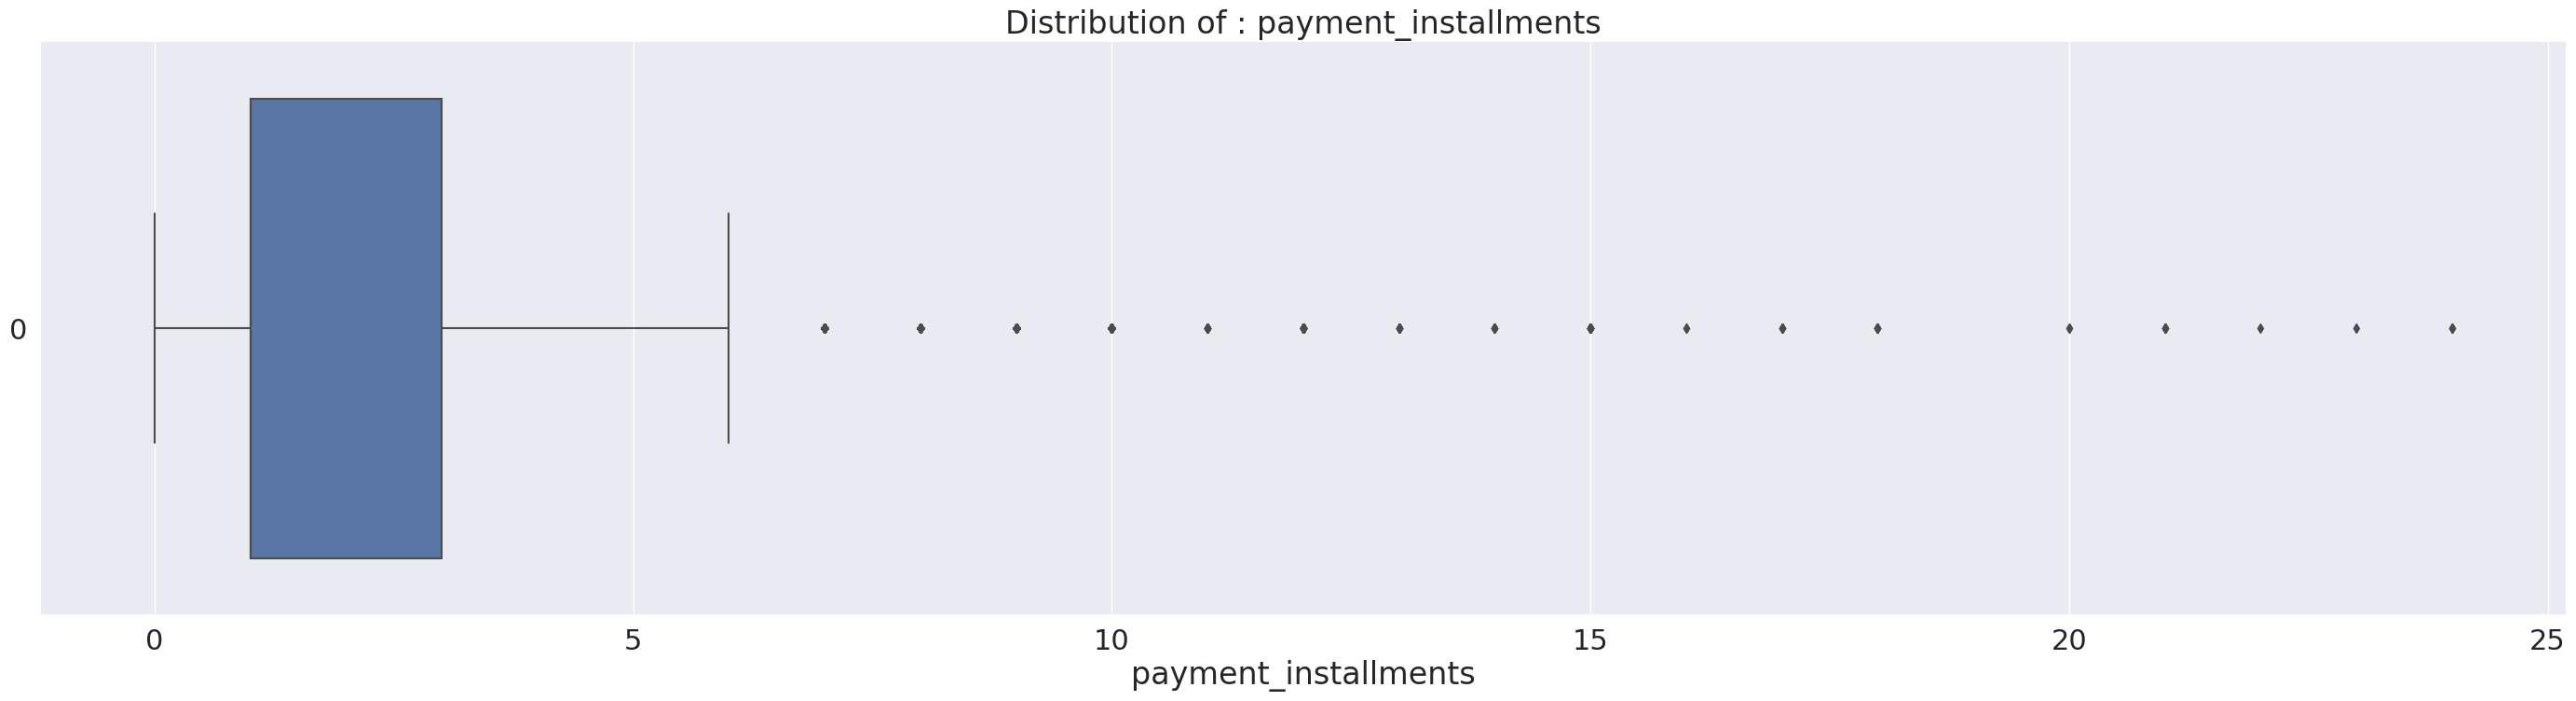

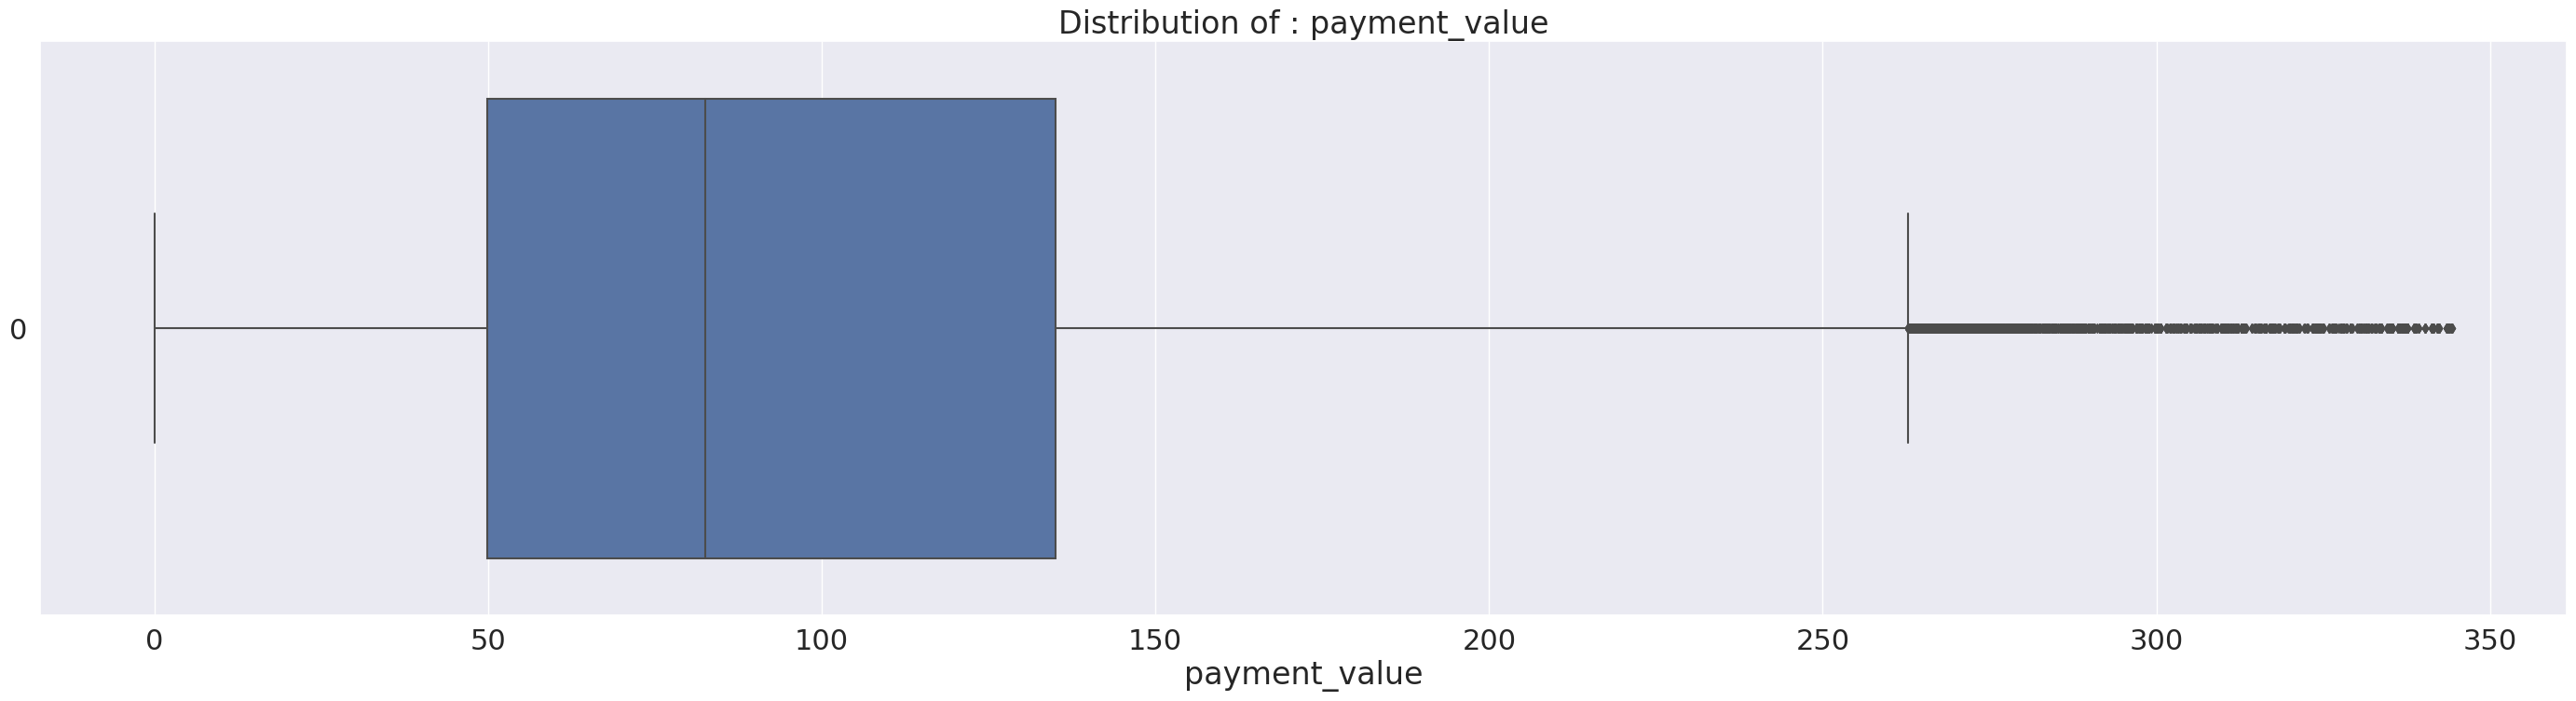

In [58]:
numeric_columns = client_data.select_dtypes(include = ['int32','float64']).columns
sns.set(font_scale=2)
for column in numeric_columns:
    if "date" in column or "zip_code" in column:
      continue
    plt.figure(figsize = (35,8))

    sns.boxplot(client_data[column], orient="h");
    chaine = 'Distribution of : ' + column
    plt.title(chaine);
    plt.xlabel(column);
    plt.show();
sns.set(font_scale=1)

## Creating new features using aggregations

In [59]:
client_data

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score
0,8a2e7ef9053dea531e4dc76bd6d853e6,64190b91b656ab8f37eb89b93dc84584,13380,nova odessa,SP,a548910a1c6147796b98fdf73dbeba33,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14,1.0,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-06 12:48:39,79.79,8.30,47.0,493.0,1.0,245.0,19.0,14.0,14.0,electronics,1.0,credit_card,1.0,88.09,5
1,840be0730010e9580efd289bc9f37706,dcd4940b3f96a3e2b73d8f73387230cf,8412,sao paulo,SP,e48aa0d2dcec3a2e87348811bcfdf22b,delivered,2017-06-30 15:38:46,2017-06-30 15:50:17,2017-07-03 16:22:53,2017-07-15 12:57:24,2017-08-03,1.0,3152a0c0d93abeec99e4a6169aecc88b,d2374cbcbb3ca4ab1086534108cc3ab7,2017-07-20 15:50:17,46.90,11.85,35.0,133.0,1.0,600.0,40.0,4.0,30.0,home,1.0,credit_card,2.0,58.75,5
2,daf813bc2e41c86027d086e8dfb35571,8c89391790076834500661cc1e5d6860,12316,jacarei,SP,9c214ac970e84273583ab523dfafd09b,delivered,2017-05-08 13:35:48,2017-05-08 13:50:15,2017-05-09 14:19:29,2017-05-16 16:49:51,2017-05-30,1.0,35afc973633aaeb6b877ff57b2793310,4a3ca9315b744ce9f8e9374361493884,2017-05-15 13:50:15,89.90,12.13,56.0,176.0,1.0,1825.0,53.0,10.0,40.0,home,1.0,credit_card,3.0,102.03,5
3,272b46feddddc51904608ddd90feee33,485fa1b8db05ed6fa0062ece4ce80d2e,35180,timoteo,MG,cdf9aa68e72324eeb25c7de974696ee2,delivered,2017-12-13 14:59:45,2017-12-13 15:07:23,2017-12-14 17:37:13,2017-12-22 12:49:55,2018-01-15,1.0,25e2023ed83352bde98dc1490d14c3d8,de23c3b98a88888289c6f5cc1209054a,2017-12-19 15:07:23,119.99,17.00,30.0,1024.0,1.0,887.0,30.0,22.0,20.0,arts,1.0,credit_card,1.0,136.99,5
4,8ebbeb09e94d1e789142983f73faa9cd,a5ee02c2d02b8929c0949fc114c5a19e,6700,cotia,SP,9d6f15f95d01e79bd1349cc208361f09,delivered,2018-02-12 16:07:34,2018-02-12 16:27:39,2018-02-14 20:04:16,2018-02-15 19:16:54,2018-02-26,1.0,acffe5d7cd56e6b564cf6841486644ff,db4350fd57ae30082dec7acbaacc17f9,2018-02-16 16:27:39,35.00,7.78,58.0,356.0,1.0,200.0,19.0,4.0,11.0,health_beauty,1.0,credit_card,2.0,42.78,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66686,486ce94ccf26c511ab93d31fefd5de0e,bc71d9dde7a14cf82eb4200b2a282131,35570,formiga,MG,acd45245723df7cb52772a34416b41b1,delivered,2018-04-19 19:44:47,2018-04-19 20:10:40,2018-04-20 22:24:23,2018-05-07 16:48:43,2018-05-10,1.0,30ccf4724f5227265f837e9ba0246278,dbc22125167c298ef99da25668e1011f,2018-04-25 20:10:40,79.60,15.41,52.0,573.0,1.0,1450.0,49.0,10.0,33.0,sports_leisure,1.0,credit_card,2.0,95.01,3
66687,3d7697c0971cb2606444adae322d8bb3,f4513d9cd4f25a8254176ceda0abdc5e,89835,sao domingos,SC,48f7ee67313eda32bfcf5b9c1dd9522d,delivered,2017-11-24 09:31:02,2017-11-24 09:39:31,2017-11-24 18:56:54,2017-12-12 23:21:52,2017-12-21,1.0,186fe07c8b8005ec6a498587ffbc1352,6560211a19b47992c3666cc44a7e94c0,2017-11-30 09:39:31,29.00,15.10,60.0,193.0,3.0,200.0,16.0,2.0,11.0,fashion,1.0,credit_card,1.0,44.10,5
66688,d0d7086dea6fcf42b9b690b9f3745c58,597cbb334f18a671472f7e16648228b4,22793,rio de janeiro,RJ,22ec9f0669f784db00fa86d035cf8602,delivered,2017-12-03 21:45:23,2017-12-03 22:08:00,2017-12-07 19:17:29,2017-12-08 17:19:00,2017-12-20,1.0,3a33c980b62eb1ef3b8ae61b6fc6fe55,46dc3b2cc0980fb8ec44634e21d2718e,2017-12-07 22:08:00,199.99,9.77,51.0,465.0,1.0,2363.0,23.0,27.0,19.0,arts,1.0,credit_card,1.0,209.76,5
66689,3aa00401736823c73e9fe8683328fa6b,96ac4cb74918d3ace141d3d3ddc1ff02,32667,betim,MG,7725825d039fc1f0ceb7635e3f7d9206,delivered,201

### Aggregations on customer id

In [60]:
# Get hours and purchase of weekday
client_data['order_purchase_hour'] = client_data['order_purchase_timestamp'].apply(lambda x: x.hour)
client_data['order_purchase_day'] = client_data['order_purchase_timestamp'].apply(lambda x: x.weekday())

In [61]:
# Delivery delay on ordered goods
client_data['delivery_delay'] = (client_data['order_delivered_customer_date'] - client_data['order_purchase_timestamp']).dt.days + 1

In [62]:
# Most used payment method and payment highest installments
client_data['preferred_payment_type'] = client_data.sort_values(['customer_id', 'payment_type', 'payment_installments'], ascending=False).groupby(['customer_id', 'payment_type', 'payment_installments']).head(1)[['payment_type']]

In [63]:
# Most number of installments per client
client_data['max_installments'] = client_data.sort_values(['customer_id', 'payment_type', 'payment_installments'], ascending=False).groupby(['customer_id', 'payment_type', 'payment_installments']).head(1)[['payment_installments']]

In [64]:
# Preferred product category
client_data['preferred_category'] = client_data.sort_values(['customer_id', 'product_category_name_english'], ascending=False).groupby(['customer_id', 'product_category_name_english']).head(1)[['product_category_name_english']]

In [65]:
# Number of products bought by clients
nb_products = client_data.groupby('customer_id')['product_id'].count()
nb_products.rename('nb_products', inplace=True)

customer_id
0001fd6190edaaf884bcaf3d49edf079    1
0002414f95344307404f0ace7a26f1d5    1
000379cdec625522490c315e70c7a9fb    1
0004164d20a9e969af783496f3408652    1
000419c5494106c306a97b5635748086    1
                                   ..
fffb97495f78be80e2759335275df2aa    1
fffecc9f79fd8c764f843e9951b11341    3
fffeda5b6d849fbd39689bb92087f431    1
ffff42319e9b2d713724ae527742af25    1
ffffa3172527f765de70084a7e53aae8    2
Name: nb_products, Length: 56791, dtype: int64

In [66]:
# Average money spent on products
avg_purchase_price = client_data.groupby('customer_id')['price'].mean()
avg_purchase_price.rename('avg_purchase_price', inplace=True)

customer_id
0001fd6190edaaf884bcaf3d49edf079    179.99
0002414f95344307404f0ace7a26f1d5    149.90
000379cdec625522490c315e70c7a9fb     93.00
0004164d20a9e969af783496f3408652     59.99
000419c5494106c306a97b5635748086     34.30
                                     ...  
fffb97495f78be80e2759335275df2aa     45.90
fffecc9f79fd8c764f843e9951b11341     54.90
fffeda5b6d849fbd39689bb92087f431     47.90
ffff42319e9b2d713724ae527742af25    199.90
ffffa3172527f765de70084a7e53aae8     10.90
Name: avg_purchase_price, Length: 56791, dtype: float64

In [67]:
# Most amount of money spent on a product
max_purchase_price = client_data.groupby('customer_id')['price'].max()
max_purchase_price.rename('max_purchase_price', inplace=True)

customer_id
0001fd6190edaaf884bcaf3d49edf079    179.99
0002414f95344307404f0ace7a26f1d5    149.90
000379cdec625522490c315e70c7a9fb     93.00
0004164d20a9e969af783496f3408652     59.99
000419c5494106c306a97b5635748086     34.30
                                     ...  
fffb97495f78be80e2759335275df2aa     45.90
fffecc9f79fd8c764f843e9951b11341     54.90
fffeda5b6d849fbd39689bb92087f431     47.90
ffff42319e9b2d713724ae527742af25    199.90
ffffa3172527f765de70084a7e53aae8     10.90
Name: max_purchase_price, Length: 56791, dtype: float64

In [68]:
# Average review score on a product
avg_review_score =client_data.groupby('customer_id')['review_score'].mean()
avg_review_score.rename('avg_review_score', inplace=True)

customer_id
0001fd6190edaaf884bcaf3d49edf079    5.0
0002414f95344307404f0ace7a26f1d5    5.0
000379cdec625522490c315e70c7a9fb    4.0
0004164d20a9e969af783496f3408652    1.0
000419c5494106c306a97b5635748086    1.0
                                   ... 
fffb97495f78be80e2759335275df2aa    5.0
fffecc9f79fd8c764f843e9951b11341    3.0
fffeda5b6d849fbd39689bb92087f431    4.0
ffff42319e9b2d713724ae527742af25    5.0
ffffa3172527f765de70084a7e53aae8    5.0
Name: avg_review_score, Length: 56791, dtype: float64

In [69]:
for df in [nb_products, avg_purchase_price, max_purchase_price, avg_review_score]:
  client_data = client_data.merge(df, how='left', on='customer_id')

In [70]:
client_data

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score,order_purchase_hour,order_purchase_day,delivery_delay,preferred_payment_type,max_installments,preferred_category,nb_products,avg_purchase_price,max_purchase_price,avg_review_score
0,8a2e7ef9053dea531e4dc76bd6d853e6,64190b91b656ab8f37eb89b93dc84584,13380,nova odessa,SP,a548910a1c6147796b98fdf73dbeba33,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14,1.0,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-06 12:48:39,79.79,8.30,47.0,493.0,1.0,245.0,19.0,14.0,14.0,electronics,1.0,credit_card,1.0,88.09,5,12,2,10,credit_card,1.0,electronics,1,79.79,79.79,5.0
1,840be0730010e9580efd289bc9f37706,dcd4940b3f96a3e2b73d8f73387230cf,8412,sao paulo,SP,e48aa0d2dcec3a2e87348811bcfdf22b,delivered,2017-06-30 15:38:46,2017-06-30 15:50:17,2017-07-03 16:22:53,2017-07-15 12:57:24,2017-08-03,1.0,3152a0c0d93abeec99e4a6169aecc88b,d2374cbcbb3ca4ab1086534108cc3ab7,2017-07-20 15:50:17,46.90,11.85,35.0,133.0,1.0,600.0,40.0,4.0,30.0,home,1.0,credit_card,2.0,58.75,5,15,4,15,credit_card,2.0,home,1,46.90,46.90,5.0
2,daf813bc2e41c86027d086e8dfb35571,8c89391790076834500661cc1e5d6860,12316,jacarei,SP,9c214ac970e84273583ab523dfafd09b,delivered,2017-05-08 13:35:48,2017-05-08 13:50:15,2017-05-09 14:19:29,2017-05-16 16:49:51,2017-05-30,1.0,35afc973633aaeb6b877ff57b2793310,4a3ca9315b744ce9f8e9374361493884,2017-05-15 13:50:15,89.90,12.13,56.0,176.0,1.0,1825.0,53.0,10.0,40.0,home,1.0,credit_card,3.0,102.03,5,13,0,9,credit_card,3.0,home,1,89.90,89.90,5.0
3,272b46feddddc51904608ddd90feee33,485fa1b8db05ed6fa0062ece4ce80d2e,35180,timoteo,MG,cdf9aa68e72324eeb25c7de974696ee2,delivered,2017-12-13 14:59:45,2017-12-13 15:07:23,2017-12-14 17:37:13,2017-12-22 12:49:55,2018-01-15,1.0,25e2023ed83352bde98dc1490d14c3d8,de23c3b98a88888289c6f5cc1209054a,2017-12-19 15:07:23,119.99,17.00,30.0,1024.0,1.0,887.0,30.0,22.0,20.0,arts,1.0,credit_card,1.0,136.99,5,14,2,9,credit_card,1.0,arts,1,119.99,119.99,5.0
4,8ebbeb09e94d1e789142983f73faa9cd,a5ee02c2d02b8929c0949fc114c5a19e,6700,cotia,SP,9d6f15f95d01e79bd1349cc208361f09,delivered,2018-02-12 16:07:34,2018-02-12 16:27:39,2018-02-14 20:04:16,2018-02-15 19:16:54,2018-02-26,1.0,acffe5d7cd56e6b564cf6841486644ff,db4350fd57ae30082dec7acbaacc17f9,2018-02-16 16:27:39,35.00,7.78,58.0,356.0,1.0,200.0,19.0,4.0,11.0,health_beauty,1.0,credit_card,2.0,42.78,4,16,0,4,credit_card,2.0,health_beauty,1,35.00,35.00,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66686,486ce94ccf26c511ab93d31fefd5de0e,bc71d9dde7a14cf82eb4200b2a282131,35570,formiga,MG,acd45245723df7cb52772a34416b41b1,delivered,2018-04-19 19:44:47,2018-04-19 20:10:40,2018-04-20 22:24:23,2018-05-07 16:48:43,2018-05-10,1.0,30ccf4724f5227265f837e9ba0246278,dbc22125167c298ef99da25668e1011f,2018-04-25 20:10:40,79.60,15.41,52.0,573.0,1.0,1450.0,49.0,10.0,33.0,sports_leisure,1.0,credit_card,2.0,95.01,3,19,3,18,credit_card,2.0,sports_leisure,1,79.60,79.60,3.0
66687,3d7697c0971cb2606444adae322d8bb3,f4513d9cd4f25a8254176ceda0abdc5e,89835,sao domingos,SC,48f7ee67313eda32bfcf5b9c1dd9522d,delivered,2017-11-24 09:31:02,2017-11-24 09:39:31,2017-11-24 18:56:54,2017-12-12 23:21:52,2017-12-21,1.0,186fe07c8b8005ec6a498587ffbc1352,6560211a19b47992c3666cc44a7e94c0,2017-11-30 09:39:31,29.00,15.10,60.0,193.0,3.0,200.0,16.0,2.0,11.0,fashion,1.0,credit_card,1.0,44.10,5,9,4,19,cr

### Concatenating geolocation dataset

In [71]:
geolocalisation

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000155,99965,-28.180655,-52.034367,agua santa,RS
1000156,99950,-28.072188,-52.011272,tapejara,RS
1000157,99950,-28.068864,-52.012964,tapejara,RS
1000158,99950,-28.068639,-52.010705,tapejara,RS


In [72]:
# average out latitues and longitudes
geolocalisation['geolocation_lat_mean'] = geolocalisation.groupby('geolocation_zip_code_prefix')['geolocation_lat'].transform('mean')
geolocalisation['geolocation_lng_mean'] = geolocalisation.groupby('geolocation_zip_code_prefix')['geolocation_lng'].transform('mean')

In [73]:
geolocalisation = geolocalisation.drop(columns=['geolocation_lat', 'geolocation_lng'])

# Droping duplicates rows (same zip code)
geolocalisation = geolocalisation.drop_duplicates(subset='geolocation_zip_code_prefix')

In [74]:
## Check joining
def joining_check(left_df, right_df, left_key, right_key):
    '''This function checks the keys before a joining of DataFrames.'''

    # Checking the shape before joining
    left_set = set(left_df[left_key].unique())
    right_set = set(right_df[right_key].unique())

    # Display some results
    nb_shared_keys = len(left_set & right_set)  # set intersection
    print("Number of shared values of keys between left_df and right_df: {}"
          .format(nb_shared_keys))

    nb_left_specific_keys = len(left_set - right_set)  # sets difference
    print("Number of specifique values of key '{}' for left_df: {}"
          .format(left_key, nb_left_specific_keys))

    nb_right_specific_keys = len(right_set - left_set)  # sets difference
    print("Number of specifique values of key '{}' for right_df: {}"
          .format(left_key, nb_right_specific_keys))

    # Number of rows in left_df with one of the specific values of key
    mask = (left_df[left_key].isin(left_set - right_set))
    nb_left_rows_w_specific_keys = len(left_df[mask])
    print("Number of rows in left_df with a specific value of key: {}"
          .format(nb_left_rows_w_specific_keys))

    # Print a few rows to illustrate the case of specific values on left
    if nb_left_rows_w_specific_keys > 0:
        display(left_df[mask].head())

In [75]:
joining_check(client_data, geolocalisation, 'customer_zip_code_prefix', 'geolocation_zip_code_prefix')

Number of shared values of keys between left_df and right_df: 9967
Number of specifique values of key 'customer_zip_code_prefix' for left_df: 2660
Number of specifique values of key 'customer_zip_code_prefix' for right_df: 3213
Number of rows in left_df with a specific value of key: 8748


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score,order_purchase_hour,order_purchase_day,delivery_delay,preferred_payment_type,max_installments,preferred_category,nb_products,avg_purchase_price,max_purchase_price,avg_review_score
5,9d53af6298240d4573ca6e52bcfa6c63,b110d5017bf181177474511359c81f46,45208,jequie,BA,2eaf8e099d871cd5c22b83b5ea8f6e0e,delivered,2018-03-21 11:22:23,2018-03-21 11:35:27,2018-03-22 19:38:40,2018-03-28 02:11:10,2018-04-11,1.0,51afee91e441387a77e232e59c3d6135,0df3984f9dfb3d49ac6366acbd3bbb85,2018-03-27 11:35:27,24.90,22.06,43.0,810.0,1.0,175.0,19.0,7.0,12.0,health_beauty,1.0,credit_card,1.0,46.96,4,11,2,7,credit_card,1.0,health_beauty,1,24.90,24.90,4.0
25,3fecd6727aed19735e06945b7c3e49c9,f51a647a551b866c440921b7f2b5683f,41230,salvador,BA,37e7875cdce5a9e5b3a692971f370151,delivered,2018-05-18 12:15:11,2018-05-18 13:05:53,2018-05-21 16:13:00,2018-06-06 18:22:40,2018-06-14,1.0,a76bb75d78ce6aa4a5202051b4f88a83,bd15ee794d5e640d9dd71b665b2ab15b,2018-05-24 13:05:53,34.90,22.06,52.0,460.0,2.0,300.0,19.0,12.0,16.0,sports_leisure,1.0,credit_card,1.0,56.96,4,12,4,20,credit_card,1.0,sports_leisure,1,34.90,34.90,4.0
32,deb1ce7ca68ee64461402e881a1c02ae,bb1768775784cf4511ec7c6f40f86ca3,73369,brasilia,DF,82c5edeff15e09a0460d292874766132,delivered,2017-09-13 17:44:20,2017-09-13 17:55:30,2017-09-14 17:55:29,2017-09-21 19:25:03,2017-10-04,1.0,22ca1399dde9714934f8ec09b6aca2fe,128f9bfbe4c7d5185033914b1de3d39a,2017-09-20 17:55:30,94.00,17.91,55.0,782.0,1.0,1650.0,31.0,26.0,29.0,health_beauty,1.0,credit_card,8.0,111.91,5,17,2,9,credit_card,8.0,health_beauty,1,94.00,94.00,5.0
37,bc30c70a15ad83ce13b6247e96f2dbd8,172e5ceb39fc662dc3cd66286385e91c,91520,porto alegre,RS,32638fbca8d1a197e649fd5138e12049,delivered,2017-05-24 17:01:03,2017-05-24 17:10:16,2017-05-26 14:41:33,2017-06-01 12:58:18,2017-06-20,1.0,d487634085fb3d1a632265c1e3de08c1,582d4f8675b945722eda7c0cb61ba4c7,2017-05-30 17:10:16,22.90,8.40,27.0,271.0,2.0,600.0,22.0,4.0,13.0,garden_pets,1.0,credit_card,1.0,336.86,5,17,2,8,credit_card,1.0,garden_pets,1,22.90,22.90,5.0
58,e57a1ac4317d4acd397f88cdb8b086aa,f981f711c80dcdb9d13a23a2391aa088,76410,campinorte,GO,248907ae8054cb8e93d5aa44857779b4,delivered,2017-12-17 05:25:12,2017-12-17 05:36:22,2017-12-19 23:34:32,2018-01-03 22:41:27,2018-01-17,1.0,74ae869eb82594d9cbe6e934cf143e0c,ea8482cd71df3c1969d7b9473ff13abc,2017-12-21 05:36:22,29.99,15.10,60.0,751.0,3.0,150.0,17.0,4.0,12.0,electronics,1.0,credit_card,1.0,45.09,5,5,6,18,credit_card,1.0,electronics,1,29.99,29.99,5.0


In [76]:
client_data_final = pd.merge(client_data, geolocalisation, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')

In [77]:
client_data = client_data_final

In [78]:
client_data

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score,order_purchase_hour,order_purchase_day,delivery_delay,preferred_payment_type,max_installments,preferred_category,nb_products,avg_purchase_price,max_purchase_price,avg_review_score,geolocation_zip_code_prefix,geolocation_city,geolocation_state,geolocation_lat_mean,geolocation_lng_mean
0,8a2e7ef9053dea531e4dc76bd6d853e6,64190b91b656ab8f37eb89b93dc84584,13380,nova odessa,SP,a548910a1c6147796b98fdf73dbeba33,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14,1.0,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-06 12:48:39,79.79,8.30,47.0,493.0,1.0,245.0,19.0,14.0,14.0,electronics,1.0,credit_card,1.0,88.09,5,12,2,10,credit_card,1.0,electronics,1,79.79,79.79,5.0,13380.0,nova odessa,SP,-22.785055,-47.310387
1,840be0730010e9580efd289bc9f37706,dcd4940b3f96a3e2b73d8f73387230cf,8412,sao paulo,SP,e48aa0d2dcec3a2e87348811bcfdf22b,delivered,2017-06-30 15:38:46,2017-06-30 15:50:17,2017-07-03 16:22:53,2017-07-15 12:57:24,2017-08-03,1.0,3152a0c0d93abeec99e4a6169aecc88b,d2374cbcbb3ca4ab1086534108cc3ab7,2017-07-20 15:50:17,46.90,11.85,35.0,133.0,1.0,600.0,40.0,4.0,30.0,home,1.0,credit_card,2.0,58.75,5,15,4,15,credit_card,2.0,home,1,46.90,46.90,5.0,8412.0,sao paulo,SP,-23.552130,-46.408054
2,daf813bc2e41c86027d086e8dfb35571,8c89391790076834500661cc1e5d6860,12316,jacarei,SP,9c214ac970e84273583ab523dfafd09b,delivered,2017-05-08 13:35:48,2017-05-08 13:50:15,2017-05-09 14:19:29,2017-05-16 16:49:51,2017-05-30,1.0,35afc973633aaeb6b877ff57b2793310,4a3ca9315b744ce9f8e9374361493884,2017-05-15 13:50:15,89.90,12.13,56.0,176.0,1.0,1825.0,53.0,10.0,40.0,home,1.0,credit_card,3.0,102.03,5,13,0,9,credit_card,3.0,home,1,89.90,89.90,5.0,12316.0,jacareí,SP,-23.316881,-45.940390
3,272b46feddddc51904608ddd90feee33,485fa1b8db05ed6fa0062ece4ce80d2e,35180,timoteo,MG,cdf9aa68e72324eeb25c7de974696ee2,delivered,2017-12-13 14:59:45,2017-12-13 15:07:23,2017-12-14 17:37:13,2017-12-22 12:49:55,2018-01-15,1.0,25e2023ed83352bde98dc1490d14c3d8,de23c3b98a88888289c6f5cc1209054a,2017-12-19 15:07:23,119.99,17.00,30.0,1024.0,1.0,887.0,30.0,22.0,20.0,arts,1.0,credit_card,1.0,136.99,5,14,2,9,credit_card,1.0,arts,1,119.99,119.99,5.0,35180.0,timoteo,MG,-19.545863,-42.643543
4,8ebbeb09e94d1e789142983f73faa9cd,a5ee02c2d02b8929c0949fc114c5a19e,6700,cotia,SP,9d6f15f95d01e79bd1349cc208361f09,delivered,2018-02-12 16:07:34,2018-02-12 16:27:39,2018-02-14 20:04:16,2018-02-15 19:16:54,2018-02-26,1.0,acffe5d7cd56e6b564cf6841486644ff,db4350fd57ae30082dec7acbaacc17f9,2018-02-16 16:27:39,35.00,7.78,58.0,356.0,1.0,200.0,19.0,4.0,11.0,health_beauty,1.0,credit_card,2.0,42.78,4,16,0,4,credit_card,2.0,health_beauty,1,35.00,35.00,4.0,6700.0,cotia,SP,-23.609193,-46.934942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66686,486ce94ccf26c511ab93d31fefd5de0e,bc71d9dde7a14cf82eb4200b2a282131,35570,formiga,MG,acd45245723df7cb52772a34416b41b1,delivered,2018-04-19 19:44:47,2018-04-19 20:10:40,2018-04-20 22:24:23,2018-05-07 16:48:43,2018-05-10,1.0,30ccf4724f5227265f837e9ba0246278,dbc22125167c298ef99da25668e1011f,2018-04-25 20:10:40,79.60,15.41,52.0,573.0,1.0,1450.0,49.0,10.0,33.0,sports_leisure,1.0,credit_card,2.0,95.01,3,19,3,18,credit_card,2.0,sports_leisure,1,79.60,79.60,3.0,35570.0,formiga,MG,-20.462186,-45.433273
66687,3d7697c0971cb2606444adae322d8bb

### RFM analysis

In [79]:
df_recency = client_data.groupby(by='customer_id',
                        as_index=False)['order_purchase_timestamp'].max()
df_recency.columns = ['customer_id', 'last_purchase_date']
recent_date = df_recency['last_purchase_date'].max()
df_recency['recency'] = df_recency['last_purchase_date'].apply(
    lambda x: (recent_date - x).days)
df_recency.head()

,customer_id,last_purchase_date,recency
0,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,547
1,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,378
2,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,149
3,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,504
4,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,179


In [80]:
frequency_df = client_data.drop_duplicates().groupby(
    by=['customer_id'], as_index=False)['order_purchase_timestamp'].count()
frequency_df.columns = ['customer_id', 'frequency']
frequency_df.head()

,customer_id,frequency
0,0001fd6190edaaf884bcaf3d49edf079,1
1,0002414f95344307404f0ace7a26f1d5,1
2,000379cdec625522490c315e70c7a9fb,1
3,0004164d20a9e969af783496f3408652,1
4,000419c5494106c306a97b5635748086,1


In [81]:
monetary_df = client_data.groupby(by='customer_id', as_index=False)['payment_value'].sum()
monetary_df.columns = ['customer_id', 'monetary']
monetary_df.head()

,customer_id,monetary
0,0001fd6190edaaf884bcaf3d49edf079,195.42
1,0002414f95344307404f0ace7a26f1d5,179.35
2,000379cdec625522490c315e70c7a9fb,107.01
3,0004164d20a9e969af783496f3408652,71.80
4,000419c5494106c306a97b5635748086,49.40


In [82]:
rf_df = df_recency.merge(frequency_df, on='customer_id')
rfm_df = rf_df.merge(monetary_df, on='customer_id').drop(
    columns='last_purchase_date')
rfm_df.head()

,customer_id,recency,frequency,monetary
0,0001fd6190edaaf884bcaf3d49edf079,547,1,195.42
1,0002414f95344307404f0ace7a26f1d5,378,1,179.35
2,000379cdec625522490c315e70c7a9fb,149,1,107.01
3,0004164d20a9e969af783496f3408652,504,1,71.80
4,000419c5494106c306a97b5635748086,179,1,49.40


### RFM segmentation

In [83]:
rfm_df['R_rank'] = rfm_df['recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['monetary'].rank(ascending=True)

# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100

rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

rfm_df.head()

,customer_id,recency,frequency,monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,0001fd6190edaaf884bcaf3d49edf079,547,1,195.42,2.561551,43.930376,43.930376
1,0002414f95344307404f0ace7a26f1d5,378,1,179.35,20.822620,43.930376,43.930376
2,000379cdec625522490c315e70c7a9fb,149,1,107.01,66.926139,43.930376,43.930376
3,0004164d20a9e969af783496f3408652,504,1,71.80,6.074989,43.930376,43.930376
4,000419c5494106c306a97b5635748086,179,1,49.40,60.147582,43.930376,43.930376


In [84]:
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28 * \
    rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['customer_id', 'RFM_Score']].head(7)

,customer_id,RFM_Score
0,0001fd6190edaaf884bcaf3d49edf079,1.89
1,0002414f95344307404f0ace7a26f1d5,2.02
2,000379cdec625522490c315e70c7a9fb,2.37
3,0004164d20a9e969af783496f3408652,1.91
4,000419c5494106c306a97b5635748086,2.32
5,00050bf6e01e69d5c0fd612f1bcfb69c,2.06
6,0005aefbb696d34b3424dccd0a0e9fd0,2.50


Rating Customer based upon the RFM score

- rfm score >4.5 : Top Customer
- 4.5 > rfm score > 4 : High Value Customer
- 4>rfm score >3 : Medium value customer
- 3>rfm score>1.6 : Low-value customer
- rfm score<1.6 :Lost Customer

In [85]:
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] >
                                      4.5, "Top Customers",
                                      (np.where(
                                        rfm_df['RFM_Score'] > 4,
                                        "High value Customer",
                                        (np.where(
    rfm_df['RFM_Score'] > 3,
                             "Medium Value Customer",
                             np.where(rfm_df['RFM_Score'] > 1.6,
                            'Low Value Customers', 'Lost Customers'))))))
rfm_df[['customer_id', 'RFM_Score', 'Customer_segment']].head(20)

,customer_id,RFM_Score,Customer_segment
0,0001fd6190edaaf884bcaf3d49edf079,1.89,Low Value Customers
1,0002414f95344307404f0ace7a26f1d5,2.02,Low Value Customers
2,000379cdec625522490c315e70c7a9fb,2.37,Low Value Customers
3,0004164d20a9e969af783496f3408652,1.91,Low Value Customers
4,000419c5494106c306a97b5635748086,2.32,Low Value Customers
5,00050bf6e01e69d5c0fd612f1bcfb69c,2.06,Low Value Customers
6,0005aefbb696d34b3424dccd0a0e9fd0,2.50,Low Value Customers
7,00062b33cb9f6fe976afdcff967ea74d,1.90,Low Value Customers
8,00066ccbe787a588c52bd5ff404590e3,4.62,Top Customers
9,00072d033fe2e59061ae5c3aff1a2be5,2.04,Low Value Customers


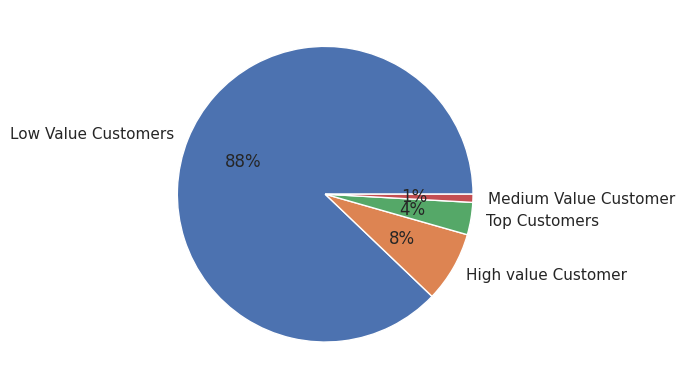

In [86]:
plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

> Potentially, all the low value customers are also temporary customers: i.e, one timers

In [87]:
rfm_df.head()

,customer_id,recency,frequency,monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
0,0001fd6190edaaf884bcaf3d49edf079,547,1,195.42,2.56,43.93,43.93,1.89,Low Value Customers
1,0002414f95344307404f0ace7a26f1d5,378,1,179.35,20.82,43.93,43.93,2.02,Low Value Customers
2,000379cdec625522490c315e70c7a9fb,149,1,107.01,66.93,43.93,43.93,2.37,Low Value Customers
3,0004164d20a9e969af783496f3408652,504,1,71.80,6.07,43.93,43.93,1.91,Low Value Customers
4,000419c5494106c306a97b5635748086,179,1,49.40,60.15,43.93,43.93,2.32,Low Value Customers


In [88]:
rfm_df.set_index('customer_id', inplace=True)

In [89]:
quartiles = rfm_df.quantile(q=[0.25, 0.50, 0.75])
print(quartiles, type(quartiles))

      recency  frequency  monetary  R_rank_norm  F_rank_norm  M_rank_norm  \
0.25    113.0        1.0    51.840        25.08        43.93        43.93   
0.50    220.0        1.0    83.470        49.94        43.93        43.93   
0.75    349.0        1.0   139.615        75.14        43.93        43.93   

      RFM_Score  
0.25       2.08  
0.50       2.30  
0.75       2.51   <class 'pandas.core.frame.DataFrame'>


<ipython-input-89-d85e98d5a176>:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quartiles = rfm_df.quantile(q=[0.25, 0.50, 0.75])


In [90]:
rfm_table = rfm_df.copy(deep=True)

In [91]:
rfm_table.drop(columns=['R_rank_norm', 'F_rank_norm', 'M_rank_norm'], inplace=True)

In [92]:
rfm_table

,recency,frequency,monetary,RFM_Score,Customer_segment
customer_id,,,,,
0001fd6190edaaf884bcaf3d49edf079,547,1,195.42,1.89,Low Value Customers
0002414f95344307404f0ace7a26f1d5,378,1,179.35,2.02,Low Value Customers
000379cdec625522490c315e70c7a9fb,149,1,107.01,2.37,Low Value Customers
0004164d20a9e969af783496f3408652,504,1,71.80,1.91,Low Value Customers
000419c5494106c306a97b5635748086,179,1,49.40,2.32,Low Value Customers
...,...,...,...,...,...
fffb97495f78be80e2759335275df2aa,225,1,61.01,2.23,Low Value Customers
fffecc9f79fd8c764f843e9951b11341,152,3,81.36,4.67,Top Customers
fffeda5b6d849fbd39689bb92087f431,99,1,63.13,2.46,Low Value Customers


In [93]:
# Save rfm_table to csv for further analysis
rfm_table.to_csv(path+'data/rfm.csv')

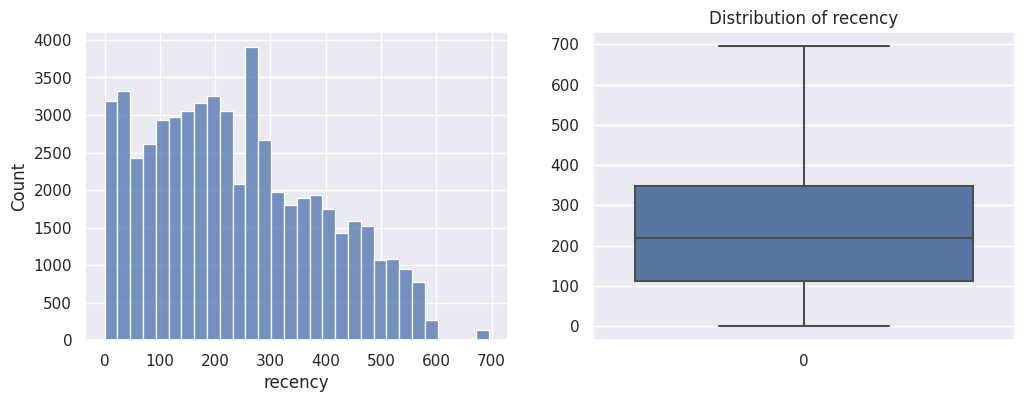

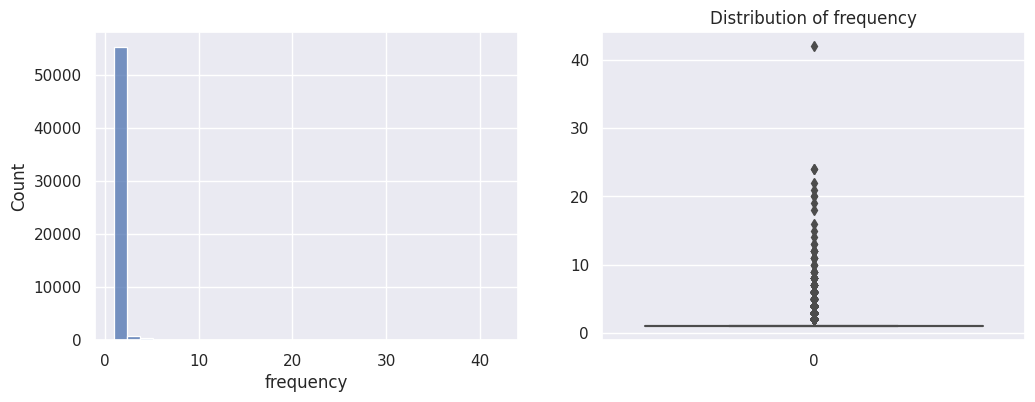

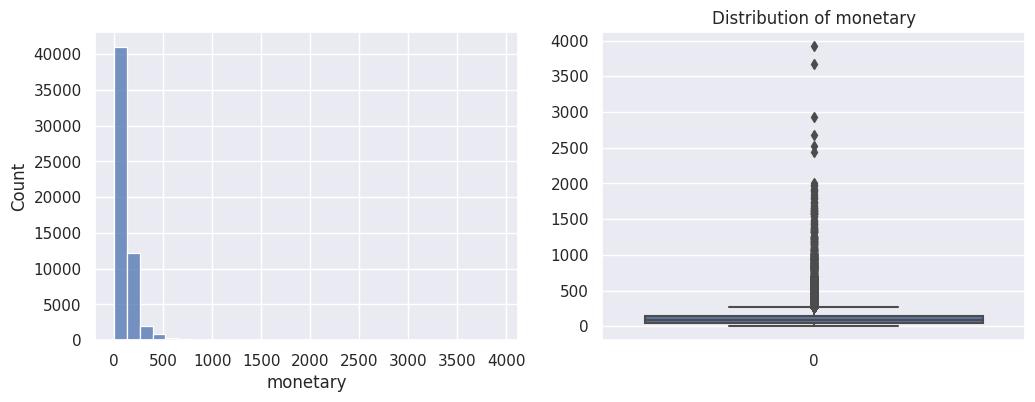

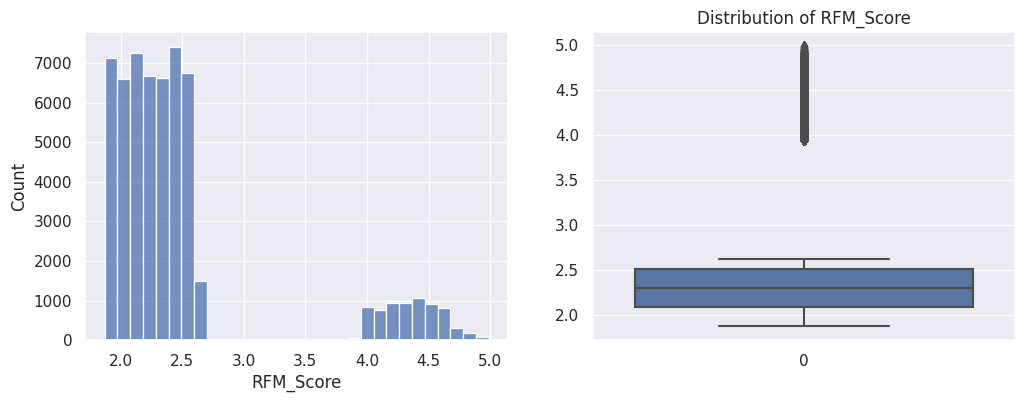

In [94]:
%matplotlib inline
for column in rfm_table.select_dtypes(['int64', 'int32', 'float64']).columns:
    f, axes = plt.subplots(1,2, figsize=(12,4));
    titre = 'Distribution of ' + str(column);
    plt.title(titre);
    sns.histplot(rfm_table[column], bins=30, ax=axes[0]);
    titre = 'Distribution of ' + str(column);
    plt.title(titre);
    sns.boxplot(rfm_table[column], ax=axes[1]);
    plt.show();

### Kmeans clustering on RFM data

In [95]:
rfm = rfm_df.copy(deep=True)

In [96]:
rfm

,recency,frequency,monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
customer_id,,,,,,,,
0001fd6190edaaf884bcaf3d49edf079,547,1,195.42,2.56,43.93,43.93,1.89,Low Value Customers
0002414f95344307404f0ace7a26f1d5,378,1,179.35,20.82,43.93,43.93,2.02,Low Value Customers
000379cdec625522490c315e70c7a9fb,149,1,107.01,66.93,43.93,43.93,2.37,Low Value Customers
0004164d20a9e969af783496f3408652,504,1,71.80,6.07,43.93,43.93,1.91,Low Value Customers
000419c5494106c306a97b5635748086,179,1,49.40,60.15,43.93,43.93,2.32,Low Value Customers
...,...,...,...,...,...,...,...,...
fffb97495f78be80e2759335275df2aa,225,1,61.01,48.82,43.93,43.93,2.23,Low Value Customers
fffecc9f79fd8c764f843e9951b11341,152,3,81.36,66.39,98.12,98.12,4.67,Top Customers
fffeda5b6d849fbd39689bb92087f431,99,1,63.13,78.82,43.93,43.93,2.46,Low Value Customers


<Axes: xlabel='monetary', ylabel='Count'>

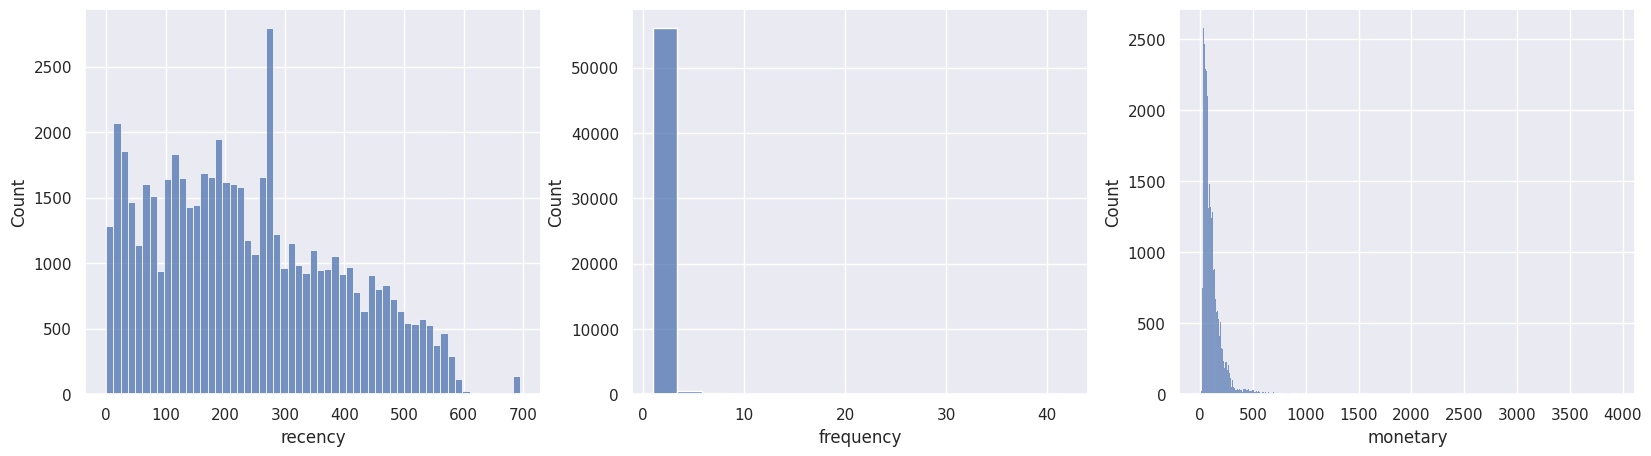

In [97]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.histplot(rfm['recency'])

plt.subplot(1,3,2)
sns.histplot(rfm['frequency'])

plt.subplot(1,3,3)
sns.histplot(rfm['monetary'])

In [98]:
# Apply log transformation
rfm_log = rfm[['recency', 'frequency', 'monetary']].apply(np.log, axis=1).round(3)

In [99]:
rfm_log.head()

,recency,frequency,monetary
customer_id,,,
0001fd6190edaaf884bcaf3d49edf079,6.304,0.0,5.275
0002414f95344307404f0ace7a26f1d5,5.935,0.0,5.189
000379cdec625522490c315e70c7a9fb,5.004,0.0,4.673
0004164d20a9e969af783496f3408652,6.223,0.0,4.274
000419c5494106c306a97b5635748086,5.187,0.0,3.900


In [100]:
rfm_log.drop(index=rfm_log[rfm_log['recency'] == -np.inf].index.values, inplace=True)

In [101]:
rfm_log.to_csv(path+'data/rfm_log.csv')

In [102]:
rfm_log

,recency,frequency,monetary
customer_id,,,
0001fd6190edaaf884bcaf3d49edf079,6.304,0.000,5.275
0002414f95344307404f0ace7a26f1d5,5.935,0.000,5.189
000379cdec625522490c315e70c7a9fb,5.004,0.000,4.673
0004164d20a9e969af783496f3408652,6.223,0.000,4.274
000419c5494106c306a97b5635748086,5.187,0.000,3.900
...,...,...,...
fffb97495f78be80e2759335275df2aa,5.416,0.000,4.111
fffecc9f79fd8c764f843e9951b11341,5.024,1.099,4.399
fffeda5b6d849fbd39689bb92087f431,4.595,0.000,4.145


<Axes: xlabel='monetary', ylabel='Count'>

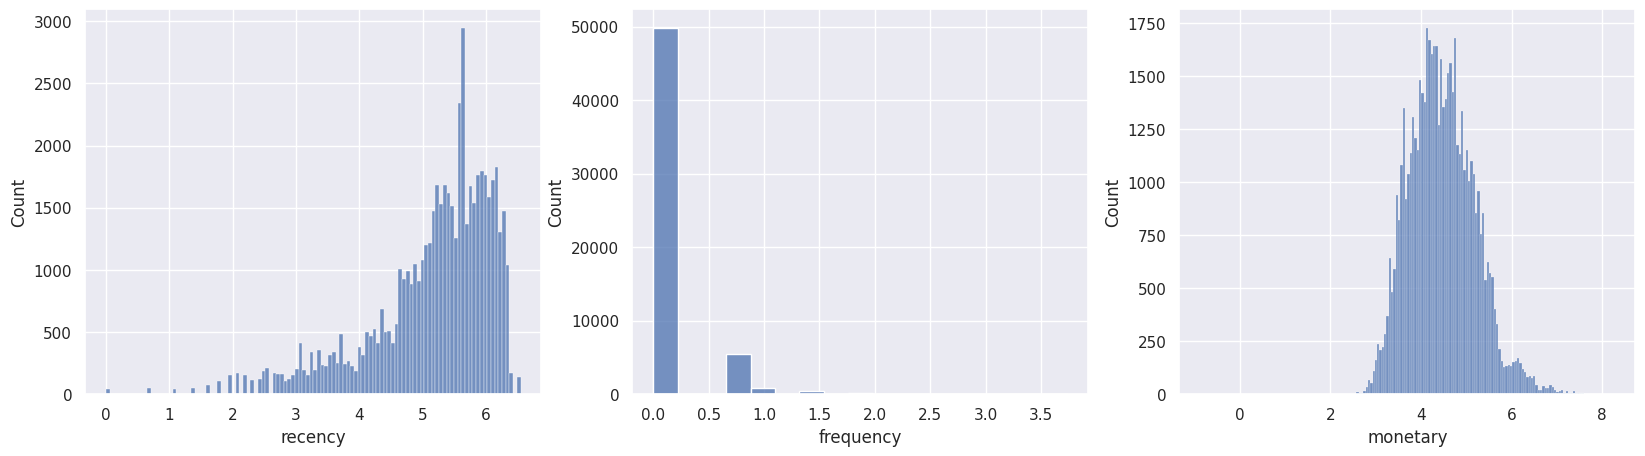

In [103]:
#Plot data distribution after log transformation
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.histplot(rfm_log['recency'])

plt.subplot(1,3,2)
sns.histplot(rfm_log['frequency'])

plt.subplot(1,3,3)
sns.histplot(rfm_log['monetary'])

In [104]:
rfm_log.describe()

,recency,frequency,monetary
count,56772.000000,56772.000000,56772.000000
mean,5.147053,0.100374,4.468105
std,0.978707,0.289226,0.723748
min,0.000000,0.000000,-0.868000
25%,4.727000,0.000000,3.948000
50%,5.394000,0.000000,4.424000
75%,5.855000,0.000000,4.939000
max,6.544000,3.738000,8.274000


In [105]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [106]:
rfm_scaled

array([[ 1.18212863, -0.34704576,  1.11489375],
       [ 0.8050971 , -0.34704576,  0.99606683],
       [-0.14616671, -0.34704576,  0.28310536],
       ...,
       [-0.56406887, -0.34704576, -0.44643661],
       [-0.833815  , -0.34704576,  1.24201091],
       [ 0.75809588,  2.04902671,  0.05926862]])

In [107]:
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm_log.index, columns=rfm_log.columns)
rfm_scaled.head()

,recency,frequency,monetary
customer_id,,,
0001fd6190edaaf884bcaf3d49edf079,1.182129,-0.347046,1.114894
0002414f95344307404f0ace7a26f1d5,0.805097,-0.347046,0.996067
000379cdec625522490c315e70c7a9fb,-0.146167,-0.347046,0.283105
0004164d20a9e969af783496f3408652,1.099366,-0.347046,-0.268196
000419c5494106c306a97b5635748086,0.040816,-0.347046,-0.784955


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

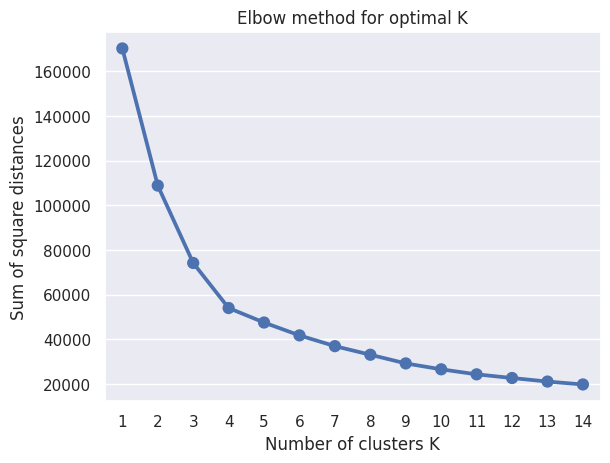

In [108]:
#wcss stands for within cluster sum of squares
wcss={}

for k in range(1,15):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=1000 , random_state=20)
    km = km.fit(rfm_scaled)
    wcss[k] = km.inertia_

#Plot graph for the wcss values and the number of clusters
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.xlabel('Number of clusters K')
plt.ylabel('Sum of square distances')
plt.title('Elbow method for optimal K')
plt.show()

**Observation**: Choose N clusters = 4

In [109]:
kmean_model = KMeans(n_clusters=4, init='k-means++', max_iter=1000, random_state=20)
kmean_model.fit(rfm_scaled)

#find the clusters for the records given in our dataset
rfm_log['Cluster'] = kmean_model.labels_

#check the datset
rfm_log.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,recency,frequency,monetary,Cluster
customer_id,,,,
0001fd6190edaaf884bcaf3d49edf079,6.304,0.0,5.275,3
0002414f95344307404f0ace7a26f1d5,5.935,0.0,5.189,3
000379cdec625522490c315e70c7a9fb,5.004,0.0,4.673,3
0004164d20a9e969af783496f3408652,6.223,0.0,4.274,1
000419c5494106c306a97b5635748086,5.187,0.0,3.900,1


In [110]:
clusters = rfm_log.Cluster.value_counts().to_frame()

In [111]:
clusters

,Cluster
1,21956
3,19331
0,9002
2,6483


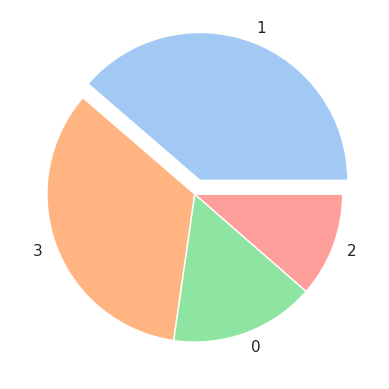

In [112]:
colors = sns.color_palette('pastel')[0:5]
plt.pie(x=clusters['Cluster'], labels=clusters.index.values, colors=colors, explode=[0.1, 0, 0, 0]);

## Save file to CSV

In [113]:
client_data

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score,order_purchase_hour,order_purchase_day,delivery_delay,preferred_payment_type,max_installments,preferred_category,nb_products,avg_purchase_price,max_purchase_price,avg_review_score,geolocation_zip_code_prefix,geolocation_city,geolocation_state,geolocation_lat_mean,geolocation_lng_mean
0,8a2e7ef9053dea531e4dc76bd6d853e6,64190b91b656ab8f37eb89b93dc84584,13380,nova odessa,SP,a548910a1c6147796b98fdf73dbeba33,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14,1.0,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-06 12:48:39,79.79,8.30,47.0,493.0,1.0,245.0,19.0,14.0,14.0,electronics,1.0,credit_card,1.0,88.09,5,12,2,10,credit_card,1.0,electronics,1,79.79,79.79,5.0,13380.0,nova odessa,SP,-22.785055,-47.310387
1,840be0730010e9580efd289bc9f37706,dcd4940b3f96a3e2b73d8f73387230cf,8412,sao paulo,SP,e48aa0d2dcec3a2e87348811bcfdf22b,delivered,2017-06-30 15:38:46,2017-06-30 15:50:17,2017-07-03 16:22:53,2017-07-15 12:57:24,2017-08-03,1.0,3152a0c0d93abeec99e4a6169aecc88b,d2374cbcbb3ca4ab1086534108cc3ab7,2017-07-20 15:50:17,46.90,11.85,35.0,133.0,1.0,600.0,40.0,4.0,30.0,home,1.0,credit_card,2.0,58.75,5,15,4,15,credit_card,2.0,home,1,46.90,46.90,5.0,8412.0,sao paulo,SP,-23.552130,-46.408054
2,daf813bc2e41c86027d086e8dfb35571,8c89391790076834500661cc1e5d6860,12316,jacarei,SP,9c214ac970e84273583ab523dfafd09b,delivered,2017-05-08 13:35:48,2017-05-08 13:50:15,2017-05-09 14:19:29,2017-05-16 16:49:51,2017-05-30,1.0,35afc973633aaeb6b877ff57b2793310,4a3ca9315b744ce9f8e9374361493884,2017-05-15 13:50:15,89.90,12.13,56.0,176.0,1.0,1825.0,53.0,10.0,40.0,home,1.0,credit_card,3.0,102.03,5,13,0,9,credit_card,3.0,home,1,89.90,89.90,5.0,12316.0,jacareí,SP,-23.316881,-45.940390
3,272b46feddddc51904608ddd90feee33,485fa1b8db05ed6fa0062ece4ce80d2e,35180,timoteo,MG,cdf9aa68e72324eeb25c7de974696ee2,delivered,2017-12-13 14:59:45,2017-12-13 15:07:23,2017-12-14 17:37:13,2017-12-22 12:49:55,2018-01-15,1.0,25e2023ed83352bde98dc1490d14c3d8,de23c3b98a88888289c6f5cc1209054a,2017-12-19 15:07:23,119.99,17.00,30.0,1024.0,1.0,887.0,30.0,22.0,20.0,arts,1.0,credit_card,1.0,136.99,5,14,2,9,credit_card,1.0,arts,1,119.99,119.99,5.0,35180.0,timoteo,MG,-19.545863,-42.643543
4,8ebbeb09e94d1e789142983f73faa9cd,a5ee02c2d02b8929c0949fc114c5a19e,6700,cotia,SP,9d6f15f95d01e79bd1349cc208361f09,delivered,2018-02-12 16:07:34,2018-02-12 16:27:39,2018-02-14 20:04:16,2018-02-15 19:16:54,2018-02-26,1.0,acffe5d7cd56e6b564cf6841486644ff,db4350fd57ae30082dec7acbaacc17f9,2018-02-16 16:27:39,35.00,7.78,58.0,356.0,1.0,200.0,19.0,4.0,11.0,health_beauty,1.0,credit_card,2.0,42.78,4,16,0,4,credit_card,2.0,health_beauty,1,35.00,35.00,4.0,6700.0,cotia,SP,-23.609193,-46.934942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66686,486ce94ccf26c511ab93d31fefd5de0e,bc71d9dde7a14cf82eb4200b2a282131,35570,formiga,MG,acd45245723df7cb52772a34416b41b1,delivered,2018-04-19 19:44:47,2018-04-19 20:10:40,2018-04-20 22:24:23,2018-05-07 16:48:43,2018-05-10,1.0,30ccf4724f5227265f837e9ba0246278,dbc22125167c298ef99da25668e1011f,2018-04-25 20:10:40,79.60,15.41,52.0,573.0,1.0,1450.0,49.0,10.0,33.0,sports_leisure,1.0,credit_card,2.0,95.01,3,19,3,18,credit_card,2.0,sports_leisure,1,79.60,79.60,3.0,35570.0,formiga,MG,-20.462186,-45.433273
66687,3d7697c0971cb2606444adae322d8bb

In [114]:
client_data.drop_duplicates(inplace=True)

In [115]:
client_data.shape

(66646, 46)

In [116]:
test_completion(client_data)

,Completion rate,Number of missing values
customer_id,100.00,0
payment_value,100.00,0
product_length_cm,100.00,0
customer_unique_id,100.00,0
product_width_cm,100.00,0
product_category_name_english,100.00,0
payment_sequential,100.00,0
payment_type,100.00,0
payment_installments,100.00,0
review_score,100.00,0


In [117]:
!ls '/content/drive/My Drive/OCL/P5/data/'

13_cluster_data.csv		olist_order_payments_dataset.csv
5_cluster_data.csv		olist_order_reviews_dataset.csv
6_cluster_data.csv		olist_orders_dataset.csv
brazil_population.csv		olist_products_dataset.csv
client_data_cleaned.csv		olist_sellers_dataset.csv
client_data_for_clustering.csv	product_category_name_translation.csv
olist_customers_dataset.csv	rfm.csv
olist_geolocation_dataset.csv	rfm_log.csv
olist_order_items_dataset.csv


In [118]:
path

'/content/drive/My Drive/OCL/P5/'

In [119]:
client_data.to_csv(path+'data/client_data_cleaned.csv', index=False)

In [120]:
columns_list = client_data.columns

In [123]:
columns = columns_list.tolist()

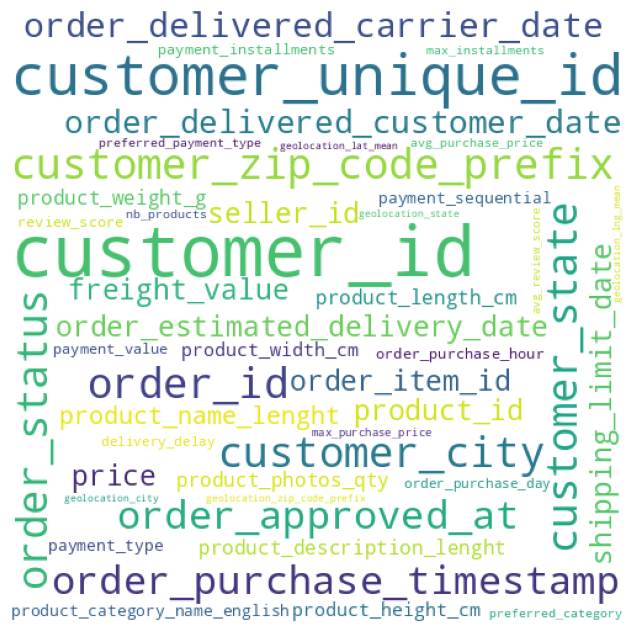

In [128]:
from wordcloud import WordCloud
unique_string=(" ").join(columns)
wordcloud = WordCloud(width = 500, height = 500, background_color="white").generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
#plt.close()

,customer_zip_code_prefix,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_installments,payment_value,review_score,order_purchase_hour,order_purchase_day,delivery_delay,max_installments,nb_products,avg_purchase_price,max_purchase_price,avg_review_score,geolocation_zip_code_prefix,geolocation_lat_mean,geolocation_lng_mean
count,66646.000000,66646.000000,66646.000000,66646.000000,66646.000000,66646.000000,66646.000000,66646.000000,66646.000000,66646.000000,66646.000000,66646.000000,66646.000000,66646.000000,66646.000000,66646.000000,66646.000000,66646.000000,58115.000000,66646.000000,66646.000000,66646.000000,66646.000000,57905.000000,57905.000000,57905.000000
mean,33477.101386,1.157144,70.776442,15.239557,48.609699,620.006017,1.855310,725.948219,25.258890,12.928788,20.043934,1.089353,2.517991,99.717405,4.121193,14.791255,2.752783,12.291810,2.475488,1.539837,70.776704,71.197657,4.121203,27969.640031,-22.543048,-46.429234
std,29705.119066,0.556794,52.207021,4.850842,9.755846,393.036972,1.168032,692.791097,9.699631,7.707964,7.921916,0.681237,2.361754,66.073101,1.320170,5.336121,1.964028,8.864286,2.291788,1.864418,52.098195,52.215568,1.317336,26904.283734,2.391274,2.740058
min,1003.000000,1.000000,0.850000,2.260000,20.000000,4.000000,1.000000,0.000000,7.000000,2.000000,7.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.850000,0.850000,1.000000,1003.000000,-29.122114,-55.026212
25%,9721.000000,1.000000,30.000000,12.130000,42.000000,322.000000,1.000000,213.000000,17.000000,7.000000,14.000000,1.000000,1.000000,49.842500,4.000000,11.000000,1.000000,7.000000,1.000000,1.000000,30.900000,31.752500,4.000000,8420.000000,-23.586624,-47.664918
50%,22735.000000,1.000000,55.000000,15.110000,51.000000,530.000000,1.000000,450.000000,21.000000,11.000000,18.000000,1.000000,1.000000,82.510000,5.000000,15.000000,3.000000,10.000000,1.000000,1.000000,55.000000,55.990000,5.000000,18400.000000,-23.007745,-46.638517
75%,48840.000000,1.000000,95.000000,18.090000,57.000000,850.000000,2.000000,1020.000000,30.000000,17.000000,25.000000,1.000000,3.000000,135.000000,5.000000,19.000000,4.000000,15.000000,3.000000,2.000000,95.000000,95.915000,5.000000,35503.000000,-21.737713,-44.024489
max,99980.000000,20.000000,277.000000,30.410000,76.000000,1923.000000,5.000000,3900.000000,55.000000,36.000000,41.000000,26.000000,24.000000,344.280000,5.000000,23.000000,6.000000,209.000000,24.000000,42.000000,277.000000,277.000000,5.000000,99980.000000,-14.409266,-38.948910


## Exploratory analysis

In [ ]:
df = pd.read_csv(path+'data/client_data_cleaned.csv')

In [ ]:
df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score,order_purchase_hour,order_purchase_day,delivery_delay,preferred_payment_type,max_installments,preferred_category,nb_products,avg_purchase_price,max_purchase_price,avg_review_score,geolocation_zip_code_prefix,geolocation_city,geolocation_state,geolocation_lat_mean,geolocation_lng_mean
0,8a2e7ef9053dea531e4dc76bd6d853e6,64190b91b656ab8f37eb89b93dc84584,13380,nova odessa,SP,a548910a1c6147796b98fdf73dbeba33,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14,1.0,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-06 12:48:39,79.79,8.30,47.0,493.0,1.0,245.0,19.0,14.0,14.0,electronics,1.0,credit_card,1.0,88.09,5,12,2,10,credit_card,1.0,electronics,1,79.79,79.79,5.0,13380.0,nova odessa,SP,-22.785055,-47.310387
1,840be0730010e9580efd289bc9f37706,dcd4940b3f96a3e2b73d8f73387230cf,8412,sao paulo,SP,e48aa0d2dcec3a2e87348811bcfdf22b,delivered,2017-06-30 15:38:46,2017-06-30 15:50:17,2017-07-03 16:22:53,2017-07-15 12:57:24,2017-08-03,1.0,3152a0c0d93abeec99e4a6169aecc88b,d2374cbcbb3ca4ab1086534108cc3ab7,2017-07-20 15:50:17,46.90,11.85,35.0,133.0,1.0,600.0,40.0,4.0,30.0,home,1.0,credit_card,2.0,58.75,5,15,4,15,credit_card,2.0,home,1,46.90,46.90,5.0,8412.0,sao paulo,SP,-23.552130,-46.408054
2,daf813bc2e41c86027d086e8dfb35571,8c89391790076834500661cc1e5d6860,12316,jacarei,SP,9c214ac970e84273583ab523dfafd09b,delivered,2017-05-08 13:35:48,2017-05-08 13:50:15,2017-05-09 14:19:29,2017-05-16 16:49:51,2017-05-30,1.0,35afc973633aaeb6b877ff57b2793310,4a3ca9315b744ce9f8e9374361493884,2017-05-15 13:50:15,89.90,12.13,56.0,176.0,1.0,1825.0,53.0,10.0,40.0,home,1.0,credit_card,3.0,102.03,5,13,0,9,credit_card,3.0,home,1,89.90,89.90,5.0,12316.0,jacareí,SP,-23.316881,-45.940390
3,272b46feddddc51904608ddd90feee33,485fa1b8db05ed6fa0062ece4ce80d2e,35180,timoteo,MG,cdf9aa68e72324eeb25c7de974696ee2,delivered,2017-12-13 14:59:45,2017-12-13 15:07:23,2017-12-14 17:37:13,2017-12-22 12:49:55,2018-01-15,1.0,25e2023ed83352bde98dc1490d14c3d8,de23c3b98a88888289c6f5cc1209054a,2017-12-19 15:07:23,119.99,17.00,30.0,1024.0,1.0,887.0,30.0,22.0,20.0,arts,1.0,credit_card,1.0,136.99,5,14,2,9,credit_card,1.0,arts,1,119.99,119.99,5.0,35180.0,timoteo,MG,-19.545863,-42.643543
4,8ebbeb09e94d1e789142983f73faa9cd,a5ee02c2d02b8929c0949fc114c5a19e,6700,cotia,SP,9d6f15f95d01e79bd1349cc208361f09,delivered,2018-02-12 16:07:34,2018-02-12 16:27:39,2018-02-14 20:04:16,2018-02-15 19:16:54,2018-02-26,1.0,acffe5d7cd56e6b564cf6841486644ff,db4350fd57ae30082dec7acbaacc17f9,2018-02-16 16:27:39,35.00,7.78,58.0,356.0,1.0,200.0,19.0,4.0,11.0,health_beauty,1.0,credit_card,2.0,42.78,4,16,0,4,credit_card,2.0,health_beauty,1,35.00,35.00,4.0,6700.0,cotia,SP,-23.609193,-46.934942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66686,486ce94ccf26c511ab93d31fefd5de0e,bc71d9dde7a14cf82eb4200b2a282131,35570,formiga,MG,acd45245723df7cb52772a34416b41b1,delivered,2018-04-19 19:44:47,2018-04-19 20:10:40,2018-04-20 22:24:23,2018-05-07 16:48:43,2018-05-10,1.0,30ccf4724f5227265f837e9ba0246278,dbc22125167c298ef99da25668e1011f,2018-04-25 20:10:40,79.60,15.41,52.0,573.0,1.0,1450.0,49.0,10.0,33.0,sports_leisure,1.0,credit_card,2.0,95.01,3,19,3,18,credit_card,2.0,sports_leisure,1,79.60,79.60,3.0,35570.0,formiga,MG,-20.462186,-45.433273
66687,3d7697c0971cb2606444adae322d8bb

### Distributions

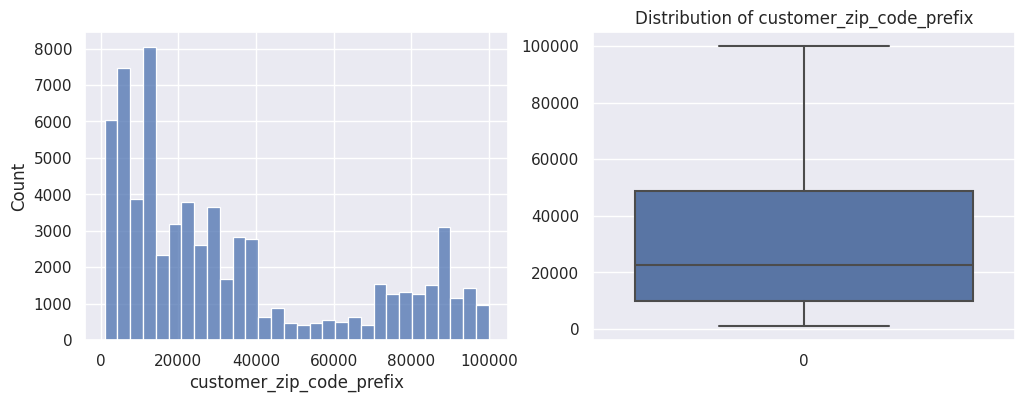

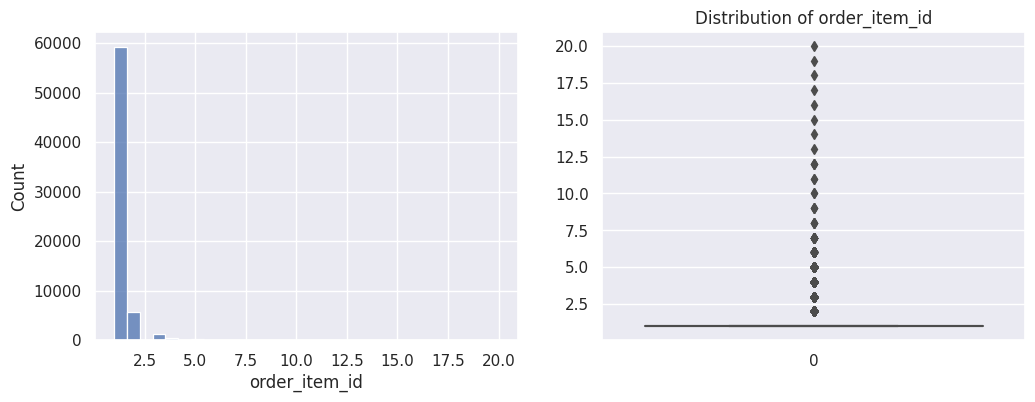

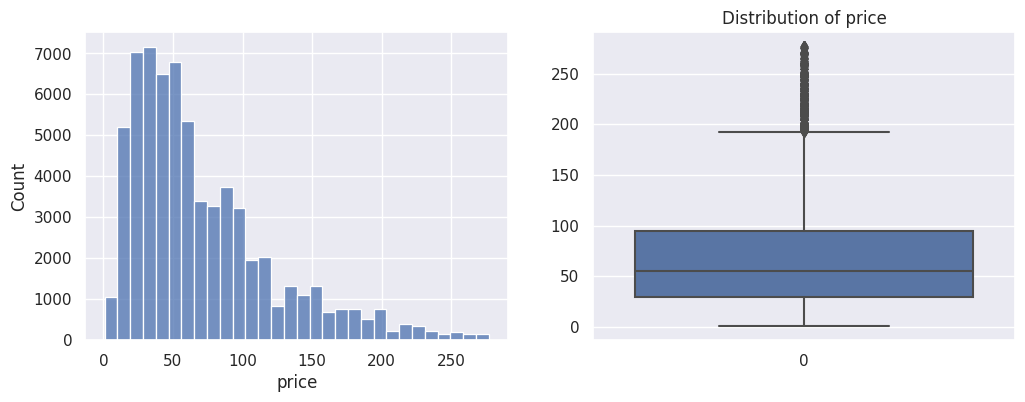

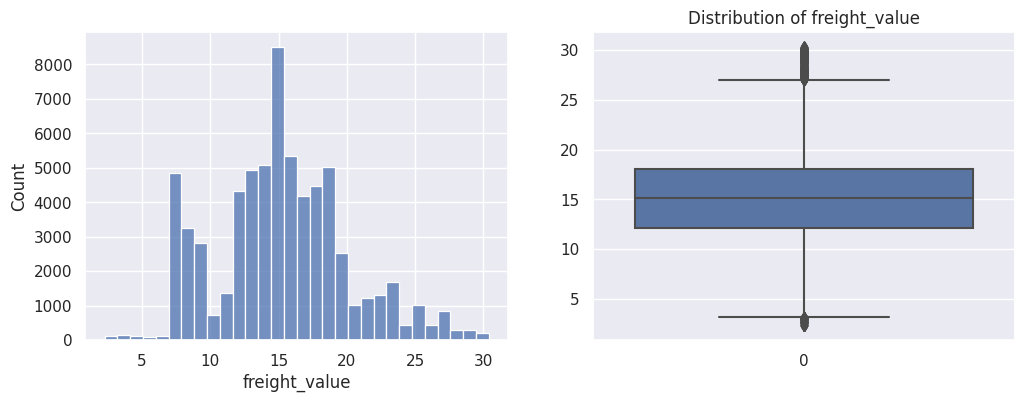

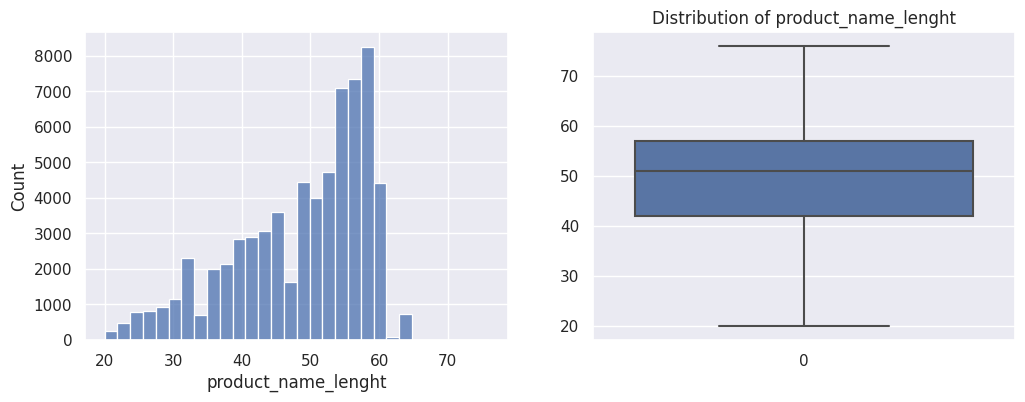

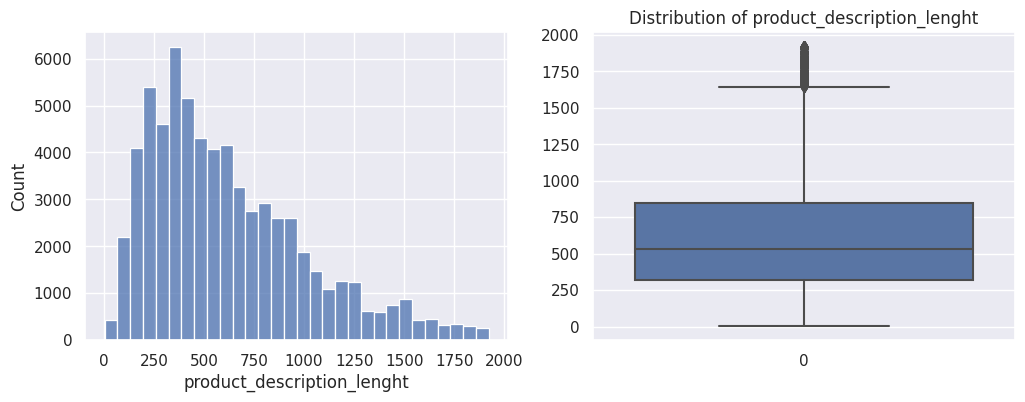

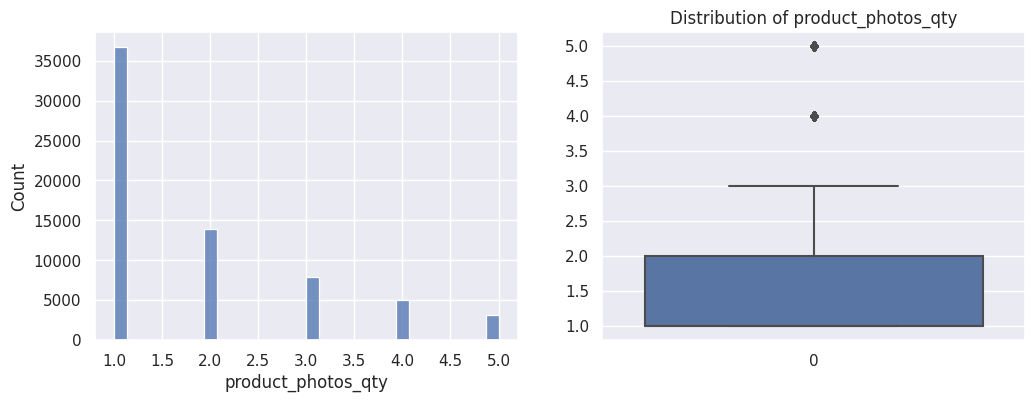

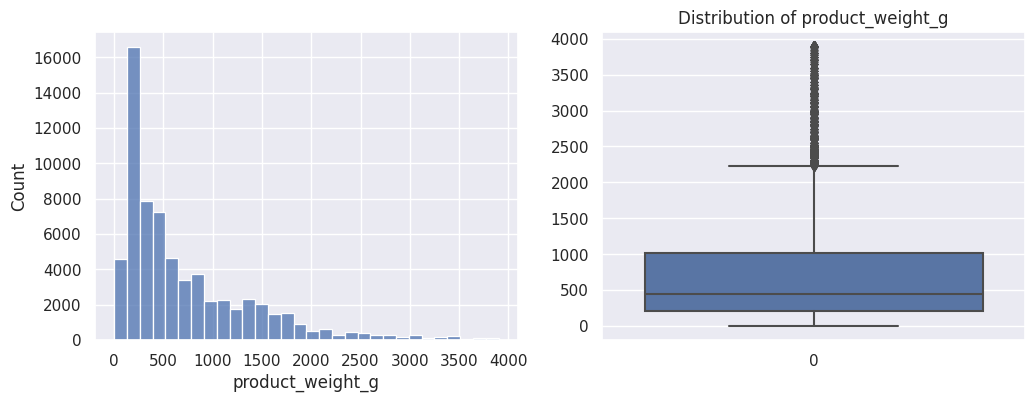

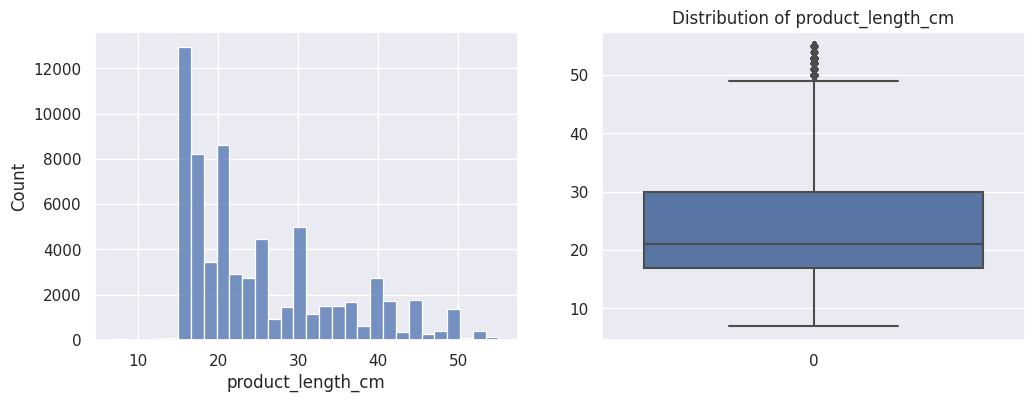

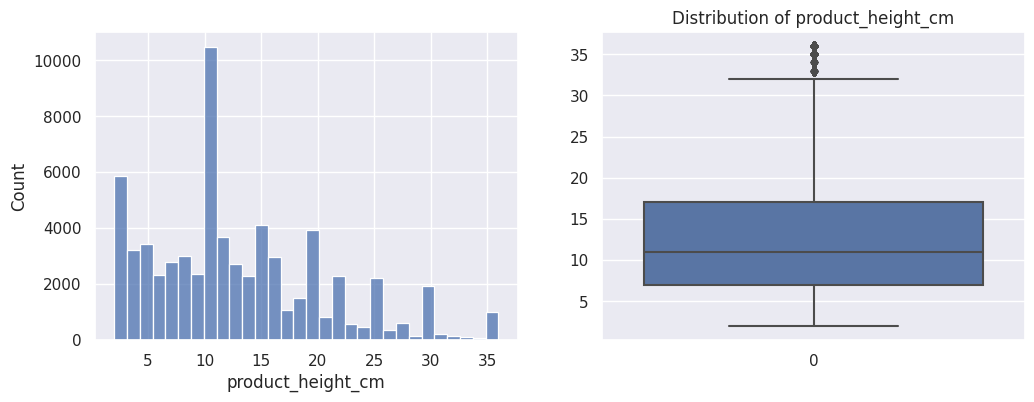

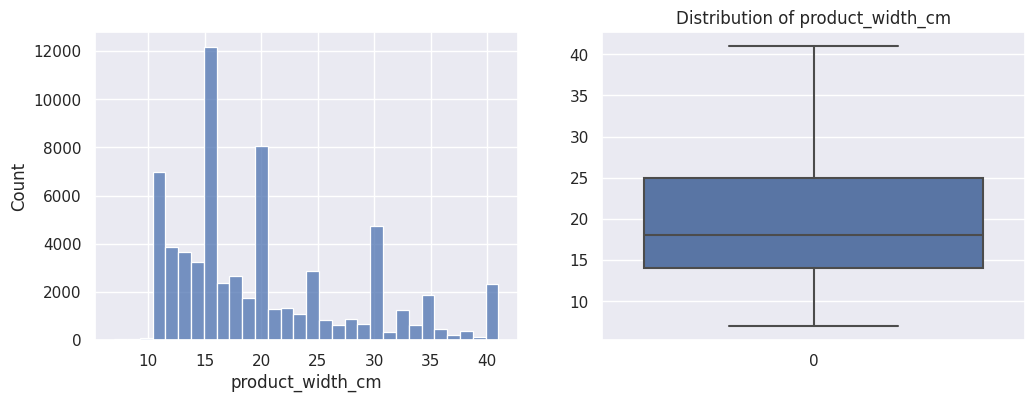

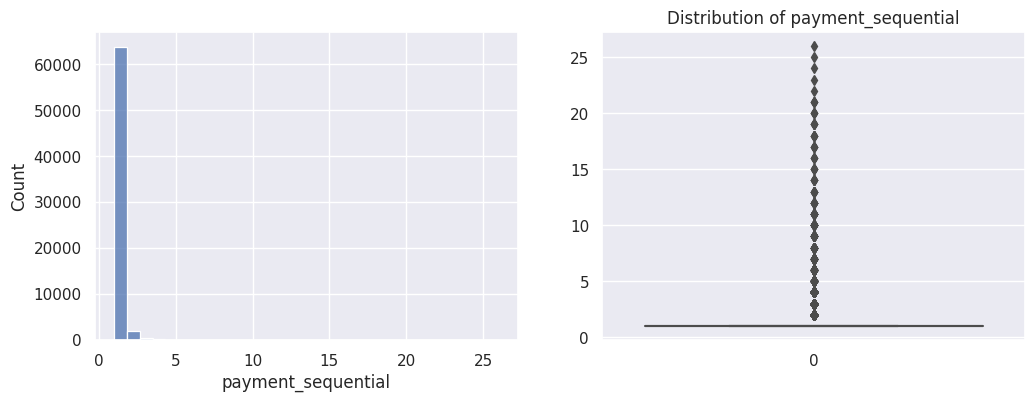

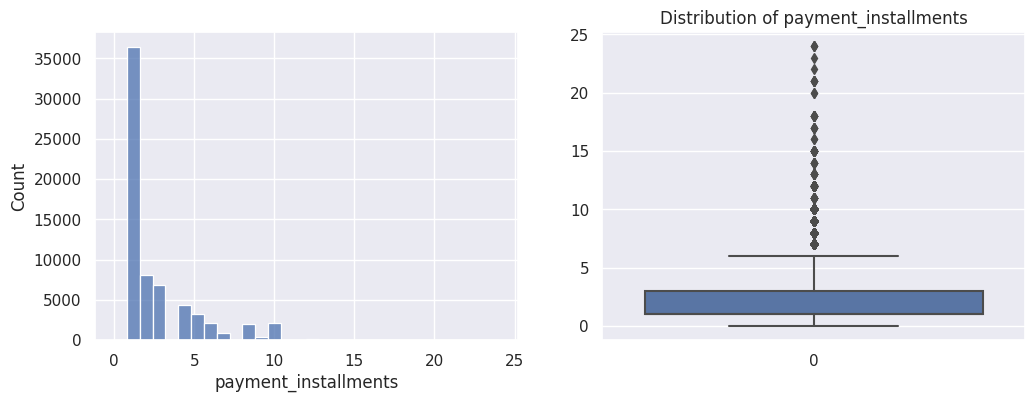

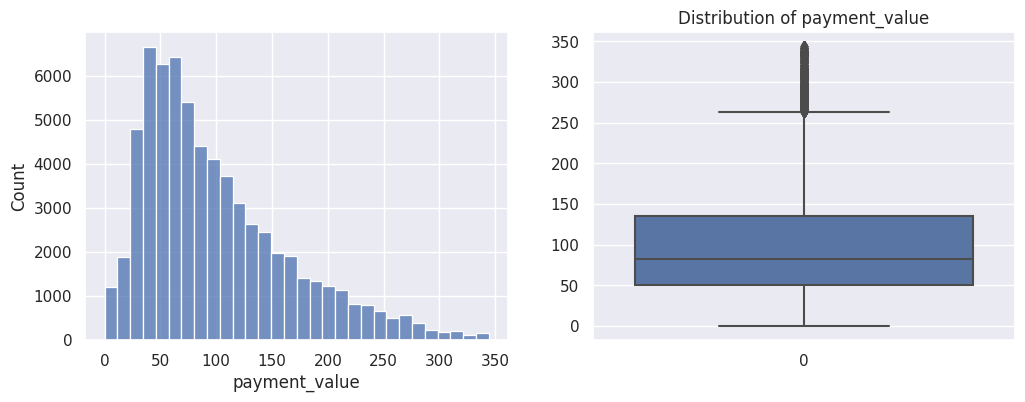

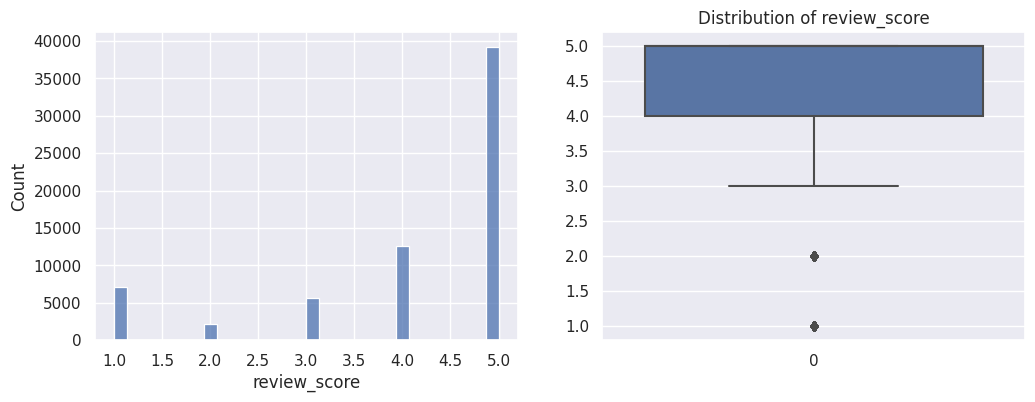

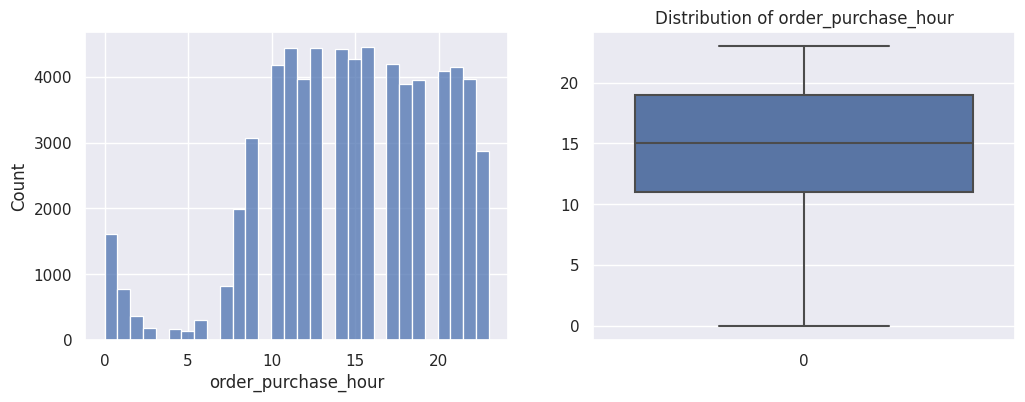

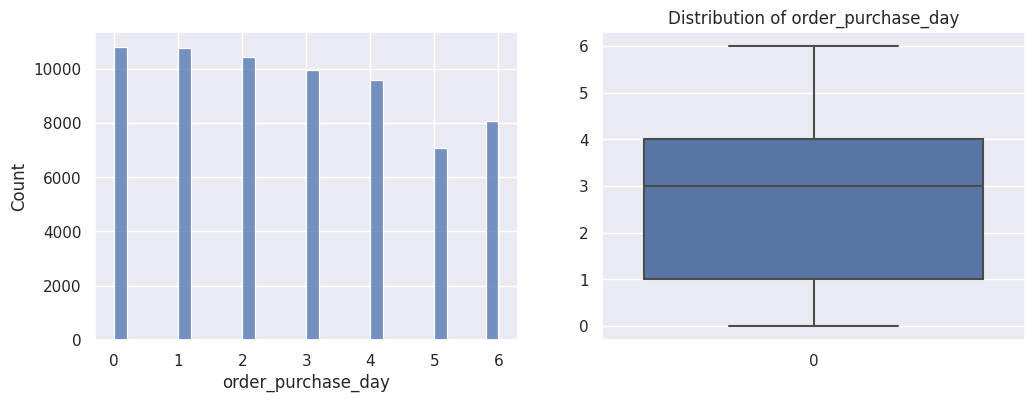

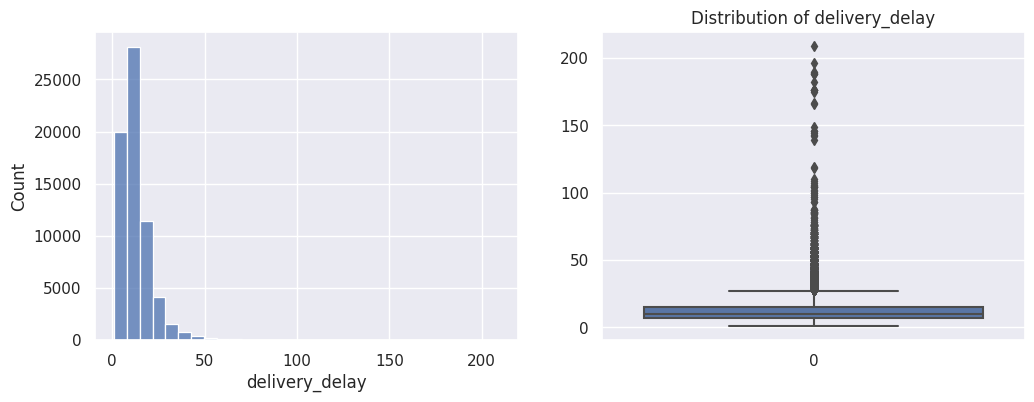

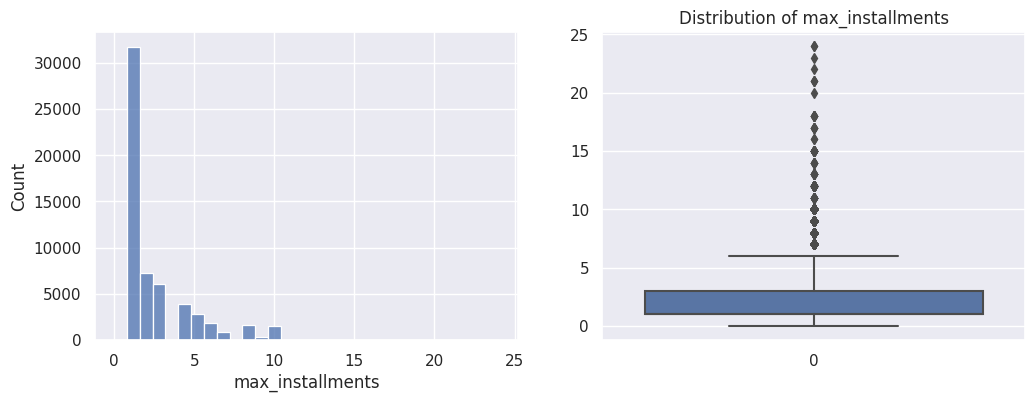

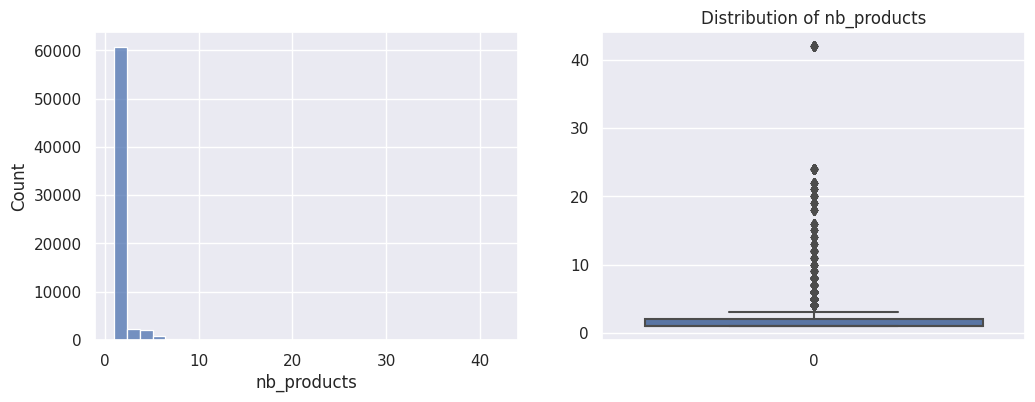

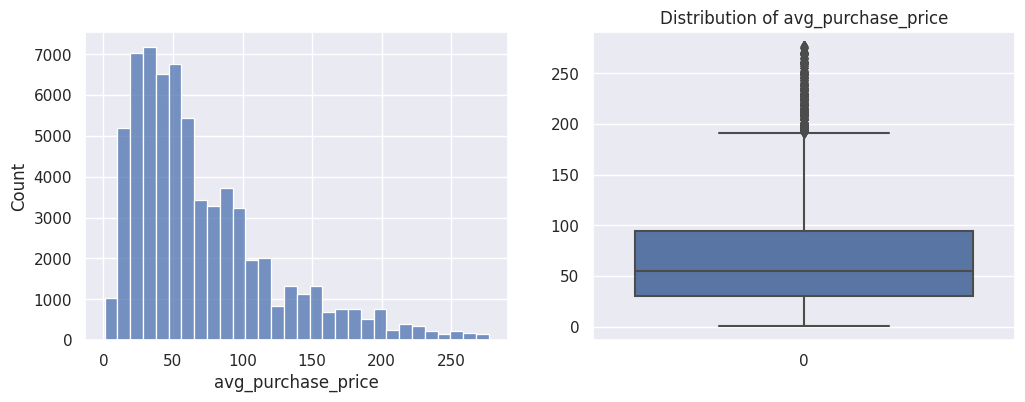

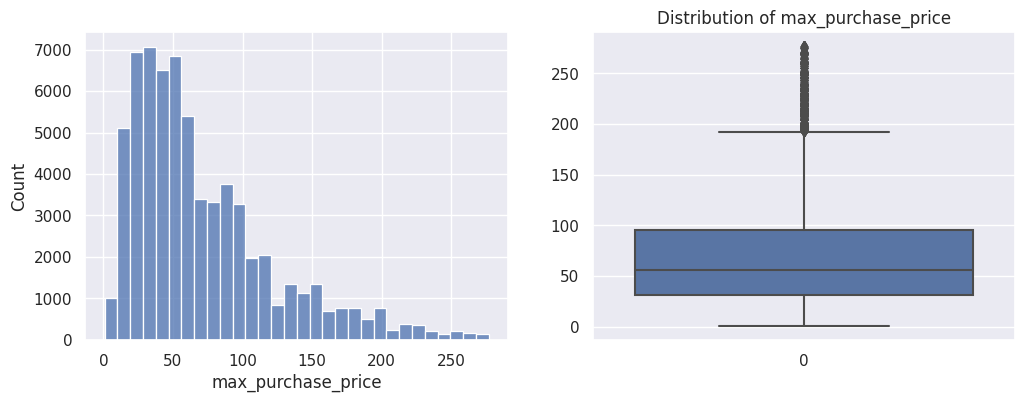

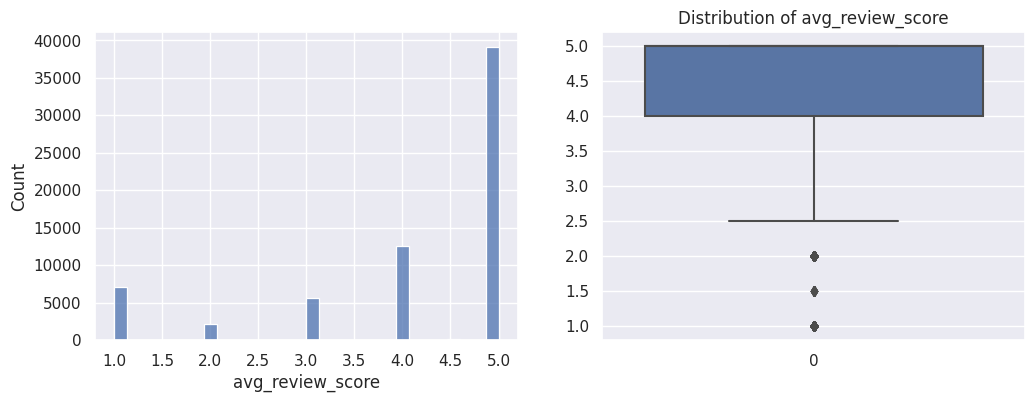

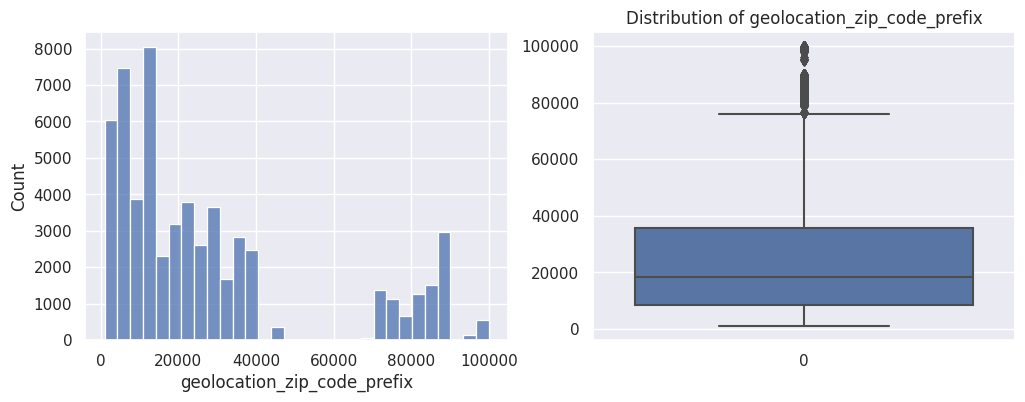

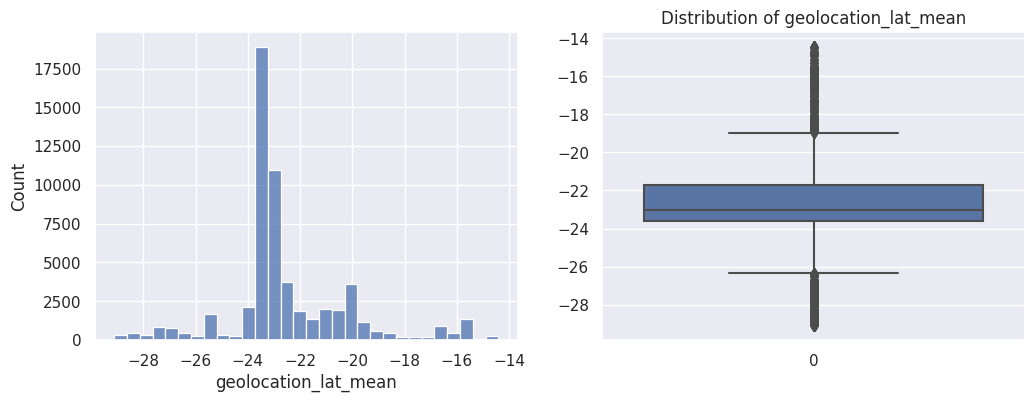

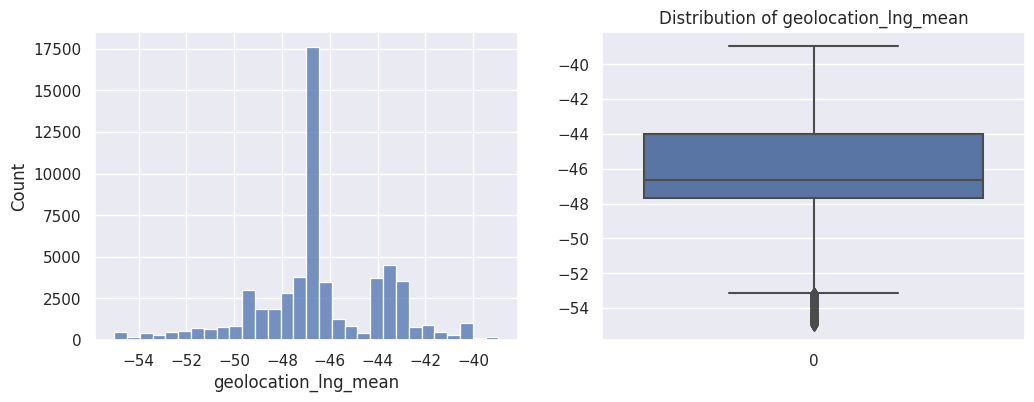

In [ ]:
%matplotlib inline
for column in df.select_dtypes(['int64', 'int32', 'float64']).columns:
    f, axes = plt.subplots(1,2, figsize=(12,4));
    titre = 'Distribution of ' + str(column);
    plt.title(titre);
    sns.histplot(df[column], bins=30, ax=axes[0]);
    titre = 'Distribution of ' + str(column);
    plt.title(titre);
    sns.boxplot(df[column], ax=axes[1]);
    plt.show();

### Correlations

<ipython-input-121-aa4f4450a243>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

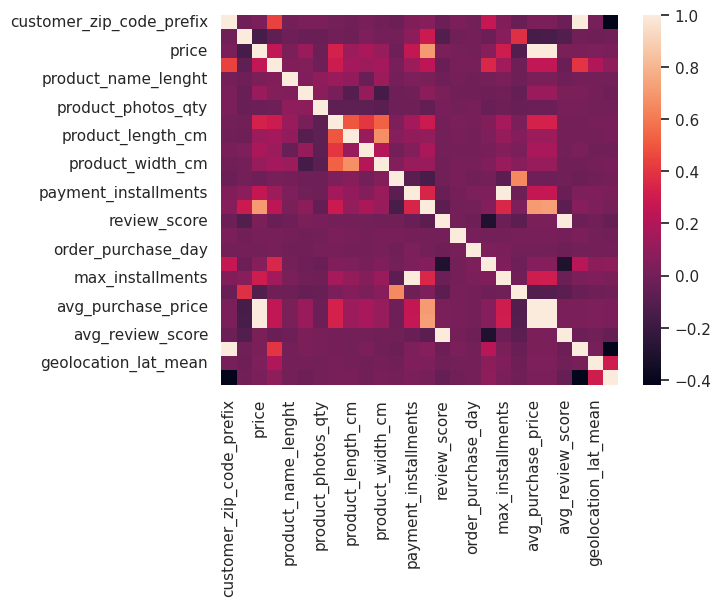

In [ ]:
sns.heatmap(df.corr())

<ipython-input-122-4aee64cb8545>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()
<ipython-input-122-4aee64cb8545>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


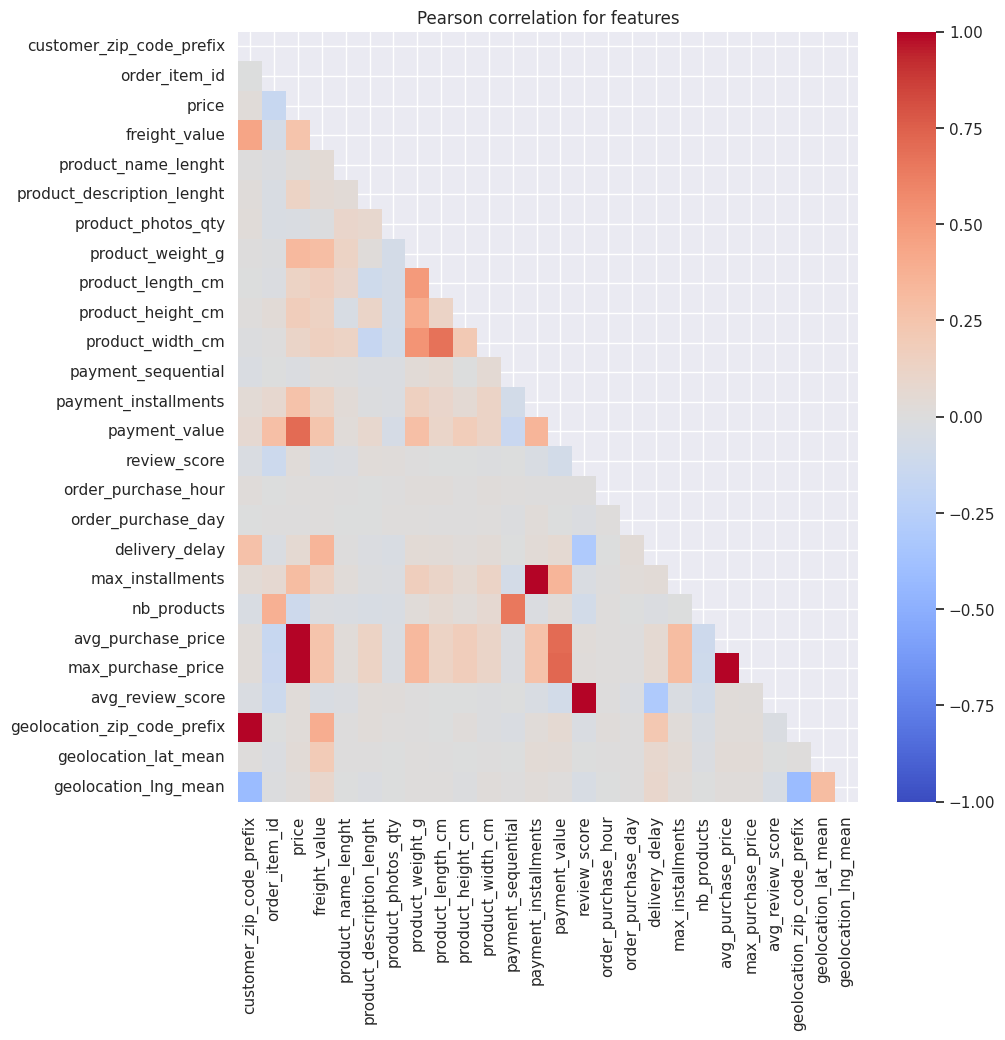

In [ ]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1)
plt.title('Pearson correlation for features')

corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm')
plt.show()
sns.set(font_scale=1)

### Client information and products purchased

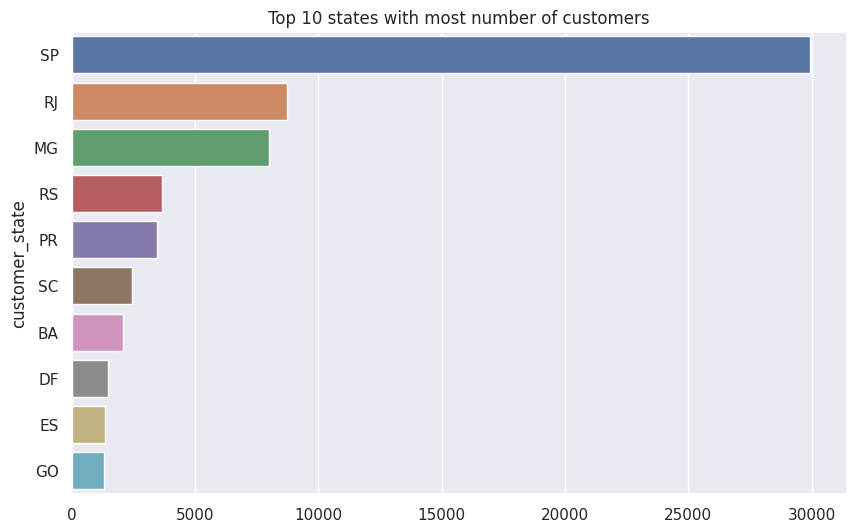

In [ ]:
state = client_data.groupby(['customer_state']).count().sort_values(
    by='customer_city', ascending=False)['customer_city'].head(10)
plt.figure(figsize=(10,6))
plt.title('Top 10 states with most number of customers')
sns.barplot(x = state.values,
           y = state.index);

In [ ]:
client_data['preferred_category'].unique()

array(['electronics', 'home', 'arts', 'health_beauty', 'garden_pets', nan,
       'appliances', 'fashion', 'sports_leisure', 'auto', 'other',
       'office', 'construction', 'food_drinks'], dtype=object)

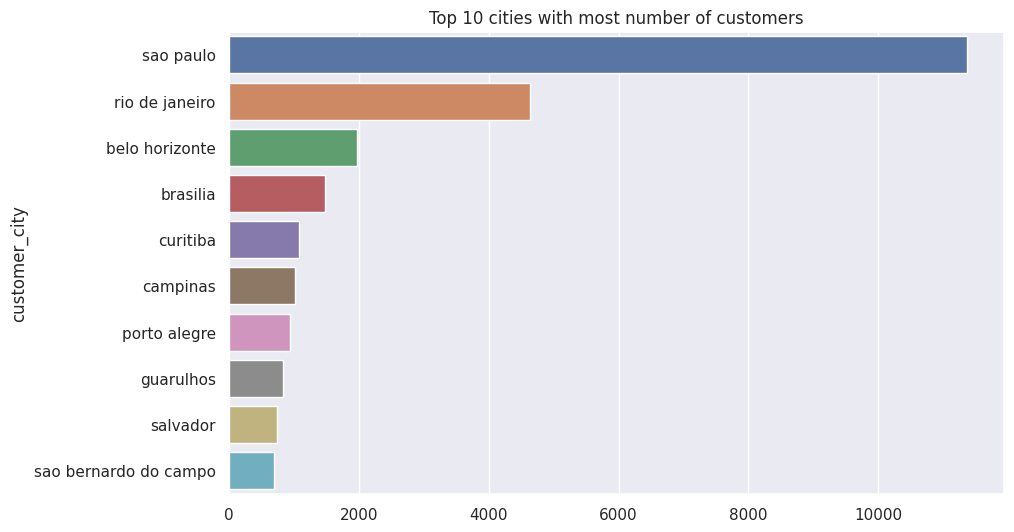

In [ ]:
cities = client_data.groupby(['customer_city']).count()[
    'customer_state'].sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
plt.title('Top 10 cities with most number of customers')
sns.barplot(x = cities.values,
           y = cities.index);

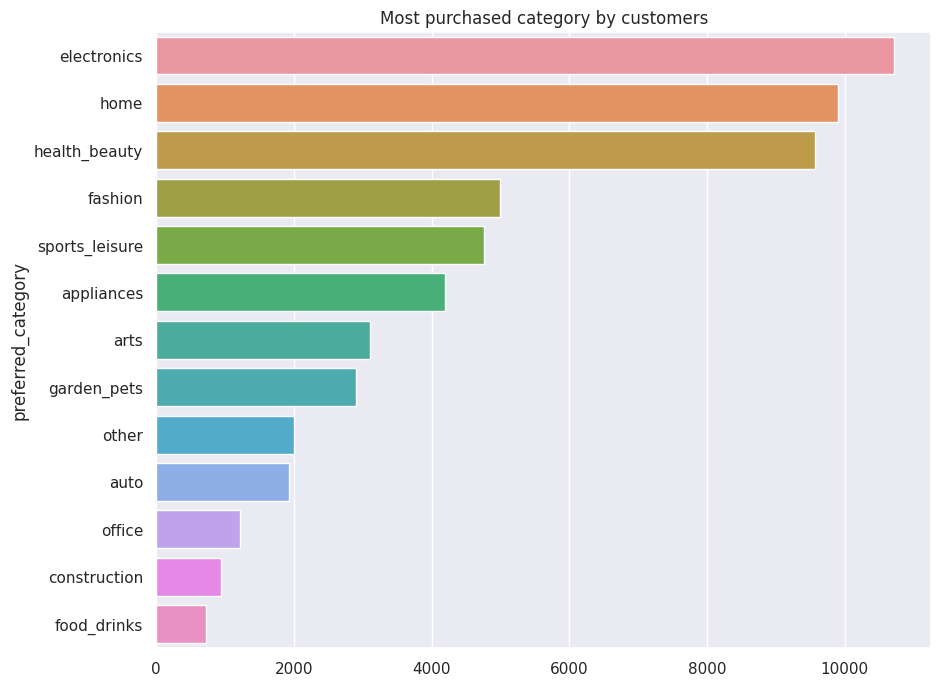

In [ ]:
categories = client_data.groupby(['preferred_category']).count()[
    'customer_city'].sort_values(ascending=False)
plt.figure(figsize=(10,8))
plt.title('Most purchased category by customers')
sns.barplot(x = categories.values,
           y = categories.index);

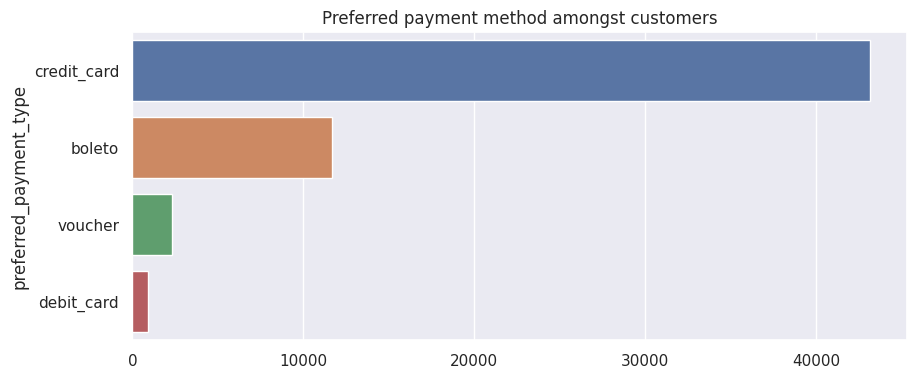

In [ ]:
payment = client_data.groupby(['preferred_payment_type']).count()[
    'customer_city'].sort_values(ascending=False)
plt.figure(figsize=(10,4))
plt.title('Preferred payment method amongst customers')
sns.barplot(x = payment.values,
           y = payment.index);

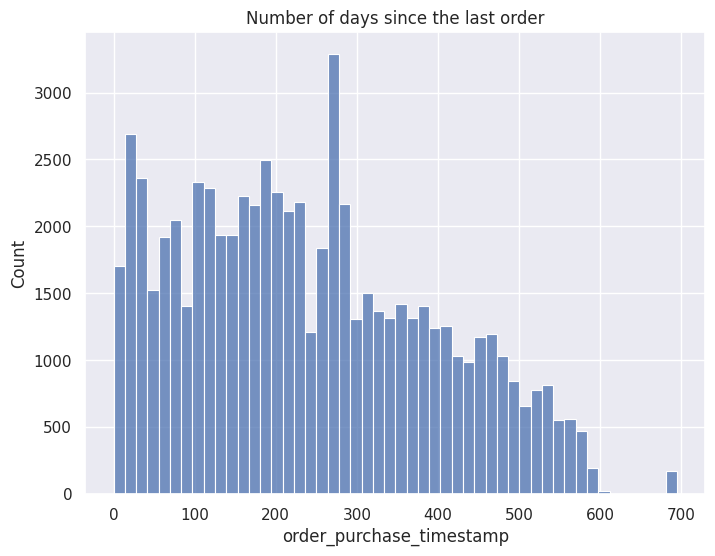

In [ ]:
purchase_delay = client_data['order_purchase_timestamp'].max() - client_data['order_purchase_timestamp']
plt.figure(figsize=(8, 6))
plt.title('Number of days since the last order')
sns.histplot(purchase_delay.dt.days, bins=50);
plt.show();

### PCA

In [ ]:
number_columns = df.select_dtypes(include = ['int64', 'int32','float64']).columns
X_pca = df[number_columns]

In [ ]:
test_completion(X_pca)

,Completion rate,Number of missing values
customer_zip_code_prefix,100.00,0
payment_installments,100.00,0
avg_review_score,100.00,0
max_purchase_price,100.00,0
avg_purchase_price,100.00,0
nb_products,100.00,0
delivery_delay,100.00,0
order_purchase_day,100.00,0
order_purchase_hour,100.00,0
review_score,100.00,0


In [ ]:
X_pca.drop(columns=['geolocation_zip_code_prefix', 'geolocation_lat_mean', 'geolocation_lng_mean'], inplace=True)
replace_nan(X_pca, ['max_installments'], method='median')

<ipython-input-125-7a3306460fc9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pca.drop(columns=['geolocation_zip_code_prefix', 'geolocation_lat_mean', 'geolocation_lng_mean'], inplace=True)
<ipython-input-5-04d2402c470c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c].fillna(df[c].median(), inplace=True)


In [ ]:
X_scaled = pd.DataFrame(preprocessing.scale(X_pca),columns = X_pca.columns)

In [ ]:
model = pca()
results = model.fit_transform(X_scaled)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [23] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [16] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [23] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[16]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


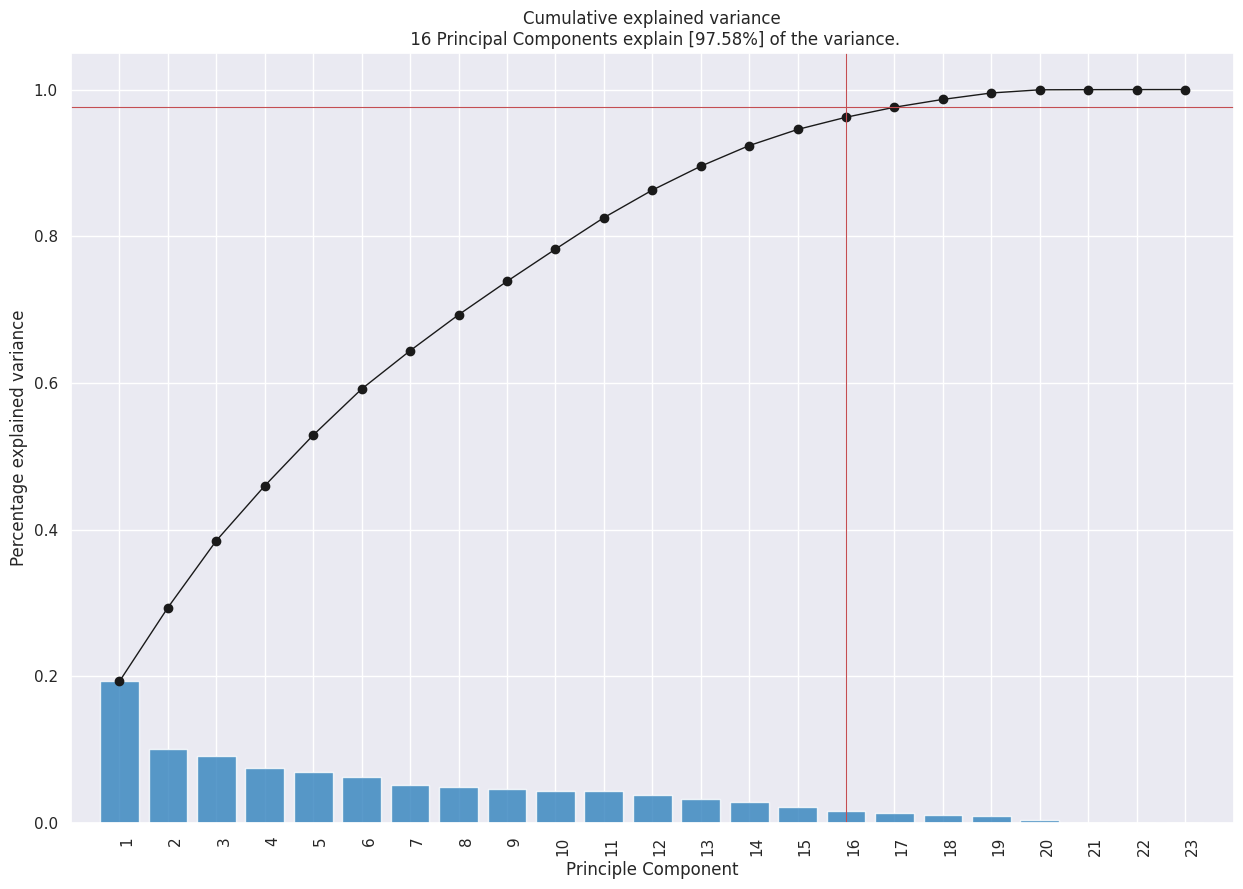

<Figure size 640x480 with 0 Axes>

In [ ]:
model.plot();

**Let's use another PCA model to get the vector graph**

In [ ]:
pca = PCA(random_state=1)
pca.fit(X_scaled)

PCA(random_state=1)

In [ ]:
# PCA Vector graph
pca_columns = X_pca.columns

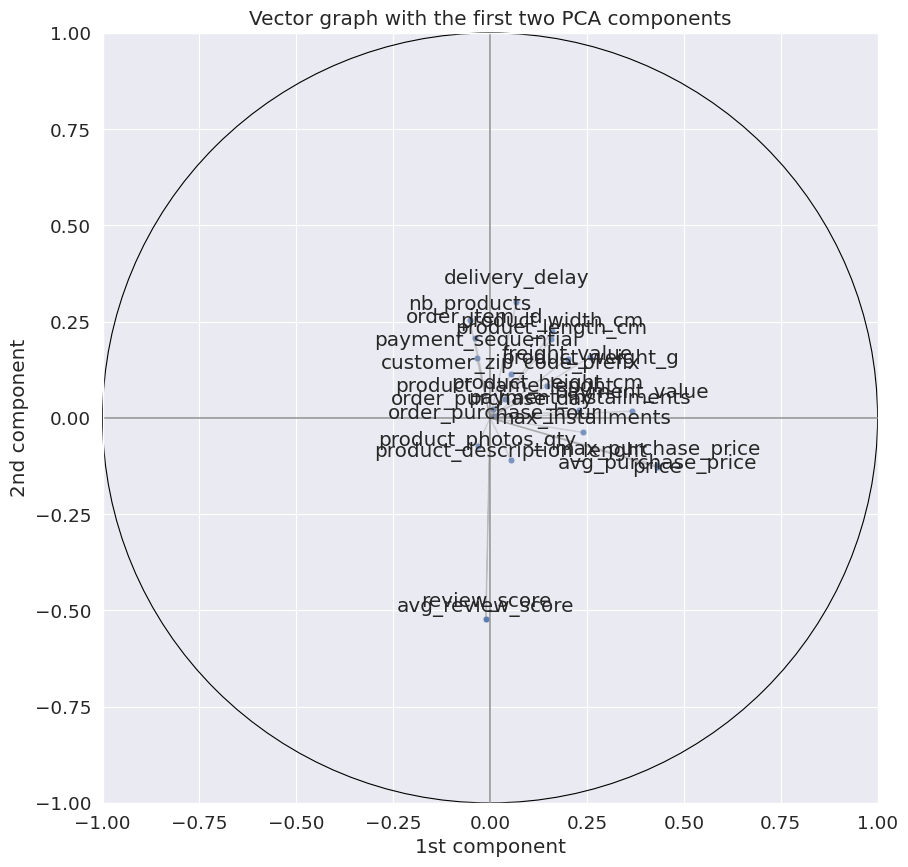

In [ ]:
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(10,10))
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.title('Vector graph with the first two PCA components')
ax = plt.gca()
ax.add_patch(Circle([0,0], radius=1, color='black', fill=False, linestyle='-', clip_on=False))
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
x_pca = pca.components_[0,:]
y_pca = pca.components_[1,:]

sns.scatterplot(x=x_pca, y=y_pca, alpha=0.7)
plt.plot([-1,1],[0,0], color='grey', alpha=0.8)
plt.plot([0,0],[-1,1], color='grey', alpha=0.8)

i = 0
for x,y,column in zip(x_pca, y_pca, pca_columns):
  plt.annotate(column, (x, y), textcoords="offset points", xytext=(0,5+np.random.randint(-10, 10)), ha='center')
  ax.arrow(0, 0, x, y, head_width=0, head_length=0, fc='grey', ec='grey', alpha=0.2)

sns.set_context('paper', font_scale=1)